In [1]:
from utils.card_engine import Card_Game, Card_Env, random_agent

In [2]:
import math
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from itertools import count



# global game gym
env = Card_Env()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

# Replay Memory

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        # save a transition
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

# Q network

In [4]:
class DQN(nn.Module):

    # n_input: the current state
    #  (1x52)    +  (56x52)       +       (1x52): the current state
    #    ^hand       ^who plays each card  ^cards not seen yet
    #                       + cards played
    # n_output: probability of playing each card
    #   (1x52)
    def __init__(self, n_input, n_output):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_input, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_output)

    def forward(self, x):
        if x.dtype == torch.float32:
            x = F.relu(self.layer1(x))
            x = F.relu(self.layer2(x))
        else:
            x=x.to(torch.float32)
            x = F.relu(self.layer1(x))
            x = F.relu(self.layer2(x))
        return self.layer3(x)

# Training

### The network agent
Selects a move according to epsilon-greedy policy:
sometimes uses the model to select move, sometimes just select one randomally

In [5]:
# hyper-parameters
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000

BATCH_SIZE = 100
MEMORY_SIZE = 10000

# Learning rate of the optimizer
LR = 1e-4

# soft update rate
TAU = 0.005

# future discount
GAMMA = 1.0


state = env.game.get_network_input()

n_input = len(state)
n_actions = 52

policy_net = DQN(n_input, n_actions).to(device)
# use a target network to prevent oscillation or divergence
target_net = DQN(n_input, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())


optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(MEMORY_SIZE)

steps_done = 0

'''
Given the game state, select an action by the epsilon-greedy policy
'''
def select_action(game):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    # epsilon-greedy choice
        
    if sample > eps_threshold:
        with torch.no_grad():
            # return the index of the card with highest probability
            # predicted from the policy net
            print(policy_net(game.get_network_input().to(torch.float32).to(device)))
            return policy_net(game.get_network_input().to(torch.float32).to(device)).max(0).indices.view(1,1)
    else:
        # random select a legal action
        return torch.tensor([[game.sample_legal_move()]], device=device, dtype=torch.long) #changed from long



### Training loop

In [6]:
'''
A single step optimization of the model using Deep Q-Learning
1) samples a batch from memory, concatenates all the tensors into a single one
2) computes Q(s_t, a_t) and V(s_{t+1}) = max_a Q(s_{t+1}, a), where s_t --(a_t)--> s_{t+1}
3) computes the loss
4) updates the target network (which is computing V(s_{t+1})) at every step with soft update
'''
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # mask the non final states and find the corresponding next states
    # We need an illegal move to be a non-final state
    # Right now, we are throwing out all the final states which include the case when
    # the agent ends the game prematurely after playing an illegal move
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    print('non_final_mask is', non_final_mask)
    non_final_next_states = [s for s in batch.next_state if s is not None]
    if non_final_next_states == []:
        return
    non_final_next_states = torch.cat(non_final_next_states)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    print('reward_batch is', reward_batch)
    
    
    # compute Q(s_t, a)
    # for each state in the batch, find the value of the corresponding action
    state_action_values = policy_net(state_batch.to(torch.float)).gather(1, action_batch)
    # compute V(s_{t+1}) = max_a Q(s_{t+1}, a) for the next_states using the target_net
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    # R + \gamma max_a Q(s', a)
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # compute the Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # back propagate
    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


In [7]:
# the main training loop
step_counts = []

if device != torch.device('cpu'):
    num_episodes = 1000
else:
    num_episodes = 1000

for i_episode in range(num_episodes):
    # initialize the game
    env.reset()
    game = env.game
    state = torch.tensor(game.get_network_input(), dtype=torch.long, device=device).unsqueeze(0)
    #print('i_episode is', i_episode)

    for t in count():
        #print('t is ', t)
        # play until the game ends
        if game.hands[game.current_player].sum(0) != 0:
            print("Hand:", game.hands[game.current_player])
            action = select_action(game)
            print("Card:", action)
            print('The step function is called')
            observation, reward, terminated = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated
        else:
            print('A player has no cards left')
            terminated = True
            done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            
        #print('the transition tuple being pushed into memory is')
        #print('state', state)
        #print('action', action)
        #print('next_state', next_state)
        #print('reward', reward)
        # store the transition in memory
        memory.push(state, action, next_state, reward)

        # move to the next state
        state = next_state

        # perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)


        if done:
            print(f'{i_episode}-th game ends in {t} steps')
            step_counts.append(t)
            break
        


C:\Users\Shin\AppData\Local\Temp\ipykernel_4412\585085315.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(game.get_network_input(), dtype=torch.long, device=device).unsqueeze(0)
C:\Users\Shin\Documents\dqn-trick-game\utils\card_engine.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  card = torch.nn.functional.one_hot(torch.tensor(deck_index, dtype=int), self.num_cards * self.num_players).flatten()
C:\Users\Shin\AppData\Local\Temp\ipykernel_4412\585085315.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ne

Hand: tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0])
Card: tensor([[25]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
Hand: tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0])
Card: tensor([[2]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
Hand: tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0

player tensor(1) is playing
player tensor(2) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
Hand: tensor([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0])
Card: tensor([[47]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
Hand: tensor([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0])
Card: tensor([[49]])
The step function is called
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
Hand: tensor([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

tensor([-0.0581, -0.0645, -0.0575, -0.0835, -0.0607, -0.0125, -0.0387, -0.0932,
        -0.0669,  0.0067, -0.0105,  0.0594, -0.0176,  0.0377,  0.0015, -0.0094,
        -0.0756,  0.0174, -0.0335,  0.0822,  0.0153, -0.1097,  0.0687,  0.0086,
        -0.0646, -0.0008,  0.0024,  0.0884,  0.0806, -0.0356,  0.0799, -0.0144,
        -0.0726, -0.0499, -0.0446,  0.0354, -0.0624,  0.0814, -0.0209, -0.0704,
        -0.0593, -0.0621,  0.0089,  0.1145, -0.0078, -0.0200,  0.0996, -0.0701,
         0.1017, -0.0381, -0.0263, -0.0574])
Card: tensor([[43]])
The step function is called
player plays an illegal move
10-th game ends in 3 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0])
Card: tensor([[32]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is pl

Card: tensor([[2]])
The step function is called
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
Card: tensor([[10]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
Card: tensor([[20]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0])
Card: tensor([[19]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True, False, False,  True,  True,  True,  True,  True,  True,
         True, False,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True, False,  True,  True,  True,  True,
         Tru

15-th game ends in 12 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0])
Card: tensor([[49]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False, False,  True, False,  True,  True,
         True,  True,  True,  True

Hand: tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 0])
Card: tensor([[16]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True, False,  True,  True, False,  True,  True,  True,  True,  True,
        False, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True, False,  True, False,  True, False,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  Tru

Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
Card: tensor([[39]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True,  True,  True,  True,  True,  True, False,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
         True, False,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  Tru

21-th game ends in 12 steps
Hand: tensor([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0])
Card: tensor([[32]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True, False, False,  True,  True,
        False, False,  True,  True,  True,  True,  True,  True

player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True, False, False,  True,  True])
reward_batch is tensor([  0,   0,   0,   0,   1,   0,   0,   0,   0,   0, -10,   0,   1,   0,
          1,   0,   0,   1,   0

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True, False,  True, False,  True,  True,  True,
         True,  True, False,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
        False,  True,  True, False,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True, False, False,  True, False,  True])
reward_batch is tensor([  0, -10,   0, -10,   0,   0,   0,   0,   0,   0,   0,   0, -10,   0,
        -10,   0, -10,   1,   0,   0,   1,   0, -10,   0,  

Hand: tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1])
Card: tensor([[27]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  True,  True,  True,  True, False, False,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False,  True,  True, False,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  Tru

Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0])
Card: tensor([[16]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
        False,  True,  True,  True,  True, False,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True, False,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        Fals

Hand: tensor([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0])
Card: tensor([[30]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False, False,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True, False, False,  True,  True,  True,  True,  True

Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0])
tensor([ 0.0945,  0.1086,  0.0492,  0.0590,  0.0830, -0.0297, -0.0129,  0.0339,
         0.0622,  0.0406, -0.0067,  0.2327,  0.1455,  0.1255,  0.1017,  0.0288,
        -0.0844,  0.1335,  0.1604,  0.1182,  0.1768, -0.0804,  0.2257,  0.0663,
         0.0664,  0.3285,  0.0819,  0.1290,  0.1420,  0.0571,  0.0599,  0.0268,
         0.0144,  0.0752,  0.0345,  0.0120, -0.0132,  0.2701, -0.0394,  0.0646,
         0.0033,  0.0608,  0.1091, -0.3434,  0.0841,  0.0666,  0.0274,  0.1269,
         0.0780,  0.0496,  0.1411,  0.1668])
Card: tensor([[25]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True, 

32-th game ends in 0 steps
Hand: tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0])
Card: tensor([[1]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  True, False,  True,  True,  True, False,  True,
         True,  True, False,  True,  True, False,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True, False, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, 

reward_batch is tensor([  0,   0,   0, -10,   0,   0, -10,   0,   0,   0,   0, -10,   0,   0,
          0,   0,   0,   0,   0, -10,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, -10,   0,   0, -10,   0,   0,   0,   1, -10,   1,
          0,   1,   0,   0,   1,   0,   0,   0,   0,   1, -10,   0,   1,   0,
          0,   0, -10,   1,   0,   1,   1,   0, -10,   0,   0,   0,   0,   0,
          0, -10,   0,   0,   0, -10, -10, -10,   1,   0,   0,   1,   1, -10,
          0, -10,   0,   0,   0,   0,   1, -10,   0, -10, -10,   0,   0,   0,
          0,   0])
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 1])
Card: tensor([[12]])
The step function is called
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         Tr

Hand: tensor([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
Card: tensor([[5]])
The step function is called
player tensor(1) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True, False,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  Tru

player tensor(2) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True, False,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False,  True,  True,  True,  True, False, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True])
reward_batch is tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, -10,   0,
          0,   1,   0, -10,   1

Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0])
Card: tensor([[48]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
        False, False,  True,  True, False,  True, False, False,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True, False,  True,
         True,  Tr

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True, False,  True, False,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False,  True,  True,
        False, False,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True, False,  True,
         True, False,  True,  True,  True, False,  True, False, False,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True])
reward_batch is tensor([  1,   0,   0,   0,   0, -10,   0, -10,   0,   0,   0,   0,   0,   1,
        -10,   1,   0,   0,   0,   0,   0,   0, -10,   0,  

reward_batch is tensor([-10, -10,   0,   1,   0,   0,   1,   0,   0, -10,   0,   0,   1,   0,
          0, -10,   0,   1,   0,   0, -10,   1,   0, -10,   0,   1,   0,   0,
          0,   0, -10,   0, -10,   0,   0,   1,   1,   0,   0,   0,   0,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0, -10,   0,
          0,   0,   0,   0,   1,   1,   0,   1,   0,   0,   1,   1,   0,   0,
          0,   0, -10,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,
          0, -10, -10,   0,   0,   0,   1,   1,   0,   0,   0,   0,   0, -10,
          0,   0])
42-th game ends in 2 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0])
Card: tensor([[30]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3)

player plays an illegal move
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True, False,  True,  True,  True,  True, False, False,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True, False,  True,  True, False, False,  True, False,
        False,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True, False, False,  True,  True,  True,  True, False,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True])
reward_batch is tensor([  1,   0,   0,   0,   0,   0,   0,   0, -10,   0,   0,   0,   0, -10,
          0,   0,   1, -10,   0,   1,   0,   1, -10,   1,   0,   0,   0, -10,


Hand: tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 0])
Card: tensor([[42]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False,  True,
         True,  True, False,  True,  True, False,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True, False, False, False,  True, False, False, False,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True, Fals

player plays an illegal move
non_final_mask is tensor([ True,  True,  True,  True, False, False,  True, False, False, False,
        False, False,  True,  True, False,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True, False,  True,  True,
        False,  True,  True,  True,  True, False,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True])
reward_batch is tensor([  0,   0,   0,   0, -10, -10,   0, -10, -10, -10, -10, -10,   1,   0,
        -10,   1, -10,   0,   0,   0,   0,   0,   0,   0,   1,   0,   1,   1,


Hand: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 0])
tensor([ 0.2247,  0.1379,  0.4025,  0.1334,  0.4091,  0.2335,  0.4571,  0.2969,
         0.1698,  0.1734,  0.3254,  0.4301,  0.3168,  0.1526,  0.1542,  0.1957,
         0.0357,  0.1786,  0.1506,  0.1593,  0.1898,  0.3362,  0.1206,  0.4249,
         0.2064,  0.1491,  0.1313,  0.1349,  0.1874,  0.1292,  0.0614,  0.1267,
         0.1574,  0.0905,  0.1128,  0.0953,  0.3770,  0.2598, -0.2019,  0.1711,
         0.1336,  0.1089,  0.2210, -2.4666,  0.1327,  0.0954,  0.0435,  0.5300,
        -0.6655,  0.2314,  0.5782,  0.6673])
Card: tensor([[51]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
        False,  True,  True,  True, 

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True, False, False,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False,  True, False,  True, False,
         True,  True,  True,  True, False,  True,  True, False,  True,  True])
reward_batch is tensor([  0,   0, -10,   1,   0,   0,   0,   0,   0,   0,   0,   1,   1,   0,
          1,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True,  True,  True,  True,  True,  True, False,  True,  True,
        False,  True,  True, False,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False,  True, False,  True,  True, False, False,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True, False, False,  True, False,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True, False,  True,  True,  True, False, False,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False, False])
reward_batch is tensor([-10,   0,   0,   0,   0,   0,   0, -10,   0,   1, -10,   0,   1, -10,
   

Hand: tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0])
Card: tensor([[29]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False,  True, False, False,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False,  True,  True,
         Tru

60-th game ends in 3 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1])
Card: tensor([[27]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True, False, False,  True,  True, False,
         True,  True, False,  True,  True, False,  True,  True, False,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False, False,  True, False,
         True,  True,  True,  True,  True, False,  True,  True, False,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
        False, False, False, False,

Hand: tensor([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
Card: tensor([[30]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True, False,  True,  True, False,  True,  True, False,  True,
         True, False,  True,  True,  True,  True, False, False,  True,  True,
        False,  True,  True,  True,  True,  True,  True, False,  True,  True,
        False,  True, False,  True, False,  True,  True,  True,  True,  True,
         True, False,  True, False,  True,  True,  True, False,  True,  True,
         True,  True, False, False,  True,  True,  True, False,  True,  True,
        False, False,  True, False,  True, False,  True,  True,  True, False,
         Tru

reward_batch is tensor([-10,   0, -10,   1,   0, -10,   0,   0,   0,   0,   0,   0,   0, -10,
          0,   1,   1,   0,   0,   0,   0,   1, -10,   1,   0,   0,   0,   0,
          1,   0,   0, -10,   0,   0,   0,   1,   0,   0,   1,   0, -10,   0,
          1, -10,   0,   0,   0, -10,   0,   0,   1,   0,   1,   1,   0,   0,
          0,   0,   0,   1,   0,   0,   0,   0,   0, -10,   0, -10,   0,   1,
        -10,   0,   1,   0, -10,   0,   1,   0, -10, -10, -10,   0,   0,   1,
          0,   1, -10,   0,   0, -10,   0,   0,   0, -10,   0,   0,   0, -10,
        -10, -10])
67-th game ends in 0 steps
Hand: tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0])
Card: tensor([[48]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor

Hand: tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0])
Card: tensor([[1]])
The step function is called
player tensor(1) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True, False,  True, False,  True,  True,
         True,  True,  True,  True, False,  True,  True, False,  True,  True,
        False,  True,  True, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True, False,  True,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True, False,  True,  True, False,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True, False,  True,  True,  True,  True,
        False, Fals

Hand: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([ 0.3401,  0.0811,  0.3613,  0.1324,  0.2792,  0.2347,  0.3542,  0.3785,
         0.0829,  0.2338,  0.2711,  0.1318, -0.0063,  0.1883,  0.2654,  0.1915,
         0.1261,  0.2087,  0.2117,  0.1842,  0.4706,  0.3757, -0.5299,  0.1473,
         0.4444, -0.1433,  0.1555,  0.2487,  0.0652,  0.1772,  0.2153,  0.2046,
         0.1817,  0.0267,  0.1412,  0.4483,  0.6353,  0.0363,  0.0568,  0.1689,
         0.0983,  0.1695,  0.1578, -4.7738,  0.0966,  0.1122,  0.3404,  0.3331,
        -1.4505,  0.5398,  0.2250,  0.0644])
Card: tensor([[36]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  Tru

Hand: tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0])
tensor([ 0.2795,  0.2137,  0.4328,  0.2506,  0.3115,  0.2473,  0.3598,  0.3323,
         0.1723,  0.2776,  0.4440,  0.2498, -0.0597,  0.1905,  0.1762,  0.2346,
         0.1857,  0.2462,  0.3300,  0.2473,  0.6404,  0.3219, -0.4688,  0.0356,
         0.4743, -0.1287,  0.1816,  0.2483,  0.1226,  0.2490,  0.1982,  0.1964,
         0.2806,  0.0812,  0.2160,  0.5371,  0.6251,  0.1453,  0.0528,  0.2710,
         0.1933,  0.2122,  0.2599, -5.4075,  0.0976,  0.1141,  0.4136,  0.2041,
        -2.0538,  0.5369, -0.0213,  0.0078])
Card: tensor([[20]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tenso

non_final_mask is tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True, False,  True,  True,
         True,  True, False,  True, False,  True, False,  True,  True,  True,
         True,  True, False,  True,  True, False,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True, False, False,  True,  True,
         True, False,  True,  True,  True, False,  True,  True, False,  True,
         True,  True, False,  True,  True, False,  True,  True,  True, False,
         True,  True,  True,  True,  True, False,  True,  True, False,  True,
        False, False, False,  True,  True,  True,  True,  True,  True,  True])
reward_batch is tensor([  0,   0, -10,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   1,
          0, -10,   0, -10,   0,   0,   0,   0, -10,   0, -10,   0, -10,   0,
          1,   1,   0,   0, -

Card: tensor([[35]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False, False,  True, False,
         True,  True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True,  True, False,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True])
reward_batch is tensor([  0,   0,   0,   0, -10,   0,   1,   0,   0,   1,   1,   1, -10, -10,
          0,   0,   1,   1,  

81-th game ends in 4 steps
Hand: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0])
Card: tensor([[9]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True, False, False, False,  True,  True,
         True,  True,  True,  True,  True, False, False,  True,  True, False,
         True,  True,  True,  True, False,  True,  True,  True,  True, False,
         True, False,  True,  True,  True,  True,  True, False, False, False,
         True,  True,  True,  True,  True,  True,  True, False,  True, False,
         True,  True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True, False,

Hand: tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([ 0.2902,  0.2785,  0.4333,  0.3563,  0.5223,  0.4155,  0.2678,  0.4501,
         0.3135,  0.4018,  0.5592,  0.4090, -0.7777,  0.3344,  0.3607,  0.3199,
         0.2562,  0.3743,  0.2385,  0.3311,  0.4474,  0.4451, -0.1055, -0.3664,
         0.5502, -0.0615,  0.1897,  0.3398,  0.3188,  0.1803,  0.1364,  0.2692,
         0.3026,  0.4167,  0.3511,  0.3419,  0.2855,  0.7170,  0.1759,  0.3210,
         0.4360,  0.2714,  0.4462, -7.1048,  0.2735,  0.1275,  0.5190,  0.0585,
        -3.3449,  0.3126, -0.5054,  0.0262])
Card: tensor([[37]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True, False,  True,  True,
         True,  True,  True, False, 

reward_batch is tensor([  0,   1,   0,   1,   0, -10, -10,   0,   0,   0, -10,   0,   0,   0,
          1,   0,   0, -10,   0,   0,   0,   1, -10,   0,   1,   0,   1,   0,
        -10,   1,   0,   0, -10, -10,   0, -10, -10,   1,   0,   0,   0,   1,
          0,   0, -10,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, -10,   0,   0, -10,   0,   0,   1,   1,   0,   1,   0, -10, -10,
          0,   1, -10,   0,   0,   1,   1,   0,   0,   0, -10,   1,   0,   0,
          0,   0,   1,   0,   1, -10,   0,   0, -10, -10, -10,   0, -10,   0,
          0,   1])
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1])
Card: tensor([[51]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  Tru

Hand: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 0])
Card: tensor([[16]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True, False,  True, False,  True,  True,  True,
        False, False, False,  True, False,  True,  True,  True, False, False,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False, False,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  Tru

reward_batch is tensor([-10,   1,   0,   1,   1,   1,   0,   0,   0, -10, -10,   0,   0,   0,
          1,   0, -10,   0,   1,   0,   0,   0,   0,   0, -10, -10,   1,   0,
          0,   0,   0, -10,   0, -10,   0,   1,   0,   0,   0,   0, -10,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   0,   1,   0, -10,
          1,   1,   0,   0, -10,   0,   1,   0,   1,   0,   0, -10,   0,   0,
        -10,   1,   0, -10,   0,   0, -10,   0, -10,   0, -10,   0,   0,   0,
          0,   0,   1,   1, -10,   1, -10,   0,   0, -10,   0,   0,   0, -10,
        -10,   0])
Hand: tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0])
tensor([ 0.2902,  0.2008,  0.4372,  0.3495,  0.0440,  0.3843,  0.0942,  0.4324,
         0.2588,  0.4277,  0.3877, -0.0858, -0.7514,  0.3340,  0.3529,  0.3176,
         0.2845,  0.4605,  0.3283,  0.3114,  0.1771,  0.4048, -1.1329, -

reward_batch is tensor([  1,   0,   0, -10, -10,   0,   1,   0,   0,   0,   0,   0, -10,   0,
        -10,   0, -10,   0,   0,   1,   1,   0,   0,   0,   0,   0,   0, -10,
          0, -10,   1,   1, -10,   1,   0,   0,   0,   0, -10,   1,   0,   0,
          0,   0, -10,   1,   0, -10, -10, -10, -10,   0,   0,   0,   0,   1,
          0, -10,   0,   0,   0, -10, -10,   0,   0, -10, -10,   1,   0,   0,
          1,   0,   1,   1, -10, -10,   1,   0,   1,   0,   0,   1,   0,   1,
          0,   0,   0, -10,   1,   0,   0,   0, -10,   0,   1,   0,   0, -10,
        -10,   0])
94-th game ends in 6 steps
Hand: tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 0])
Card: tensor([[44]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0)

player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False,  True,  True,  True,
         True, False,  True, False,  True, False,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True, False,  True,
        False,  True, False,  True,  True, False,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False, False,  True,  True,  True,  True, False,
         True,  True,  True, False,  True,  True,  True,  True, False,  True,
        False,  True,  True, False, False,  True,  True,  True,  True,  True])
reward_batch is tensor([  1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, -10,   0,   0,   0

97-th game ends in 4 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 0, 1])
tensor([ 3.7047e-01,  2.3128e-01,  6.1886e-01,  2.4211e-01,  3.0297e-01,
         4.1889e-01, -1.8722e-03,  4.7990e-01,  5.3785e-01,  2.0384e-01,
         2.0421e-01, -3.2468e-02, -6.7359e-01,  3.8378e-01,  3.1033e-01,
         3.7797e-01,  2.8207e-01,  4.2223e-01,  4.3010e-01,  2.9225e-01,
         9.7593e-02,  5.1273e-01, -9.0794e-01, -4.1789e-01,  5.0975e-01,
        -1.8715e-01,  2.8425e-01,  2.4122e-01,  2.9394e-01,  3.4896e-01,
         3.9287e-01,  4.0445e-01,  3.8290e-01,  4.1563e-01,  2.6744e-01,
        -1.9051e-01,  2.6823e-01,  4.9170e-01,  3.1356e-01,  3.3935e-01,
         3.0441e-01,  3.9370e-01,  3.4004e-01, -6.0949e+00,  2.5684e-01,
         2.3954e-01,  3.7726e-01, -7.9493e-02, -2.9145e+00,  2.9247e-01,
        -2.1398e-01, -1.3268e-01])
Card: tensor([[2]])
T

non_final_mask is tensor([False,  True, False,  True,  True,  True,  True, False,  True,  True,
         True,  True, False,  True,  True, False,  True, False, False,  True,
         True,  True,  True,  True,  True,  True, False,  True, False,  True,
        False, False,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True, False,  True, False,  True,  True,  True,  True,  True,
        False,  True,  True, False, False,  True,  True,  True,  True,  True])
reward_batch is tensor([-10,   0,   0,   0,   0,   0,   0, -10,   1,   0,   0,   0, -10,   0,
          1, -10,   0, -10, -10,   1,   0,   0,   0,   0,   0,   1, -10,   0,
        -10,   0, -10, -10,  

reward_batch is tensor([-10,   0,   1,   1,   0, -10,   0,   1,   0, -10,   0,   0,   0, -10,
          1,   0,   0,   0,   0, -10,   0,   0,   0, -10,   0,   1, -10,   0,
        -10,   0,   0,   1,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        -10, -10, -10, -10,   0,   0,   0,   1, -10,   0,   0,   0,   0,   1,
          0, -10,   1,   0,   1,   0,   0,   0,   1,   0,   1,   0,   0,   0,
          0, -10,   0,   0, -10,   1,   0,   0, -10,   0,   0,   0,   0,   1,
          1, -10,   0, -10, -10, -10,   0,   1, -10,   1,   0, -10,   0,   0,
          1,   0])
Hand: tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0])
Card: tensor([[46]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn a

Hand: tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 1])
tensor([ 0.3201,  0.2553,  0.3284,  0.4925,  0.1022,  0.3711, -0.1906,  0.3740,
         0.3165,  0.3109,  0.1442, -0.1667, -1.2819,  0.2488,  0.3659,  0.3932,
         0.3258,  0.2683,  0.3781,  0.3113,  0.1157,  0.3701, -1.8259, -0.2634,
         0.4433, -1.3299,  0.2889,  0.3352, -0.0304,  0.2469,  0.4322,  0.2363,
         0.3136,  0.1646,  0.2284, -0.4032,  0.2712,  0.0256,  0.4047,  0.3509,
         0.1854,  0.3797,  0.2255, -6.5406,  0.0846,  0.2944,  0.2334,  0.3635,
        -3.4439,  0.3212, -0.1678, -0.8137])
Card: tensor([[3]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True, False,  True,  True,  True, False,  True,  True,
        Fals

tensor([ 0.2079,  0.3545,  0.3021,  0.6380, -0.0227,  0.3159, -0.0183,  0.3113,
         0.5836,  0.3025,  0.2349, -0.2348, -0.8595,  0.3641,  0.3519,  0.3566,
         0.4074,  0.4197,  0.5425,  0.4354,  0.0836,  0.4347, -2.3341, -0.4580,
         0.6994, -0.6873,  0.2663,  0.0775,  0.2408,  0.4285,  0.2947,  0.4199,
         0.4460,  0.0678,  0.1719, -0.6167,  0.3742,  0.6120,  0.7556,  0.3582,
         0.1857,  0.3570,  0.1774, -6.0926,  0.0850,  0.2479,  0.3887,  0.2382,
        -3.8912,  0.4684, -0.3130, -0.5049])
Card: tensor([[38]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True, False,  True,  True, False,  True, False,  True,
         True, False,  True,  True,  True, False,  True,  True, False, False,
         True,  True, False,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,

Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 0])
Card: tensor([[32]])
The step function is called
player tensor(1) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True, False, False,  True,  True,  True,  True, False,  True,
         True,  True,  True, False,  True,  True,  True, False, False,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
        False,  True,  True, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True, False, False,  True,  True,  True,  True, False,
         True,  True, False,  True,  True, False,  True,  True,  True, False,
         True,  True, False,  True,  True,  Tr

Hand: tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 0])
Card: tensor([[43]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
        False,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True, False, False,  True,  True,  True, False,
        False,  True,  True,  True,  True, False,  True, False,  True, False,
         True,  True, False,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
        Fals

reward_batch is tensor([  0,   0, -10, -10,   0,   0, -10,   1, -10,   1,   0,   0,   1,   0,
        -10,   0,   0,   0,   0,   1, -10,   0,   1,   1,   0,   1,   0, -10,
          0, -10,   0,   0, -10,   1,   0, -10,   0, -10,   1, -10, -10,   0,
          0,   0,   1,   0, -10, -10, -10,   0,   0,   0,   0, -10,   1,   0,
        -10,   1, -10,   0,   0, -10,   1,   0, -10,   0,   1,   0,   1,   0,
          0, -10,   0,   0,   0,   0,   0,   0, -10,   0,   0,   1, -10,   0,
          0, -10, -10,   0,   0,   1,   0,   0,   0,   0, -10,   0,   0,   0,
          1,   0])
118-th game ends in 1 steps
Hand: tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0])
Card: tensor([[40]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3

120-th game ends in 2 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 0])
tensor([ 0.2470,  0.5215,  0.2961,  0.4749,  0.2444,  0.3859, -0.0828,  0.2039,
         0.3117,  0.1274,  0.4704,  0.2565, -1.6622,  0.3926,  0.3927,  0.4880,
         0.4479,  0.3540,  0.3189,  0.4271, -0.0377,  0.4852, -1.2851, -0.2958,
         0.8016, -0.5475,  0.3351,  0.1703,  0.3407,  0.4926,  0.3643,  0.3963,
         0.6332,  0.2587,  0.3286, -0.3565,  0.2195,  0.4085,  0.1826,  0.5512,
         0.3076,  0.3619,  0.2164, -6.3295,  0.0540,  0.4345,  0.4570,  0.0322,
        -5.0494,  0.4107, -0.2091, -0.3198])
Card: tensor([[24]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True, False,  True, False,  True, False,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
        

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False, False,  True, False, False, False, False,  True,  True,
         True,  True,  True,  True, False,  True, False,  True,  True,  True,
         True,  True, False, False,  True,  True,  True, False,  True,  True,
        False,  True,  True,  True, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True, False, False,
        False,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
        False,  True, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True, False,  True, False,  True,  True,  True,  True])
reward_batch is tensor([  0, -10, -10,   0, -10, -10, -10, -10,   1,   0,   0,   0,   1,   0,
        -10,   0, -10,   0,   0,   0,   0,   0, -10, -10,  

129-th game ends in 1 steps
Hand: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 0])
tensor([ 0.2883,  0.4391,  0.3008,  0.2443,  0.1553,  0.4737, -0.0349,  0.2459,
         0.2873,  0.2643,  0.5900,  0.4016, -1.6874,  0.4471,  0.5185,  0.4510,
         0.4914,  0.4682,  0.4713,  0.4506, -0.0627,  0.5157, -1.5545, -0.4660,
         0.5849, -0.3639,  0.3334,  0.2336,  0.5056,  0.5240,  0.1926,  0.5339,
         0.5222,  0.3027,  0.4043, -0.4972,  0.0828,  0.5674, -0.4449,  0.4967,
         0.3909,  0.4028,  0.2536, -5.8927,  0.0845,  0.4963,  0.3733, -0.1222,
        -4.9873,  0.3968, -0.2733, -0.5950])
Card: tensor([[10]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True, False, False,  True,  True, False, False,  True, False,
        

reward_batch is tensor([  1,   0,   0,   0,   0,   0,   0, -10,   0,   0,   0,   0, -10, -10,
          0,   0,   0, -10,   0,   0,   0,   1,   0,   0,   0,   0,   1,   1,
          1,   0,   1, -10,   1,   0, -10,   0,   0,   1,   0,   1,   1,   0,
          0, -10,   0, -10,   1,   0,   1,   0,   0,   0, -10,   1,   1,   0,
        -10,   0,   0,   0, -10,   0, -10, -10,   1,   0, -10,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   1,   1,   1,   0,   0, -10,   0,
          0,   0,   1,   0,   0, -10, -10, -10,   1,   1,   1,   0,   0, -10,
        -10,   0])
Hand: tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0])
Card: tensor([[43]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  Tru

135-th game ends in 1 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 1])
Card: tensor([[35]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True, False, False, False,  True,  True, False,  True,  True,
         True,  True, False,  True, False,  True,  True, False, False, False,
         True,  True,  True,  True, False, False, False, False,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False,  True,  True,  True, False,  True,
         True,  True, False,  True, False,  True,  True,  True, False,  True,
         True,  True,  True,  True

non_final_mask is tensor([ True, False,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
        False,  True, False,  True,  True, False,  True,  True, False,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True, False,
        False, False, False,  True,  True, False, False,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True, False,  True,  True, False,
         True,  True, False, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True, False,  True,  True,  True,
        False,  True,  True,  True, False,  True,  True,  True,  True,  True])
reward_batch is tensor([  0, -10,   1,   0, -10,   0,   0,   0,   0,   0,   1,   1,   0,   1,
          0,   1,   0,   0, -10,   1, -10,   1, -10,   0,   1, -10,   0,   0,
        -10,   1,   0,   0,  

Card: tensor([[33]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True, False,  True,  True, False,  True,
        False,  True,  True,  True,  True, False,  True,  True, False, False,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True, False, False,  True,  True, False, False,
         True,  True, False, False, False,  True,  True,  True,  True,  True,
        False,  True,  True, False, False,  True, False,  True, False,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True, False,
         True,  True,  True,  True,  True, False,  True,  True,  True, False,
         True, False,  True, False,  True, False, False,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True, False,  True,  True])
reward_batch is tens

Hand: tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 0])
Card: tensor([[19]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False,  True,
         True,  True,  True,  True,  True, False, False, False,  True,  True,
        False,  True, False, False,  True,  True,  True,  True,  True,  True,
         True, False, False,  True,  True,  True, False,  True,  Tru

non_final_mask is tensor([ True,  True,  True,  True, False,  True, False,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True, False,  True,  True, False, False,  True,  True,  True,
         True,  True, False,  True, False,  True, False,  True, False,  True,
         True,  True,  True,  True,  True, False,  True, False,  True, False,
         True,  True,  True,  True, False,  True,  True, False,  True, False,
         True, False, False,  True,  True,  True, False,  True,  True,  True,
        False,  True,  True, False,  True,  True, False,  True,  True,  True,
         True,  True, False,  True, False, False,  True,  True,  True, False,
        False,  True,  True,  True, False,  True,  True, False,  True,  True])
reward_batch is tensor([  1,   1,   0,   1, -10,   1, -10,   0,   0, -10,   0,   1,   0,   0,
          0,   0,   0, -10,   0,   0,   0,   0, -10,   0,   1, -10, -10,   0,
          0,   1,   0,   0, -

tensor([ 1.5711e-01,  4.9738e-01,  3.6780e-01,  1.4398e-01,  2.6928e-01,
         4.0802e-03,  2.9215e-01,  3.8466e-01,  3.1027e-01,  3.8841e-01,
         3.6798e-01, -6.7674e-01, -1.6640e+00,  3.4818e-01,  5.7281e-01,
         4.7799e-01,  2.9137e-01,  4.6940e-01,  2.9504e-01,  3.8657e-01,
         2.2735e-01,  4.9836e-01, -1.9583e+00, -1.7043e-02,  1.3513e-02,
        -1.0556e+00,  4.8364e-01,  4.2754e-01,  3.8003e-01,  4.4627e-01,
         5.2292e-01,  2.8190e-01,  6.5254e-01,  3.9917e-01,  4.2307e-01,
        -7.9247e-02,  4.3373e-01,  2.1283e-01, -7.1851e-01,  5.6532e-01,
         4.5174e-01,  5.4259e-01,  1.8836e-01, -6.3080e+00,  2.7753e-01,
         5.1548e-01,  3.9137e-01,  2.6328e-01, -4.5480e+00,  5.0407e-01,
        -2.0247e-01, -9.8468e-01])
Card: tensor([[32]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False,  Tru

reward_batch is tensor([  0,   0,   0,   0,   0, -10,   0, -10,   1,   0,   0,   0,   1, -10,
        -10,   1,   0, -10,   1,   0,   0,   0, -10, -10, -10,   0,   0,   1,
          1,   1,   0,   0,   1, -10, -10,   0,   0, -10, -10,   1,   0,   0,
          0,   1, -10,   1,   0,   0,   0,   1,   0,   1,   0,   0,   0,   0,
          1, -10,   0,   1,   0, -10,   0,   0,   0,   1,   0,   1, -10, -10,
          1, -10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
          1,   1, -10,   0,   1, -10,   0,   0, -10, -10,   0,   0,   0,   1,
          0,   0])
Hand: tensor([1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
Card: tensor([[4]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn ag

157-th game ends in 0 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0])
Card: tensor([[38]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
        False, False,  True, False,  True, False,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
        False,  True,  True, False,  Tru

Card: tensor([[10]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False, False, False, False, False,  True,  True,  True, False,
         True,  True,  True, False,  True,  True,  True,  True,  True, False,
         True,  True,  True, False,  True,  True,  True,  True, False, False,
        False,  True,  True, False,  True,  True, False,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True, False,  True,  True,  True, False,
        False,  True, False,  True,  True, False, False,  True,  True,  True,
         True,  True,  True,  True, False, False,  True,  True, False, False,
         True,  True, False, False, False,  True, False,  True, False,  True,
         True, 

163-th game ends in 0 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 0])
Card: tensor([[14]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False, False,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True, False, False,
         True, False,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False,  True,  True,  True, False,
        False, False,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True, False, False,  True,  True, False, False,  True,  True,
        False, False,  True,  True,  True,  True,  True,  True

tensor([ 0.3481,  0.2769,  0.2507,  0.1436,  0.3308,  0.5487,  0.0248,  0.5100,
         0.3887,  0.4273,  0.6246, -0.0426, -1.8683,  0.5417,  0.5773,  0.5889,
         0.2870,  0.0606,  0.2743,  0.3529,  0.2203,  0.5646, -1.7123,  0.0253,
         0.2087, -0.5445,  0.4704,  0.3274,  0.6401,  0.4792,  0.3749,  0.5943,
         0.3701,  0.2343,  0.2231, -0.4152,  0.3494,  0.7652, -0.5096,  0.4087,
         0.4635,  0.4474,  0.2552, -5.1575,  0.2776,  0.4738,  0.3527,  0.0760,
        -3.9225,  0.2737,  0.0436, -0.9251])
Card: tensor([[37]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True, False,  True, False,  True, False,  True, False,  True,  True,
         True, False, False,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True, False, False,  True,
         True, False,  True, False,  True,  True,  True,  True,  True, False,
         True,  True,  True, False, False,  True, False,  True, Fal

reward_batch is tensor([-10, -10,   0,   1, -10,   0,   1, -10,   0, -10,   0, -10, -10, -10,
        -10, -10,   0,   0,   0,   0,   1,   0,   0, -10,   0,   1,   0,   0,
          0, -10,   1,   0,   0,   0,   0, -10, -10, -10, -10, -10,   1,   0,
          1,   0,   0,   1,   0,   0,   0,   0,   0,   1,   0,   0, -10,   1,
          0,   0, -10,   0,   0,   0,   0,   0,   0,   0, -10,   1, -10,   0,
          0, -10,   1,   0,   0,   1,   0,   0,   0,   1,   0,   0,   1, -10,
          1,   0,   0,   1,   1, -10,   0,   0,   0, -10,   1, -10,   0, -10,
        -10,   0])
Hand: tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 1])
Card: tensor([[50]])
The step function is called
player tensor(1) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False, False,  True,  True,  True, False,  True,  True, False, False,
         Tr

171-th game ends in 2 steps
Hand: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1])
tensor([ 0.3353,  0.5219,  0.3508,  0.0939,  0.3703,  0.4294,  0.1037,  0.5026,
         0.5316,  0.4737,  0.6061, -0.5504, -1.6283,  0.5399,  0.4839,  0.4366,
         0.4135,  0.0067,  0.4519,  0.5248,  0.2072,  0.3897, -1.5882,  0.1643,
        -0.0512, -1.1092,  0.3756,  0.3944,  0.6097,  0.5027,  0.5531,  0.5220,
         0.5202,  0.1788,  0.2908, -0.1014,  0.1468,  0.2252, -0.4646,  0.4202,
         0.4979,  0.5623,  0.2562, -5.0617,  0.2709,  0.3080,  0.3702,  0.2199,
        -3.7743,  0.4383, -0.1043, -0.7023])
Card: tensor([[28]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn a

Hand: tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0])
Card: tensor([[46]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True, False,  True, False,  True, False,  True, False, False,
         True,  True, False, False, False,  True, False, False,  True,  True,
        False,  True,  True, False, False,  True, False, False,  True, False,
        False,  True,  True,  True,  True, False, False,  True, False,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True, False,
         True,  True,  True, False,  True,  True,  True,  True

non_final_mask is tensor([ True, False,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
        False,  True,  True,  True,  True,  True,  True, False,  True,  True,
        False,  True, False,  True,  True, False,  True,  True,  True, False,
         True, False,  True,  True,  True,  True,  True, False,  True, False,
         True, False, False,  True,  True,  True, False, False,  True,  True,
         True,  True, False,  True,  True, False, False,  True, False,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True, False])
reward_batch is tensor([  0, -10,   0,   0, -10,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   1,   0, -10,   0,   0,   1,   0,   1,   0,   1,   1,   1, -10,
          0,   0,   0,   1,  

reward_batch is tensor([-10,   0,   0, -10,   0,   0,   0,   0,   0,   0,   0, -10,   1,   0,
          0,   0,   0, -10,   0,   0,   0, -10,   1,   1,   0,   1,   0, -10,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, -10,
          0, -10, -10,   0, -10,   0,   1,   0,   0,   1,   0, -10,   0, -10,
          0, -10,   0, -10,   0,   1, -10,   0,   0,   0,   0,   0, -10,   0,
          0,   0, -10, -10,   0,   1,   1,   0,   0,   0, -10, -10, -10,   0,
          1,   1, -10, -10,   0,   0, -10, -10,   0, -10,   0,   0, -10,   0,
        -10, -10])
179-th game ends in 0 steps
Hand: tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1])
Card: tensor([[12]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tenso

Hand: tensor([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1])
Card: tensor([[21]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False,  True,  True,  True,  True,  True,  True,  True, False,
        False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False,  True, False,  True,  True,  True, False,
         True,  True,  True,  True, False, False,  True,  True,  True, False,
         True, False, False, False,  True,  True, False,  True,  True,  True,
         True,  True, False,  True, False,  True,  True, False,  True,  True,
        False,  True,  True,  True, False, False,  True,  True,  Tru

reward_batch is tensor([  0,   0, -10, -10,   1,   0, -10,   0,   1,   0,   1,   0,   0,   1,
        -10,   0,   0,   0, -10, -10, -10, -10,   1, -10,   0, -10,   0,   0,
          0,   1,   0,   0,   0, -10,   1,   0,   1,   1, -10,   0, -10,   0,
        -10,   0,   0,   0,   0, -10,   0,   0,   0,   0,   0, -10,   1,   0,
          0, -10, -10, -10,   1,   0, -10,   0,   0,   1,   0,   1,   0,   0,
          0, -10,   0,   0, -10,   0,   0, -10,   1,   0,   0,   0,   1,   0,
          0,   0,   0, -10,   0, -10,   0, -10,   0,   0,   0,   0,   0,   0,
          0,   0])
Hand: tensor([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0])
Card: tensor([[48]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  Tru

Hand: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0])
tensor([ 0.0887,  0.3320,  0.2496,  0.1606,  0.2071,  0.2843, -0.4331, -0.1804,
         0.2656,  0.1887,  0.3285, -0.6455, -3.4269,  0.3912,  0.1620,  0.2544,
         0.4076, -0.2030,  0.4035,  0.4491, -0.1464,  0.5879, -1.5303, -0.3455,
        -0.5151, -2.9271,  0.3244,  0.4853,  0.2969,  0.4465, -0.1902,  0.4124,
         0.2954,  0.1286,  0.3427, -0.7215, -0.1386, -1.3643, -0.7693,  0.2713,
         0.4796,  0.4265,  0.3856, -3.8071,  0.1522,  0.4432,  0.2669, -0.2543,
        -5.3968,  0.0773, -0.4851, -1.6679])
Card: tensor([[21]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False,  True,  True, False, False,  True, False, False,  True,  True,
         True, False,  True, False, False,  True,  True,  True,  True,  True,
         True, False, False, False, 

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False, False, False,  True,  True, False,  True,  True,
         True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False,  True,  True,
         True, False,  True,  True,  True, False,  True,  True,  True, False,
         True,  True,  True, False, False,  True,  True,  True,  True,  True,
        False, False, False,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False,  True,  True,  True,  True, False, False,
        False,  True, False, False,  True, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False])
reward_batch is tensor([  0,   0, -10, -10, -10,   1,   1, -10,   1,   0,   0, -10,   0,   0,
          1,   0, -10,   0,   0,   0,   0,   1,   1,   1,  

Hand: tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0])
tensor([ 0.1921,  0.5156,  0.4909,  0.1961,  0.1473,  0.3594, -0.2689,  0.1601,
         0.5515,  0.0748,  0.3109, -1.1550, -1.9544,  0.4391,  0.0105,  0.3918,
         0.4148,  0.0612,  0.1444,  0.5832,  0.2697,  0.3863, -1.1504,  0.2705,
        -0.0826, -1.8739,  0.4719,  0.1196,  0.1899,  0.5640, -0.0308,  0.3032,
         0.3122,  0.1088,  0.5512, -0.4663, -0.2253, -0.9256, -0.2309,  0.3101,
         0.3223,  0.1034,  0.1592, -1.8399,  0.0385,  0.4802,  0.1621, -0.4791,
        -3.2383,  0.2756,  0.0716, -0.3696])
Card: tensor([[19]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False,  True, False,  True,  True,  True, False, False, False,  True,
         True,  True, False,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True, 

Hand: tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 1])
Card: tensor([[1]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True, False,  True,  True,  True, False,  True,  True,  True,
         True, False,  True,  True,  True, False, False,  True,  True, False,
         True,  True,  True, False,  True,  True,  True, False, False,  True,
         True, False,  True, False, False,  True,  True,  True,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True, False, False,
         True,  True, False,  True,  True, False,  True, False,

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True, False, False,
        False,  True,  True, False,  True,  True, False,  True, False,  True,
        False,  True,  True, False, False, False,  True,  True,  True, False,
        False,  True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True, False,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True, False,  True,  True,  True,  True, False,  True, False,  True])
reward_batch is tensor([  0, -10,   0, -10,   0,   1,   0,   0,   0,   0,   0,   1,   0, -10,
          0,   0,   0, -10,   0,   1,   0,   0,   1,   0, -

Card: tensor([[34]])
The step function is called
player tensor(1) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True, False, False, False,  True,  True,  True, False,
         True,  True,  True, False, False,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True, False,  True,  True, False,  True,
         True, False, False,  True,  True,  True, False,  True, False, False,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True, False, False,
         True,  True,  True,  True,  True, False,  True,  True,  True, False,
         True,  True,  True,  True,  True, False,  True,  True,  True, False,
         True,  True,  True, False, False,  True,  True,  True, False,  True,
        False,  True, False, False,  True,  True,  True,  True,  True, False])
reward_batch is tensor([  0, -10,   0, -10, -10, -10,   0,   0,   0, -10,   

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False, False,  True, False,  True,  True,  True, False,  True,
         True,  True, False, False,  True, False,  True, False, False,  True,
        False,  True,  True, False,  True, False, False,  True, False, False,
         True,  True,  True,  True,  True, False,  True, False, False,  True,
         True,  True, False, False, False,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
         True, False,  True, False,  True,  True, False, False,  True,  True,
         True,  True,  True, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True, False,  True, False])
reward_batch is tensor([  0, -10, -10,   0, -10,   0,   1,   0, -10,   0,   0,   0, -10, -10,
          0, -10,   0, -10, -10,   0, -10,   0,   0, -10,  

reward_batch is tensor([  1, -10,   1,   0, -10, -10, -10,   0, -10,   1,   1,   1,   1,   0,
          0,   1,   0,   1,   0, -10, -10, -10,   0,   0,   0, -10,   0,   0,
          0, -10,   0, -10, -10,   0, -10,   0,   0,   1,   0, -10,   0, -10,
          0, -10, -10,   0,   0, -10,   0,   1,   0, -10,   1,   0, -10,   0,
        -10, -10,   0,   0, -10, -10,   0,   0,   0,   1,   0,   0, -10,   1,
          0,   0, -10, -10,   0,   0,   0,   0, -10, -10,   0,   0, -10,   0,
          0,   0,   1, -10,   0,   0,   0,   1,   0,   1,   1,   1, -10, -10,
          1,   0])
Hand: tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([ 0.1847,  0.4889,  0.2206,  0.1197,  0.2937,  0.4763, -0.0673,  0.3970,
         0.2815,  0.3703,  0.1116, -1.2825, -3.3064,  0.5767,  0.4228,  0.4536,
         0.5559,  0.2468, -0.0114,  0.4115,  0.1632,  0.4042, -1.6237,  

reward_batch is tensor([  1,   0,   0,   0,   1, -10,   0,   0,   1,   0, -10,   1,   0,   0,
          0,   0,   0,   0,   1,   0,   0,   0,   1,   0, -10,   0,   0, -10,
        -10, -10,   0,   1, -10,   0,   1,   0,   1, -10, -10,   0, -10,   1,
          0,   1,   1,   0,   0,   0,   0, -10, -10, -10,   0,   1,   0,   0,
          0,   0,   1, -10, -10,   0,   0, -10,   0,   0,   0,   0,   0,   1,
          0,   1,   0,   0,   0,   0,   1,   0,   0,   1,   0,   0, -10, -10,
          0,   0,   1, -10,   1, -10, -10,   0,   1,   0, -10, -10, -10,   0,
          1,   0])
214-th game ends in 0 steps
Hand: tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0])
Card: tensor([[1]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0)

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False, False,  True,  True,  True,  True,  True,  True, False,
         True, False,  True,  True, False,  True, False,  True,  True, False,
        False,  True, False,  True,  True,  True,  True,  True, False,  True,
        False, False,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True, False,
         True,  True,  True,  True, False, False,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True, False, False, False,
         True, False, False, False,  True,  True,  True, False,  True,  True,
         True,  True, False,  True, False,  True,  True,  True,  True,  True])
reward_batch is tensor([  0, -10, -10,   0,   0,   0,   0,   0,   0, -10,   0, -10,   0,   1,
        -10,   0, -10,   1,   0, -10, -10,   0, -10,   0,  

reward_batch is tensor([-10,   0,   1,   0,   0,   0,   1,   0,   1, -10,   1,   0,   0,   0,
          0,   0,   1,   0,   0,   1,   0, -10,   1, -10,   0,   0, -10,   0,
          0, -10,   1,   1,   0,   1,   0, -10, -10,   0, -10,   1,   0,   1,
          0,   0,   0,   0,   0, -10,   0,   1,   0,   0,   0,   1,   0, -10,
          0,   0, -10,   0,   0,   0,   1, -10, -10,   0, -10, -10,   0, -10,
        -10, -10,   0, -10,   1,   0,   0,   1,   0,   0,   0,   0,   0,   1,
          0,   0,   0,   1,   0, -10,   1,   0,   0,   1,   0,   1,   1, -10,
        -10, -10])
Hand: tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1])
tensor([ 0.3379,  0.3219,  0.4405,  0.0059,  0.6776,  0.1775,  0.1139,  0.2915,
         0.6817,  0.1265,  0.0178, -1.5330, -2.4619,  0.4938,  0.2874,  0.5303,
         0.7382,  0.2049,  0.2168,  0.4397,  0.3619,  0.4122, -0.8259,  

player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True,
        False, False, False, False,  True,  True,  True,  True,  True,  True,
        False,  True, False, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True, False,  True,  True, False,  True,  True,
         True, False,  True, False, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True, False,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True, False,  True, False,  True,  True,
        False,  True,  True,  True,  True, False, False,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True, False, False, False])
reward_batch is tensor([  1,   0,   0,   0,   0,   0,   0,   1, -10,   0, -10, -10, -10, -10,
          0,   0,   1,   0,   0

Hand: tensor([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0])
tensor([ 0.1028,  0.5037,  0.1391,  0.1322,  0.1440,  0.0795, -0.3365,  0.0832,
         0.4670,  0.3516,  0.2811, -0.7694, -2.7775,  0.3105,  0.2470,  0.6023,
         0.5216,  0.0901,  0.3201,  0.5456, -0.0627,  0.5397, -0.9795,  0.4938,
         0.0100, -0.4786,  0.3823,  0.1640,  0.2140,  0.5187,  0.2023,  0.5429,
         0.3314,  0.0404,  0.4776, -0.2100,  0.0206, -1.4036,  0.0878,  0.5842,
         0.3281,  0.3366,  0.3721, -2.0546,  0.4531, -0.1139,  0.3994, -0.5652,
        -2.9622,  0.3562,  0.1042, -0.5063])
Card: tensor([[15]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True, False,  True,  True,  True,  True, False, False,  True,
        False,  True, False,  True, 

230-th game ends in 0 steps
Hand: tensor([1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0])
Card: tensor([[39]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True, False, False,  True,  True,  True,
         True, False,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True, False, False,  True,  True,
         True,  True,  True,  True, False, False,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
        False,  True,  True, False

Hand: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 1])
tensor([ 0.1946,  0.5861,  0.2887,  0.1683, -0.1646, -0.0261,  0.2085,  0.2827,
         0.0455,  0.2295,  0.0986, -2.2495, -1.2317,  0.3202, -0.0061, -0.1063,
         0.6286,  0.2384,  0.5729,  0.6377, -0.0373,  0.4129, -2.5556,  0.3846,
         0.3969, -0.4190,  0.4886,  0.2207, -0.0272,  0.9057,  0.2141,  0.1352,
         0.5029, -0.2293, -0.2735, -0.0552,  0.2868, -1.8831,  0.2315,  0.5443,
         0.0505,  0.1079,  0.2105, -2.9422,  0.4559, -0.2272,  0.3345, -0.5404,
        -4.2240,  0.9879, -0.7993, -1.3031])
Card: tensor([[49]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False, False,  True,  True,  True, False,  True,  True, False,
         Tr

player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  True,  True, False,  True,  True,  True, False,
        False,  True,  True,  True, False, False,  True,  True,  True,  True,
        False,  True, False, False,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True, False,  True,  True, False,  True, False,  True,  True,
        False, False, False,  True,  True,  True, False,  True,  True,  True,
        False, False,  True,  True,  True,  True,  True,  True,  True, False,
         True, False,  True,  True,  True, False,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True, False, False,  True,  True,  True,  True,  True,  True])
reward_batch is tensor([  1, -10,   1,   1,   0, -10,   0,   0,   0, -10, -10,   0,   1,   0,
   

237-th game ends in 2 steps
Hand: tensor([0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([ 0.4821,  0.3335,  0.5169, -0.0529,  0.5886,  0.3048,  0.1432,  0.4943,
         0.5531, -0.0373,  0.3516, -1.1064, -1.4337,  0.4454,  0.3420,  0.3750,
         0.7400,  0.2833,  0.2954,  0.4792,  0.2616,  0.4756, -0.8967,  0.3325,
        -0.0741, -1.0841,  0.5972,  0.1663,  0.1338,  0.4545,  0.1800,  0.3307,
         0.5318,  0.3534,  0.3107,  0.2899, -0.2154, -1.8087,  0.0231,  0.6746,
         0.5348,  0.2381,  0.4222, -1.5354,  0.3191, -0.3122,  0.2175, -0.3365,
        -1.4372,  0.3896,  0.6967, -0.6504])
Card: tensor([[16]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True, False,  True,  True,  True,  True, False,  True,  True,
        False, False,  True,  True, False, False,  True,  True,  True,  True,
        

player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  True,  True,  True,  True, False,  True,  True,
         True, False,  True, False, False,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True, False,  True,  True,  True,  True,  True, False, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False,  True, False,  True, False,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
        False, False,  True,  True, False, False,  True,  True, False,  True,
        False,  True, False,  True,  True, False,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True])
reward_batch is tensor([  0, -10,   0,   0,   1,   0,   0, -10,   0,   0,   1, -10,   0, -10,
        -10,   0,   0,   0,   0

245-th game ends in 0 steps
Hand: tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([ 0.3273,  0.4243,  0.2259, -0.0689, -0.0899,  0.2392,  0.3003,  0.5888,
        -0.1111,  0.5656,  0.6927, -0.3801, -0.5667,  0.6002,  0.4398,  0.1730,
         0.5914,  0.2943,  0.3901,  0.5922,  0.1341,  0.3906, -2.0241, -0.3912,
         0.1484, -0.1985,  0.8479,  0.3304,  0.3447,  0.4675,  0.3701,  0.4110,
         0.5251,  0.3240,  0.1056,  0.3373,  0.6773, -0.8775,  0.0399,  0.4284,
         0.3930,  0.0682,  0.3931, -4.5177,  0.4949, -0.3167,  0.2204,  0.2204,
        -2.8695,  0.8963, -0.1659, -0.7791])
Card: tensor([[49]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True, False,  True,  True, False, False,  True,  True,  True,
        False, False,  True,  True, False,  True, False, False,  True,  True,
        

248-th game ends in 3 steps
Hand: tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0])
tensor([ 0.3802,  0.5851,  0.3055, -0.1960,  0.3457,  0.1905,  0.2996,  0.4795,
         0.1510,  0.4686,  0.8017, -0.0177, -0.3385,  0.6071,  0.2705,  0.1788,
         0.5232,  0.2764,  0.3988,  0.4996,  0.0967,  0.2137, -0.8904, -0.2922,
         0.2122,  0.2264,  0.7706,  0.1064,  0.5737,  0.2680,  0.1861,  0.5608,
         0.5353,  0.5115,  0.3085,  0.4144,  0.4880, -0.6542, -0.0336,  0.2990,
         0.5021,  0.0457,  0.3813, -4.0289,  0.3593, -0.2718,  0.1664,  0.1580,
        -1.9172,  0.4930, -0.0949, -0.3314])
Card: tensor([[10]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True, False, False,  Tru

Card: tensor([[16]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True, False, False,
         True,  True, False, False,  True,  True, False, False,  True,  True,
        False,  True,  True,  True, False,  True,  True,  True, False, False,
         True,  True, False,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
         True, False,  True,  True, False, False,  True,  True,  True,  True,
         True,  True, False, False, False,  True, False, False,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True, False,  True,  True,
         True,  True, False, False, False, False,  True,  True, False,  True])
reward_batch is tensor([  1,   0,   0,   0,   0,   0,   0,   0, -10, -10,   1,   1, -10, -10,
          1,   1, -10, -10,  

player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False, False,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True, False,  True, False, False,  True,
         True,  True,  True, False,  True,  True, False, False, False,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
        False,  True, False, False,  True,  True, False,  True,  True,  True,
        False,  True, False, False,  True,  True, False,  True,  True,  True,
         True,  True, False,  True, False,  True, False, False, False, False,
         True, False,  True,  True,  True,  True, False, False,  True, False,
         True, False, False,  True,  True,  True,  True, False,  True,  True,
        False,  True,  True,  True, False,  True,  True,  True,  True,  True])
reward_batch is tensor([-10, -10,   0, -10,   1,   0,   0,   0,   1,   1,   1,   0,   0, -10,
          0, -10,   0, -10, -10

reward_batch is tensor([  0,   0,   0,   0, -10, -10,   0,   1,   0,   0,   1,   0,   0,   0,
          0,   1,   1,   1, -10,   1,   0, -10, -10, -10,   0, -10,   0,   1,
          1,   0, -10,   1,   0,   0, -10,   0,   0, -10,   0,   0,   1,   0,
          1,   0,   1,   0,   1,   0,   1,   1,   0, -10,   1, -10,   0,   1,
          0, -10,   0,   0,   0, -10, -10,   0,   0,   0,   0,   0,   0,   0,
          1, -10,   0, -10, -10,   0, -10, -10,   0,   0,   0, -10, -10,   0,
          0,   0,   1,   1, -10,   1,   1,   0,   0, -10, -10,   0,   1,   0,
        -10, -10])
Hand: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 0])
tensor([ 0.2009,  0.8252, -0.2746, -0.0223,  0.1270,  0.4745, -0.0472,  0.0997,
         0.3590,  0.1372,  0.2696, -0.7926, -1.0724,  0.4883,  0.2831,  0.2868,
         0.5061,  0.0188,  0.6248,  0.6440,  0.0153,  0.6735, -1.2510, -

player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False, False,  True, False,  True,  True, False,  True,  True,  True,
         True, False,  True, False, False, False,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False,  True,  True, False,
        False,  True,  True,  True,  True, False, False,  True, False,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True, False,
         True,  True, False,  True,  True,  True,  True, False, False,  True,
         True, False,  True, False, False,  True,  True,  True, False,  True,
         True, False, False,  True,  True,  True, False,  True, False, False,
         True, False, False, False,  True,  True, False, False,  True,  True,
         True, False,  True, False,  True, False,  True,  True, False,  True])
reward_batch is tensor([-10, -10,   0, -10,   0,   0, -10,   0,   0,   0,   0, -10,   0, -10,
   

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True,
        False,  True,  True, False,  True,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True,  True,  True, False, False,  True,
         True, False,  True,  True, False,  True,  True, False,  True, False,
         True,  True,  True,  True, False,  True,  True, False,  True,  True,
        False, False, False,  True,  True, False,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True, False,  True,  True, False,  True, False,  True,  True,
        False,  True,  True,  True, False,  True, False,  True,  True, False,
         True, False,  True, False, False,  True,  True,  True,  True,  True])
reward_batch is tensor([  1,   0,   1,   0,   0,   1,   0,   0, -10,   0, -10,   0,   1, -10,
          0,   1,   1,   1, -10,   0, -10,   0,   0,   0,  

270-th game ends in 1 steps
Hand: tensor([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0])
Card: tensor([[16]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False,  True,  True, False,  True,  True, False,  True,  True,
         True, False,  True, False,  True, False,  True,  True, False,  True,
         True, False,  True,  True,  True,  True, False,  True,  True,  True,
        False,  True, False,  True,  True, False,  True,  True, False,  True,
         True,  True, False,  True

Hand: tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 0])
Card: tensor([[24]])
The step function is called
player tensor(1) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True, False, False,  True,  True, False, False,
        False,  True, False,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False,  True,  True, False,
        False,  True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True, False,  True,  True, False,  True, False, False, False,
        False, False,  True, False,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True, False,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True, Fal

player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True, False, False,  True,  True, False,  True, False,
         True,  True,  True,  True, False,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True, False, False,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True,  True, False,
        False,  True,  True,  True,  True,  True,  True, False, False,  True,
        False,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True, False,
         True,  True,  True, False,  True, False, False, False,  True,  True,
         True, False, False, False,  True,  True,  True,  True,  True, False])
reward_batch is tensor([  1, -10,   0, -10, -10,   0,   0, -10,   0, -10,   1,   1,   0,   1,
   

280-th game ends in 1 steps
Hand: tensor([1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1])
tensor([ 0.3706,  0.6809,  0.0428,  0.1174,  0.2229,  0.2983,  0.2102,  0.5274,
         0.1331,  0.6525,  0.3225, -0.7669,  0.7937,  0.7350,  0.4470,  0.4579,
         0.1832,  0.1214,  0.4271,  0.6514,  0.3465,  0.7041, -2.8378, -0.6364,
         0.5551,  0.0500,  0.6917,  0.1340,  0.4316,  0.6963,  0.5859,  0.3941,
         0.6008,  0.2155,  0.3114, -0.0081,  0.6074, -0.1791,  0.1779,  0.4344,
         0.5110,  0.0545,  0.2518, -3.8767,  0.6529, -0.0525,  0.3168,  0.2731,
        -1.2705,  0.5453,  0.3562, -0.1551])
Card: tensor([[12]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False,  True, False,  True,  True, False, False,  True,  True,  True,
         True, False,  True,  True, False,  True,  True,  True, False, False,
        

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False, False,  True,  True,  True,  True, False, False,
        False, False, False, False,  True,  True,  True,  True,  True, False,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True, False,  True,
        False, False,  True, False,  True,  True,  True,  True, False, False,
         True, False,  True, False,  True, False, False,  True,  True,  True,
        False, False, False,  True,  True, False,  True,  True, False,  True,
        False, False, False, False,  True,  True, False,  True, False, False,
        False,  True,  True,  True, False, False,  True,  True,  True,  True])
reward_batch is tensor([  0,   0,   0,   1,   1,   0,   0,   0,   0,   0, -10, -10, -10, -10,
          0,   1,   0,   0, -10, -10, -10, -10, -10, -10,  

286-th game ends in 4 steps
Hand: tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 0])
tensor([ 0.5397,  0.2794,  0.3756,  0.1772,  0.4813,  0.1623,  0.2572,  0.2457,
         0.0064,  0.2556,  0.3741, -0.7084, -1.6412,  0.4274,  0.2693,  0.2757,
         0.2049,  0.2646,  0.2984,  0.3253, -0.0973,  0.4657, -1.9556, -0.4558,
        -0.1346, -0.8299,  0.3173,  0.3322,  0.1650,  0.6145,  0.4343, -0.1360,
         0.6245,  0.2281, -0.0094,  0.1586, -0.0081, -1.5664, -0.2720,  0.4415,
         0.3455, -0.0221,  0.3844, -2.9297,  0.2775, -0.1806,  0.3511,  0.1332,
        -2.5658,  0.0881, -0.1252, -1.6511])
Card: tensor([[32]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True, False,  True,  True, False,  True,  True,  True, False, False,
         True, False,  True, False, False,  True, False,  True,  True,  True,
        

Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 0])
Card: tensor([[46]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True, False, False,
        False,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True,  True, False,  True, False,  True,  True,  True,  True,
         True,  True, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False,  True,  True,  True,
        False,  True, False, False,  True, False,  True, False,  True, False,
         True,  Tr

reward_batch is tensor([-10,   1, -10, -10,   0,   0, -10,   0,   0, -10, -10, -10,   1,   0,
          0,   1,   0,   0,   1,   0, -10, -10, -10, -10, -10, -10,   0,   1,
          0, -10,   0, -10, -10, -10,   0,   0,   1,   0,   0, -10,   1,   0,
          0,   0, -10, -10,   0, -10,   1,   1,   1, -10,   0, -10, -10,   1,
          0,   1,   0, -10,   1,   1,   0, -10, -10,   0,   0, -10,   1, -10,
          0,   1, -10,   0, -10,   0, -10, -10,   0, -10,   0,   0,   1, -10,
        -10,   0,   1,   1,   0,   0,   0, -10, -10,   0, -10,   0,   0,   1,
        -10,   0])
293-th game ends in 0 steps
Hand: tensor([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0])
Card: tensor([[0]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0)

non_final_mask is tensor([ True,  True, False,  True,  True, False,  True, False,  True, False,
        False, False,  True,  True, False, False,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True, False,  True, False,  True,
         True,  True,  True,  True, False,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True, False,  True, False,  True,
        False, False,  True,  True, False, False,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False,  True,  True,  True, False, False, False, False,
        False,  True,  True, False,  True,  True, False,  True,  True,  True,
         True,  True,  True, False,  True, False,  True,  True,  True,  True])
reward_batch is tensor([  1,   0, -10,   1,   0, -10,   1, -10,   0, -10, -10, -10,   0,   0,
        -10, -10,   1,   0,   0,   0,   0, -10,   0,   1,   0,   1, -10,   0,
        -10,   1,   0,   0,  

299-th game ends in 1 steps
Hand: tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1])
tensor([ 3.5641e-01,  5.7634e-01, -9.1337e-03,  3.0601e-02, -1.1790e-01,
         2.5840e-01,  7.2821e-01,  4.0645e-01,  2.3940e-01,  6.2578e-01,
         3.5431e-01, -8.0558e-01, -1.2324e+00,  7.0083e-01,  4.6794e-01,
         1.5635e-01, -4.2911e-02,  3.7575e-01,  7.5533e-01,  7.2961e-01,
        -1.7192e-03,  4.0647e-02, -1.6414e+00, -1.9910e-01,  6.5682e-01,
         8.8575e-01,  4.5478e-01,  4.1667e-01,  6.6441e-01,  4.1740e-01,
         7.1402e-01,  2.9324e-01,  4.3399e-01,  2.4771e-01,  2.9250e-01,
         2.6943e-01,  8.5761e-01, -2.2380e-02,  1.9417e-03,  1.3730e-01,
         5.6667e-01,  4.5497e-01,  6.6134e-01, -4.9864e+00,  8.8879e-01,
        -5.4852e-02,  5.3847e-01,  3.2757e-01, -2.3924e+00,  7.4925e-02,
        -8.1721e-01, -9.4407e-02])
Card: tensor([[44]])

non_final_mask is tensor([ True, False,  True, False, False,  True, False, False,  True,  True,
         True, False,  True, False, False,  True,  True,  True,  True, False,
         True,  True, False, False,  True, False,  True,  True,  True,  True,
         True,  True, False,  True,  True, False,  True,  True, False,  True,
        False,  True, False,  True, False, False,  True,  True,  True,  True,
        False, False,  True,  True,  True, False,  True,  True,  True, False,
         True, False,  True, False,  True, False,  True,  True,  True,  True,
         True, False,  True,  True, False,  True, False,  True,  True, False,
         True, False,  True, False,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True, False, False, False,  True, False, False])
reward_batch is tensor([  0, -10,   0, -10, -10,   0, -10, -10,   0,   1,   0, -10,   1, -10,
        -10,   1,   0,   0,   1, -10,   0,   0, -10, -10,   1, -10,   0,   0,
          0,   0,   0,   0, -

309-th game ends in 2 steps
Hand: tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1])
tensor([ 0.4603,  0.7310,  0.5650,  0.2431,  0.0215, -0.0583,  0.0161,  0.1223,
         0.5755,  0.6085,  0.5104, -0.1641, -2.0318,  0.5085,  0.4392,  0.5554,
        -0.0134,  0.4086,  0.6022,  0.7029, -0.5671,  0.2098, -0.5314, -0.2627,
         0.3305,  0.3253,  0.5043,  0.3764,  0.5981,  0.4981,  0.5308,  0.2213,
         0.5984,  0.0510,  0.4380,  0.3097,  0.5525, -0.9786, -0.2307,  0.5514,
         0.7822,  0.7146,  0.4992, -3.8962,  0.5378,  0.0234,  0.6333, -0.1415,
        -2.7398,  0.0958, -0.6429,  0.3031])
Card: tensor([[40]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True, False,  True,  True, False,  True,  True,  True, False,
         True,  True,  True,  True, False, False,  True, False, False, False,
        

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True, False, False,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True, False, False,  True,  True,  True, False, False,  True,  True,
         True,  True, False,  True,  True, False, False,  True,  True, False,
         True,  True,  True, False,  True, False,  True,  True, False, False,
         True,  True,  True, False,  True, False, False,  True, False,  True,
         True,  True,  True,  True, False,  True, False, False, False,  True,
        False,  True,  True, False, False,  True,  True, False,  True,  True])
reward_batch is tensor([  1, -10,   0, -10, -10,   0,   0,   0,   0,   0, -10,   0,   0,   0,
          0,   0, -10, -10,   0,   0,   1,   1,   0, -10,  

player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True, False, False, False,  True,  True,  True, False,
         True,  True,  True,  True,  True, False, False,  True,  True, False,
        False,  True, False,  True,  True,  True,  True, False, False, False,
         True,  True, False,  True,  True, False, False,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False,  True, False,  True,  True, False,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True, False,  True,  True,  True])
reward_batch is tensor([  0,   1,   0,   0,   0,   0,   0, -10,   0, 

player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  True, False,  True,  True, False, False,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
        False, False,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True, False,
         True, False, False,  True, False,  True, False, False, False,  True,
         True, False,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
        False, False,  True,  True,  True,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True,  True, False,  True, False,  True,
         True, False,  True,  True,  True, False,  True,  True,  True,  True])
reward_batch is tensor([  0,   0, -10,   1,   0,   0,   0, -10, -10,   0,   0,   0,   0,   0,
   

reward_batch is tensor([  1,   0,   0, -10, -10,   1, -10,   0, -10, -10,   0, -10,   0,   0,
          1, -10, -10,   0,   0, -10,   0, -10, -10,   0,   0,   0, -10,   0,
        -10, -10, -10, -10, -10,   0,   0,   0,   0,   0,   0,   1, -10,   0,
          0,   0,   0,   0, -10, -10,   0,   0,   1,   0,   0,   0,   0,   1,
          0,   0,   1, -10,   0,   0,   1, -10,   0,   0,   1, -10,   0, -10,
          0,   0,   0,   1,   0,   0,   0,   1, -10,   0,   1, -10,   0,   0,
          0,   1, -10,   1,   0,   0, -10,   0, -10,   0, -10, -10,   1,   1,
          0,   1])
Hand: tensor([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([ 0.3150, -0.0965,  0.4350, -0.1667, -0.3812, -0.2740,  0.4956, -0.7693,
         0.2752, -0.4295, -0.4035, -2.0327, -3.7133,  0.5162,  0.1862,  0.1734,
         0.1727,  0.1596, -0.1388,  0.3424, -0.1009, -0.6306, -0.2424,  

reward_batch is tensor([  0,   0,   1, -10,   1, -10,   1,   1,   1,   1,   0,   0,   1, -10,
        -10,   0,   0, -10, -10, -10, -10,   1,   0, -10,   0,   0,   0, -10,
        -10,   0,   0, -10, -10, -10, -10, -10,   1,   0,   1,   0,   1, -10,
          0, -10, -10, -10, -10, -10,   0,   0,   0, -10,   1,   0, -10,   1,
          1,   1,   1,   1,   0,   0, -10,   0,   0,   0, -10, -10, -10,   1,
        -10,   0, -10, -10,   0, -10,   1, -10, -10,   0, -10,   0,   1,   0,
          0,   0,   1, -10,   0,   0,   1, -10,   1,   1, -10, -10,   0,   0,
          0, -10])
Hand: tensor([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1])
tensor([ 0.4120,  0.0597,  0.7584, -0.0596, -0.0531, -0.1370, -0.2505, -0.7954,
         0.1250, -0.1711,  0.1884, -0.3332, -3.5553,  0.3182,  0.1726,  0.3513,
         0.1971,  0.0843,  0.0249,  0.2270, -0.4940,  0.0592, -0.1689, -

reward_batch is tensor([  1,   0,   0,   1, -10,   1,   1, -10, -10,   0, -10,   0, -10, -10,
          0, -10,   0,   1, -10,   0, -10,   0, -10,   1,   0,   0,   0,   0,
          1,   1,   1,   0, -10, -10,   0,   0,   0,   0,   1,   0, -10, -10,
        -10,   0, -10,   0,   0,   0, -10, -10, -10,   0, -10, -10,   0,   1,
          1, -10,   0, -10, -10, -10,   1, -10,   0,   0,   0,   1,   0, -10,
          0, -10,   1, -10,   0, -10, -10,   0,   1, -10,   0, -10,   1, -10,
          0,   0, -10, -10, -10,   0,   1, -10, -10,   0, -10,   0,   1,   0,
          1,   0])
Hand: tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([ 0.3582,  0.7247,  0.1588, -0.1693,  0.1324,  0.1065,  0.5822,  0.0639,
         0.7889, -0.1722, -0.2371, -2.4339, -1.5084,  0.7241,  0.3183,  0.5619,
         0.5539,  0.4316,  0.0160,  0.3225,  0.5402,  0.2067, -1.2609,  

player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True, False,  True,  True, False,  True, False, False,
         True,  True, False, False,  True, False,  True,  True,  True,  True,
        False, False,  True,  True,  True,  True, False, False,  True, False,
        False,  True,  True,  True,  True, False,  True, False, False,  True,
         True,  True,  True, False, False, False,  True,  True, False, False,
        False,  True,  True,  True, False, False, False,  True,  True, False,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
        False,  True, False,  True, False,  True,  True,  True, False, False,
         True,  True, False,  True,  True, False, False,  True,  True,  True,
         True,  True,  True,  True,  True, False, False,  True,  True,  True])
reward_batch is tensor([  0,   0,   1, -10,   0,   0, -10,   1, -10, -10,   1,   0, -10, -10,
          0, -10,   0,   0,   0

Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0])
tensor([ 0.3916,  0.3806,  0.3744, -0.1229,  0.3233, -0.1499, -0.3777, -0.8670,
         0.2397, -0.2921, -0.0755, -0.8796, -5.2726,  0.4188,  0.0670,  0.4764,
         0.2672,  0.2741, -0.0472, -0.0416, -0.9862,  0.3199, -0.3724, -0.2330,
        -0.4410, -2.6704, -0.0363,  0.1650,  0.4485,  0.3035,  0.0645,  0.0523,
         0.3680,  0.1145,  0.3096, -0.0803, -0.4750, -2.9674, -0.8641,  0.5352,
         0.2412,  0.5071,  0.5584, -1.4768, -0.2987, -0.0697,  0.2985, -0.8841,
        -4.3581, -0.2633, -1.2050, -2.1276])
Card: tensor([[42]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False,  True, False, False, False,  True,  True,  True,  True,  True,
        False, False,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True, 

Hand: tensor([0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0])
tensor([ 3.0036e-01,  1.0519e-01,  5.1664e-04,  2.4275e-01, -1.4130e-02,
        -1.0783e-01, -9.8617e-01, -9.8030e-01, -4.8054e-02,  1.0956e-01,
        -1.0640e-01, -4.9080e-01, -3.1400e+00,  6.4413e-01,  1.7294e-02,
         3.6179e-01,  9.9716e-02,  2.9274e-02,  3.4802e-01, -1.3092e-01,
         8.9231e-02, -6.3070e-02, -1.0396e+00, -1.4398e+00, -7.2484e-01,
        -2.3266e+00,  2.0855e-01,  1.1889e-01,  2.4326e-01,  2.2223e-01,
         5.1620e-02,  2.2122e-01,  1.0846e-01,  1.6008e-01,  2.8984e-01,
        -3.0874e-01, -5.7929e-01, -1.8307e+00, -8.4813e-01,  3.6894e-01,
         5.6621e-01,  5.4909e-01,  1.4959e-01, -2.6230e+00, -2.3281e-01,
        -5.7816e-01,  2.3660e-01, -1.3200e+00, -3.8432e+00, -9.5275e-01,
        -2.8262e+00, -1.5070e+00])
Card: tensor([[13]])
The step function is called

Hand: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0])
tensor([ 0.4099,  0.4630, -0.4270,  0.1254,  0.0062,  0.0092, -0.7814, -0.2932,
        -0.3839,  0.8094,  0.4187,  0.2563, -3.1872,  0.3312,  0.2277,  0.3015,
        -0.3340,  0.3202,  0.0730, -0.1701, -0.7879,  0.5250, -2.1605, -1.4481,
         0.0824, -1.3178,  0.4660,  0.5522,  0.4460,  0.5399,  0.3852,  0.4927,
         0.6210,  0.0866,  0.3283, -0.4804,  0.7503, -0.7436, -0.6402,  0.0240,
         0.1850,  0.2718,  0.2411, -4.7513, -0.0763, -0.2931,  0.6302, -0.1247,
        -5.1668, -0.1289, -1.3380, -1.5076])
Card: tensor([[9]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False,  True, False,  True,  True,  True,  True,  True, False,  True,
         True, False, False,  True, False, False, False, False,  True, False,
         True, False,  True,  True, F

player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True, False,  True,  True,
        False,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True, False,  True, False,  True, False,  True, False,  True,
         True,  True, False, False,  True,  True, False, False,  True,  True,
         True, False,  True,  True, False,  True, False, False,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True, False,  True,  True, False,  True,  True,
         True,  True,  True,  True, False,  True, False,  True,  True,  True])
reward_batch is tensor([  0,   0,   0, -10,   0,   1,   0,   0,   0, 

reward_batch is tensor([  1, -10,   0,   0, -10,   1,   1,   1,   0,   0,   1, -10, -10,   0,
        -10,   0,   1, -10, -10,   1, -10, -10, -10, -10, -10,   0,   0,   0,
        -10,   1, -10, -10,   0, -10,   0,   0,   0, -10,   0, -10, -10,   1,
        -10, -10,   0,   1, -10,   0, -10,   0,   0, -10,   0,   0,   0,   0,
          1, -10,   0,   0,   0,   1,   0,   0,   0, -10, -10,   1, -10, -10,
        -10, -10,   1,   0, -10,   0, -10,   1, -10,   0, -10,   1,   0,   0,
        -10,   0,   0, -10,   0,   0,   0,   1,   1,   1, -10,   1,   0,   0,
        -10,   0])
Hand: tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1])
tensor([ 0.4477,  0.5956, -0.7954,  0.3945, -0.2213,  0.6411, -0.7270, -0.4157,
         0.5579,  0.1609, -0.0929, -2.4707, -1.9165,  0.3175,  0.6638,  0.6180,
         0.1212,  0.1952, -0.1378, -0.0122,  0.5362,  0.7289, -2.0437,  

359-th game ends in 2 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0])
Card: tensor([[43]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True, False,  True, False,  True,
        False,  True,  True,  True,  True, False, False,  True,  True,  True,
         True, False,  True,  True, False,  True, False, False,  True, False,
         True,  True,  True, False,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True, False,  True,
         True,  True, False, False,  True, False,  True, False,  True,  True,
         True,  True, False, False,  True,  True, False, False

Hand: tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 0])
tensor([ 0.3180,  0.5273,  0.3414, -0.0416, -0.1746,  0.2578,  0.3049, -0.7374,
         0.8407, -0.5079,  0.0195, -0.5487, -3.7157,  0.2877,  0.4539,  0.2143,
         0.0668,  0.1246,  0.1974,  0.0970, -0.0827, -0.0779,  1.5314,  0.5072,
         0.4085,  0.1685,  0.3123,  0.1463,  0.7427,  0.3726,  0.1227, -0.0268,
         0.3727,  0.2617,  0.3479,  0.4395, -0.6727, -1.5821, -0.4141,  0.3123,
         0.6320,  0.6660,  0.1169, -0.1745,  0.4014, -0.2787,  0.1614, -1.7442,
        -2.3019, -0.4166, -1.2752,  0.5654])
Card: tensor([[22]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False,  True, False, False,  True,  True, False,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False,  True, False, 

Hand: tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0])
Card: tensor([[6]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True, False,  True, False,  True, False,  True, False,
         True,  True, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False,  True,  True, False,
        False, False,  True,  True, False, False, False,  True,  True,  True,
         True,  True,  True, False,  True, False, False,  True,  True,  True,
         True, False,  True,  True,  True,  True, False,  True,  True, False,
         True,  True, False,  True, False, False, False,  True,  True,  True,
        False,  True,  True, False, False,  True,  True, False,  True

368-th game ends in 5 steps
Hand: tensor([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0])
tensor([ 0.6679,  0.6699, -0.0736,  0.0874,  0.1366,  0.3196,  0.6675,  0.5683,
         0.0748,  0.0608,  0.0760, -1.4151, -0.3237,  0.4626,  0.4984,  0.1903,
         0.1439,  0.4576,  0.3867,  0.2412, -0.2359,  0.4707, -2.3264, -0.4037,
         0.2452, -0.1560,  0.7149,  0.1635,  0.2410,  0.3088,  0.3928,  0.1070,
         0.1467, -0.0042,  0.1063,  0.4616, -0.0494, -1.0443, -0.2915,  0.1910,
         0.1926,  0.4092,  0.3278, -2.7434,  0.2514, -0.1919,  0.4456, -0.2577,
        -2.1314,  0.7102, -0.4120, -0.7552])
Card: tensor([[26]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False,  True, False, False,  True,  True, False,  True, False, False,
         True,  True,  True,  True,  True, False,  True,  True, False,  True,
        

Hand: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 1])
tensor([ 1.4783e-01,  7.4721e-01, -7.8710e-01,  2.0384e-01, -1.3345e-01,
         6.7739e-01,  1.2449e-01,  4.2831e-01, -2.3182e-01,  8.3540e-03,
         7.8629e-03, -2.0770e+00, -1.4406e-02,  3.6451e-01,  5.9509e-01,
         1.2610e-01, -8.3393e-02,  3.0826e-01,  1.5057e-01,  3.3356e-01,
        -2.2462e-01,  6.8772e-01, -3.9669e+00, -4.7714e-01,  1.2727e+00,
        -1.2478e-01,  5.0994e-01,  3.5323e-02, -1.3118e-01,  4.3915e-01,
         3.4028e-01, -1.1065e-01, -2.6145e-01, -2.3365e-01, -6.2226e-02,
        -2.2018e-01,  9.6110e-03, -8.1209e-01, -2.9133e-03,  2.2367e-01,
        -3.0979e-01,  1.4336e-01,  3.4454e-02, -1.3924e+00,  2.4686e-01,
        -1.9539e-02,  5.9877e-01, -7.0547e-01, -2.3119e+00,  1.1170e+00,
        -2.5465e-01, -7.2446e-01])
Card: tensor([[24]])
The step function is called

player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False, False, False,  True, False, False,  True,  True, False,
         True,  True,  True,  True,  True, False, False,  True,  True,  True,
        False, False, False, False,  True, False,  True,  True,  True,  True,
         True,  True, False, False, False,  True,  True,  True,  True,  True,
         True, False,  True,  True, False, False, False,  True,  True,  True,
         True, False,  True, False,  True, False, False,  True, False,  True,
        False, False, False,  True,  True,  True,  True,  True, False, False,
        False,  True,  True,  True,  True,  True, False, False,  True, False,
         True,  True, False,  True,  True, False,  True,  True, False, False,
        False,  True, False, False, False,  True,  True,  True,  True,  True])
reward_batch is tensor([  0, -10, -10, -10,   1, -10, -10,   1,   0, -10,   1,   1,   1,   0,
          0, -10, -10,   1,   0

377-th game ends in 7 steps
Hand: tensor([1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 0])
tensor([ 0.3955,  0.4208, -0.5015,  0.1109,  0.2596,  0.5167,  0.2426,  0.7704,
        -0.3441,  0.3268,  0.3630, -0.9581, -0.0624,  0.5516,  0.6163,  0.3825,
         0.0415,  0.5371,  0.2157,  0.1927, -0.0857,  0.4321, -3.7225, -0.9856,
        -0.0350, -1.0186,  0.4212,  0.3449,  0.0199,  0.0444,  0.6601,  0.0921,
        -0.2130, -0.0413, -0.1596,  0.2079, -0.0580, -1.3488, -0.3316,  0.0959,
        -0.2380,  0.0803,  0.3592, -3.1000,  0.1788,  0.0576,  0.4659,  0.3998,
        -1.9189,  0.4401, -0.0546, -1.5861])
Card: tensor([[7]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor

Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1])
Card: tensor([[16]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True, False,  True,  True, False, False, False, False,
         True,  True,  True, False, False,  True,  True, False, False,  True,
         True,  True, False, False,  True,  True, False,  True,  True, False,
         True, False,  True,  True,  True,  True,  True, False,  True, False,
         True, False,  True,  True,  True, False,  True, False, False,  True,
         True,  True, False,  True,  True, False, False,  True,  True,  True,
         True,  True,  True, False,  True, False,  True, False,  Tru

Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1])
tensor([ 0.6701, -0.1373, -0.7576,  0.7250, -0.2140, -0.2346, -1.2301, -0.9222,
        -0.1204, -0.3057,  0.3346, -1.5502, -3.7546, -0.0162,  0.6892,  0.7765,
        -0.2070,  0.2896,  0.2487,  0.0359, -0.4187,  0.5742, -2.7136, -1.1150,
        -1.0225, -4.5839, -0.2399,  0.6699, -0.1505, -0.1064,  0.5751,  0.3016,
        -0.0798,  0.5769,  0.0271, -0.0704, -0.5439, -2.9081, -0.4075,  0.0820,
        -0.1904,  0.2500,  0.3400, -3.0038, -0.4345, -0.2020,  0.3301, -0.8515,
        -3.6550, -0.1375, -1.3386, -2.4135])
Card: tensor([[15]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True, False,  True,  True, False, False, False,  True, False,
        False,  True, False,  True, False,  True,  True, False,  True,  True,
        False,  True, False, False, 

387-th game ends in 2 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 0])
tensor([ 0.4975,  0.5988, -0.4627,  0.1386,  0.5244,  0.5318,  0.3901,  0.9348,
         0.3419,  0.1294,  0.7701, -0.4987,  1.0504,  0.3641,  0.4819,  0.2533,
         0.3488,  0.6467,  0.2815,  0.1959, -0.0979,  0.8674, -2.5722, -0.4952,
         0.5614,  0.3399,  0.4379, -0.0272,  0.3239,  0.3291,  0.5590,  0.7159,
         0.0658,  0.2288,  0.5019,  0.1209,  0.2289, -0.2831,  0.2162,  0.1998,
        -0.0703, -0.0540,  0.4456, -2.0181,  0.3507,  0.3548,  0.4556,  0.0203,
        -0.2297,  0.6555,  1.1443,  0.2495])
Card: tensor([[50]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False, False,  True,  True,  True,  True,  Tru

390-th game ends in 0 steps
Hand: tensor([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0])
tensor([ 0.4780, -0.0110, -0.2318, -0.1458,  0.1821,  0.3067,  1.0950,  0.1773,
         0.2707, -0.6712, -0.2543, -1.8528, -2.2519,  0.5107,  0.5580, -0.0825,
         0.4729,  0.6390,  0.1400,  0.1062, -0.2115, -0.3252, -1.2471,  0.1005,
         0.1277, -0.5551, -0.2651,  0.2340,  0.5895, -0.0741,  0.1087,  0.4220,
         0.0410,  0.0420,  0.1537,  0.4520, -0.7845, -1.6999,  0.2215,  0.0862,
         0.3627,  0.2737,  0.4862, -0.6083,  0.2990,  0.3225,  0.3549, -0.4657,
        -0.9199, -0.2143, -0.2235, -0.8284])
Card: tensor([[6]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor

player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True,  True,  True, False,  True, False,  True,  True, False,
         True,  True, False, False,  True, False,  True,  True,  True,  True,
         True,  True,  True, False, False,  True, False,  True,  True, False,
         True,  True, False, False,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True, False,  True,  True, False, False,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True, False,  True,  True,  True, False,
         True,  True,  True, False, False,  True, False,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True])
reward_batch 

Hand: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0])
Card: tensor([[3]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  True, False, False, False, False, False,  True,
        False, False,  True, False,  True,  True, False, False, False,  True,
         True,  True,  True, False,  True,  True, False,  True,  True, False,
         True,  True,  True, False, False,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True, False, False, False, False,  True,
        False, False,  True,  True, False,  True, False, False,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,

reward_batch is tensor([-10, -10,   0,   1,   0, -10,   1,   0,   1,   0, -10,   0, -10, -10,
          0,   0,   0,   0,   0,   0,   0, -10,   0,   0,   0,   1, -10,   0,
          0,   0,   0,   1,   0,   0,   1,   1,   0,   0,   0,   1,   0,   0,
        -10,   0, -10,   0, -10,   0, -10, -10,   0,   1, -10,   0, -10,   0,
          0,   0,   0, -10, -10,   1,   0, -10,   0, -10, -10, -10,   0,   1,
        -10,   0,   0,   1, -10,   0, -10, -10,   0, -10,   0, -10,   0,   0,
        -10,   0, -10, -10, -10,   0, -10,   0, -10, -10,   1, -10,   1, -10,
          1,   0])
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([ 0.3467,  0.2137,  0.4054, -0.1545, -0.0958, -0.1117,  0.3679, -0.5011,
         0.2017, -0.2616,  0.5994,  0.8138, -2.4677,  0.1541,  0.5568, -0.2208,
         0.2119,  0.3163,  0.3891,  0.2281, -0.1520, -0.3161,  0.7701, -

reward_batch is tensor([-10,   0, -10,   0,   0,   0, -10,   0, -10, -10,   0,   1,   1, -10,
          1,   1,   1, -10,   0,   0,   0,   0,   0,   0,   0,   0, -10, -10,
          0,   1, -10, -10,   1, -10,   0,   1,   0,   0, -10,   0,   0, -10,
          0, -10,   0,   1,   0,   0,   0,   1,   0,   1, -10,   0, -10,   0,
          0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1, -10, -10,
          1,   0, -10,   0,   0,   0,   0,   0,   1,   0,   0, -10,   1,   1,
          1,   1,   1, -10,   0, -10,   0,   0,   0,   0,   1,   1,   1, -10,
        -10,   0])
403-th game ends in 2 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 1])
tensor([ 0.4708,  0.7273,  0.0090, -0.0967,  0.6098,  0.1914, -0.0210,  0.3841,
         0.1401, -0.1358,  0.6508, -0.4148, -0.9248,  0.1057,  0.6628, -0.0984,
         0.4003,  0.6549, -0.0967,  0.2267, 

reward_batch is tensor([-10,   0, -10,   1,   0,   1, -10,   1,   0,   1,   0, -10,   0, -10,
          0,   0,   0,   0,   1, -10,   1, -10,   0, -10, -10,   1, -10, -10,
          0, -10, -10, -10,   1,   0,   0,   1,   0,   0,   0, -10,   0, -10,
          0,   0,   0, -10, -10,   0,   1,   0, -10,   0,   0,   1, -10, -10,
        -10, -10, -10,   0, -10,   1,   0, -10,   0,   1,   1,   0,   0,   0,
          1,   1,   0, -10,   0,   0,   0,   0,   0,   0,   1,   0, -10,   0,
        -10,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0, -10, -10,   0,
          0,   1])
406-th game ends in 4 steps
Hand: tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0])
Card: tensor([[31]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0

player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True, False,  True,  True,  True, False,  True, False,
        False, False,  True,  True,  True,  True, False, False, False,  True,
         True,  True,  True,  True, False,  True,  True,  True, False,  True,
        False, False, False, False,  True, False,  True, False,  True,  True,
         True, False,  True,  True, False, False,  True, False,  True, False,
         True,  True,  True,  True,  True, False,  True, False,  True, False,
         True, False,  True, False,  True,  True,  True, False,  True, False,
        False, False,  True,  True, False,  True, False,  True, False, False,
         True,  True,  True, False,  True,  True,  True,  True,  True, False,
        False,  True, False,  True,  True,  True, False, False,  True, False])
reward_batch is tensor([  1,   1,   1, -10,   0,   1,   0, -10,   0, -10, -10, -10,   1,   0,
          0,   0, -10, -10, -10

Hand: tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0])
tensor([ 0.2226,  0.5519, -0.0592, -0.1361, -0.2871,  0.0451,  0.1679,  0.3187,
        -0.2220, -0.0815,  0.3105, -0.5057, -1.8430,  0.2863,  0.4051, -0.1849,
         0.1089,  0.3287,  0.5137,  0.2162, -0.5610,  0.5151, -2.1440, -0.6015,
         0.3142,  0.3012,  0.0875,  0.2693,  0.0890,  0.3261,  0.3693,  0.3515,
         0.5881, -0.2673,  0.1324, -0.0280, -0.4649, -1.3103,  0.2299, -0.2682,
         0.4146,  0.1371, -0.0498, -1.6593,  0.2931,  0.2012,  0.5067, -0.7377,
        -3.3247,  0.4977, -0.6917, -0.8439])
Card: tensor([[32]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tenso

Hand: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0])
tensor([-8.5037e-02,  1.1886e-01, -1.0863e+00,  4.4585e-01, -8.7810e-01,
         3.0251e-02, -2.4288e+00, -8.3419e-01, -7.6213e-01,  7.6927e-01,
         6.4607e-01,  3.7227e-01, -2.0868e+00,  1.1424e-01,  1.4646e-01,
         3.7623e-01, -5.6182e-01,  3.8676e-02,  3.5447e-01,  8.2986e-02,
        -3.6700e-01,  4.6427e-01, -3.6763e+00, -1.8121e+00, -4.6284e-01,
        -2.1493e+00, -2.0144e-01,  3.0775e-01, -2.9980e-01,  1.2419e-01,
         3.9114e-01,  5.6024e-01,  3.2476e-01,  1.1379e-04,  4.7242e-01,
        -1.8608e+00,  3.4313e-04, -6.8570e-01,  2.1955e-01, -2.9436e-01,
         9.9295e-02,  5.4140e-02, -9.4530e-02, -2.6255e+00, -1.9674e-01,
        -2.9592e-01,  5.1746e-01, -1.0795e+00, -3.9485e+00, -4.6308e-01,
        -1.5917e+00, -1.2311e+00])
Card: tensor([[9]])
The step function is called


Hand: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0])
tensor([ 0.4927,  0.3774,  0.1487, -0.0477,  0.0213, -0.4196, -0.1276,  0.3235,
         0.1249,  0.1913,  0.7603,  0.1448, -2.9787,  0.4746,  0.3351,  0.1995,
        -0.0302,  0.4564,  0.6283,  0.2695, -0.5354, -0.0253, -1.0421, -0.7165,
        -0.1555, -0.7015, -0.1940,  0.9561,  0.7279,  0.0096,  0.5837,  0.8187,
         0.7402,  0.3269,  0.9086,  0.0659,  0.3019, -1.4656,  0.2100, -0.2220,
         0.9417,  0.6271,  0.3590, -4.7300,  0.1614,  0.2502,  0.4849,  0.1911,
        -3.2995, -0.3229, -0.8475, -0.0339])
Card: tensor([[27]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, 

reward_batch is tensor([-10,   0,   1,   1,   0,   0,   0,   0, -10,   1, -10, -10,   0,   1,
          1,   1,   0,   1, -10,   0, -10, -10,   0, -10,   0,   1,   1,   0,
        -10,   1,   0,   0, -10,   0, -10,   1,   1, -10,   0, -10,   1,   0,
          0,   1,   0, -10, -10, -10,   0,   0, -10, -10,   0, -10,   0, -10,
        -10, -10, -10,   0,   0, -10, -10, -10,   1,   0,   1,   0,   0,   0,
          1,   0,   0,   0,   0,   0,   0,   0,   0, -10,   1, -10,   0,   0,
          0,   1,   0, -10,   1, -10,   0,   1, -10,   0,   0,   0, -10,   0,
          0,   0])
Hand: tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([-0.0456, -0.1414, -1.5642,  0.8292, -0.7542, -0.0784, -2.6863, -1.5716,
        -0.5962,  0.1194,  0.3896, -0.5711, -2.8782,  0.1519,  0.3983,  0.2574,
        -0.3845, -0.0563,  0.1247, -0.0353, -0.1212, -0.2059, -2.8622, -

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  True,  True,  True,  True, False,  True,  True,
         True,  True, False,  True,  True,  True, False,  True,  True, False,
         True,  True, False, False,  True,  True,  True, False,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False,  True, False,  True,  True,  True, False, False,
         True, False, False, False, False, False, False, False,  True, False,
         True,  True,  True,  True,  True, False, False,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False,  True, False,
         True, False, False, False, False,  True,  True,  True, False,  True,
        False,  True,  True, False,  True,  True, False, False, False, False])
reward_batch is tensor([  0,   0, -10,   0,   0,   0,   0, -10,   1,   0,   0,   0, -10,   0,
          1,   1, -10,   1,   1, -10,   0,   1, -10, -10,  

player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True, False,  True, False,  True, False, False, False,
        False,  True, False, False, False,  True,  True,  True, False,  True,
        False, False,  True,  True,  True, False,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
         True,  True, False, False,  True,  True,  True,  True,  True,  True,
         True,  True, False, False,  True, False,  True,  True,  True, False,
        False,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True, False, False,  True, False,  True,  True,  True,
         True, False,  True, False, False,  True, False,  True,  True,  True])
reward_batch is tensor([  0,   0,   0, -10,   0, -10,   1, -10, -10, -10, -10,   0, -10, -10,
        -10,   0,   1,   0, -10

428-th game ends in 1 steps
Hand: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0])
Card: tensor([[32]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  True, False,  True,  True, False, False,  True,
         True, False,  True,  True,  True, False, False, False, False,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True, False,
        False,  True, False,  True,  True,  True,  True, False, False,  True,
         True,  True, False,  True, False, False,  True, False,  True, False,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
        False,  True, False,  True, False, False, False,  True

Hand: tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 0])
tensor([ 5.6367e-01,  6.6498e-01, -3.6063e-02, -4.6066e-02,  6.3677e-01,
         3.1531e-02,  5.2098e-01,  4.9859e-01,  4.0736e-01,  2.9575e-01,
         5.5656e-01, -6.6375e-01, -4.6741e-01,  5.4354e-01,  4.0926e-01,
         3.1485e-01,  4.6857e-01,  5.5359e-01,  3.0272e-01,  3.4810e-01,
        -9.1077e-02,  3.7132e-01, -2.4738e+00,  6.8917e-02,  1.1342e-03,
        -5.3612e-01,  3.7155e-02,  3.8381e-01,  5.9600e-01,  6.2052e-01,
         5.7124e-01,  3.6278e-01,  5.5796e-01,  1.3846e-01,  3.4962e-01,
         4.2973e-01, -6.3506e-01, -9.5595e-01,  5.3029e-01, -1.1954e-01,
         1.4776e-01,  3.4469e-01,  1.3859e-01, -2.5361e+00,  3.3210e-01,
         6.7081e-01,  4.2609e-01,  5.0895e-01, -8.4011e-01,  3.5861e-01,
         7.2937e-01, -2.1388e-01])
Card: tensor([[50]])
The step function is called

Hand: tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 1])
tensor([ 0.3398,  0.1767, -0.4730,  0.0136, -0.1478,  0.0375,  0.0869,  0.0062,
        -0.2179,  0.0186, -0.0954, -1.5890, -1.5096,  0.7670,  0.2755,  0.0080,
         0.3224,  0.3229, -0.1295,  0.2932, -0.0793, -0.0568, -3.6905, -0.0548,
        -0.3180, -1.2787, -0.3704,  0.2215, -0.0478,  0.4129,  0.1129, -0.2280,
         0.1037, -0.1286, -0.3310, -0.2553, -1.4619, -2.3057,  0.3682, -0.4261,
        -0.0836,  0.1505,  0.0198, -1.5413,  0.3816,  0.2132,  0.5329, -0.1633,
        -2.0652, -0.0861, -0.6732, -2.1760])
Card: tensor([[13]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True,  True, Fals

439-th game ends in 0 steps
Hand: tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0])
Card: tensor([[21]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True, False,  True,  True, False, False, False,  True,
         True,  True,  True,  True, False,  True,  True,  True, False, False,
         True, False, False, False, False,  True,  True,  True, False,  True,
         True,  True,  True,  True, False,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True, False, False, False, False,  True,
        False,  True,  True,  True, False, False, False,  True, False,  True,
         True, False, False,  True,  True, False, False,  True,  True,  True,
         True, False, False,  True, Fals

Hand: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0])
Card: tensor([[23]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False, False,  True,  True,  True,  True, False, False,  True,
         True,  True,  True,  True,  True, False,  True, False,  True,  True,
         True,  True, False,  True,  True,  True,  True, False, False,  True,
         True,  True, False, False,  True, False, False,  True,  True, False,
        False, False,  True,  True, False, False, False, False,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True, False, False,
         True,  True,  True,  True,  True, False,  True, False, False, False,
         Tru

player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
         True,  True,  True,  True, False,  True,  True, False, False,  True,
         True, False, False,  True,  True,  True,  True, False,  True,  True,
         True, False, False,  True,  True, False, False,  True, False,  True,
        False, False,  True, False, False, False, False, False,  True,  True,
         True,  True,  True, False,  True, False,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False,  True,  True,  True])
reward_batch is tensor([  1,   1, -10,   

non_final_mask is tensor([False,  True, False,  True,  True, False, False, False, False, False,
         True,  True,  True, False,  True,  True,  True, False, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True, False, False,
        False,  True,  True, False,  True, False,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True, False,  True,  True, False,
         True, False, False,  True, False,  True, False,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True, False,  True, False,
         True, False,  True,  True,  True,  True,  True, False, False,  True])
reward_batch is tensor([-10,   0, -10,   1,   0, -10, -10, -10, -10, -10,   0,   1,   0, -10,
          0,   0,   1, -10, -10,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, -10,   0,  

player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  True,  True,  True, False, False,  True,  True,
         True, False, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True, False,  True,
        False,  True,  True, False, False,  True, False, False,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True, False,  True, False, False,  True, False,  True, False,  True,
        False,  True,  True, False,  True,  True,  True, False, False, False,
        False,  True,  True,  True,  True,  True,  True, False,  True,  True,
        False,  True,  True, False,  True, False, False, False,  True, False])
reward_batch is tensor([  0,   1, -10,   0,   1,   0, -10, -10,   0,   1,   0, -10, -10, -10,
        -10, -10,   0,   1,   0

451-th game ends in 2 steps
Hand: tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0])
tensor([ 0.3974,  0.5218, -0.2205,  0.4122,  0.5756, -0.0125, -0.6244, -0.1659,
        -0.2108,  0.5076,  0.5855,  0.2917, -1.0220,  0.1847,  0.1348, -0.0853,
         0.3024,  0.2742,  0.0673,  0.3354, -0.1043,  0.2136, -2.7390, -1.5348,
        -0.7811, -1.4327,  0.0503,  0.0471,  0.1792,  0.2289,  0.4590,  0.2924,
         0.6080,  0.2844,  0.2600, -0.0878, -0.7122, -0.7344,  0.4538, -0.1354,
         0.5411, -0.0178,  0.1918, -3.2281, -0.1260, -0.1192,  0.6070, -0.1823,
        -2.9912, -0.1869, -0.4795, -0.7532])
Card: tensor([[32]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True, False,  True, False, False,  True,  True, False,  True,
        False,  True,  True, False,  True, False, False,  True,  True, False,
        

Card: tensor([[50]])
The step function is called
player tensor(1) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  True,  True, False,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
        False,  True,  True,  True, False, False, False, False, False, False,
        False,  True, False, False,  True,  True,  True, False,  True, False,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True, False, False,  True,  True, False, False,
         True, False,  True, False, False,  True, False, False,  True,  True,
         True, False,  True,  True,  True,  True,  True, False, False, False,
        False, False,  True,  True, False,  True, False,  True, False,  True])
reward_batch is tensor([  0, -10,   1,   0,   0, -10,   0,   0,   0,   0, -1

458-th game ends in 3 steps
Hand: tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0])
tensor([ 0.4451,  0.4500, -0.0355,  0.0660,  0.7326,  0.1928,  0.3787,  0.4086,
        -0.2967,  0.3622,  0.4109, -0.0801, -1.0462,  0.2386,  0.2619, -0.0269,
         0.3400,  0.4223, -0.2073,  0.2828, -0.0091,  0.1483, -2.8132, -0.7492,
        -0.6632, -0.8100,  0.1545, -0.0522,  0.3490,  0.0518,  0.6344,  0.3246,
         0.6170,  0.2893,  0.1074,  0.4411, -0.7549, -0.8977,  0.5325,  0.0517,
         0.6427, -0.0976,  0.1996, -2.3408,  0.2229,  0.3126,  0.4429,  0.4877,
        -0.9063, -0.1169,  0.4655, -1.7477])
Card: tensor([[4]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor

Hand: tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0])
tensor([ 5.6275e-01,  1.2678e-01,  3.7186e-02, -8.8503e-02,  4.3735e-01,
        -5.0161e-01,  6.3890e-02,  2.1161e-01, -1.4297e-01, -9.8338e-02,
        -2.5574e-01, -8.6224e-01, -4.2215e+00,  8.2033e-02,  6.8064e-02,
         1.5028e-02,  3.5291e-01,  4.6689e-01, -8.9051e-01,  1.8347e-01,
        -6.0196e-01, -6.3864e-03, -3.4935e+00, -2.9326e-01, -1.4059e+00,
        -2.2287e+00, -1.7310e-01,  3.6577e-01, -1.2910e-02,  7.1426e-02,
         6.1092e-01,  6.0454e-02,  5.2796e-01, -1.6115e-01, -2.3113e-01,
         2.1847e-01, -1.7305e+00, -3.4564e+00,  3.0803e-01,  3.5578e-03,
         6.0431e-01,  9.1508e-02,  3.3994e-01, -3.0253e+00,  1.9339e-01,
         3.5506e-01,  9.6857e-02,  4.0522e-01, -2.5915e+00, -3.2594e-01,
         9.4326e-02, -4.2961e+00])
Card: tensor([[30]])
The step function is called

reward_batch is tensor([-10,   0, -10,   1, -10, -10,   0, -10,   0, -10, -10, -10,   0,   0,
          0,   0,   0, -10,   1, -10, -10,   1, -10,   0,   0, -10,   0, -10,
          0,   0, -10,   0,   0,   1, -10, -10, -10,   0, -10,   0,   1, -10,
          1,   0,   1,   0,   0,   0,   0, -10,   0,   1,   0,   0,   0,   0,
          0,   0, -10,   0,   0,   0,   0,   0,   0, -10, -10,   0,   1,   0,
        -10,   0,   0,   0,   0,   1,   0, -10,   0,   0,   1,   1, -10, -10,
          0,   0, -10, -10,   0,   1,   1,   0,   1,   0,   1,   0,   1,   1,
        -10,   0])
Hand: tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0])
Card: tensor([[5]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  True

Hand: tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0])
tensor([ 0.2258,  0.1167, -0.8137,  0.0185, -0.5630,  0.1826,  0.1812,  0.2342,
        -0.7300,  0.4460, -0.3293, -1.2340, -1.1832,  0.2747,  0.1424, -0.4306,
        -0.1440,  0.3118, -0.1518,  0.3127,  0.6525, -0.4907, -3.5477, -0.7349,
        -0.0835, -0.5759,  0.3251,  0.1042,  0.0322,  0.2741,  0.5841,  0.3000,
         0.1045, -0.2721, -0.0781, -0.0947, -0.3246, -0.4990,  0.6974,  0.1940,
         0.4060,  0.2146,  0.2190, -3.0753,  0.7489,  0.5578,  0.0200, -0.0834,
        -1.2319, -0.1909, -1.2787, -1.6077])
Card: tensor([[44]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True, False,  True,  True, False,  True,  True, False,  True,  True,
        False, False, False, False,  True,  True, False,  True, False, False,
        False,  True,  True,  True, 

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True, False,  True,  True,  True,  True,  True, False,
        False,  True, False, False, False, False,  True, False,  True,  True,
         True,  True,  True,  True, False,  True,  True, False,  True, False,
         True, False,  True,  True,  True, False,  True,  True,  True,  True,
        False, False,  True,  True,  True,  True, False,  True,  True, False,
         True,  True,  True, False, False,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True, False,  True, False, False,  True,
         True,  True,  True,  True, False,  True,  True,  True, False,  True,
         True, False,  True, False, False,  True, False, False,  True, False,
         True,  True, False,  True,  True, False, False,  True, False,  True])
reward_batch is tensor([  0,   0,   0, -10,   0,   0,   1,   0,   0, -10, -10,   0, -10, -10,
        -10, -10,   0, -10,   0,   1,   1,   0,   0,   0, -

472-th game ends in 2 steps
Hand: tensor([1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0])
tensor([ 0.5713,  0.2732,  0.2182, -0.0429,  0.4230, -0.3583,  0.4044, -0.0539,
         0.1954, -0.0353, -0.1879, -1.4777, -2.9951,  0.1598,  0.2197, -0.0296,
         0.0264,  0.5921,  0.1092,  0.1459, -0.3633, -0.2173, -1.5395, -0.3464,
        -0.8775, -2.0687, -0.1964, -0.1619,  0.5501,  0.1259,  0.4164,  0.4148,
         0.5113,  0.6257,  0.4230,  0.3655, -0.3064, -1.9860,  0.5656,  0.0351,
         0.4180,  0.4102,  0.4904, -2.9448, -0.0624,  0.4259,  0.1533,  0.2279,
        -1.3526, -0.6355, -0.5484, -1.9767])
Card: tensor([[33]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False,  True,  True, False,  True,  True,  True, False, False,  True,
         True, False,  True, False,  True,  True,  True,  True,  True,  True,
        

reward_batch is tensor([  1,   0,   0,   1,   1, -10,   0, -10,   0,   0, -10, -10,   0,   0,
          0,   0,   0,   1, -10,   0,   0,   1,   0,   0,   0,   0,   0,   1,
          1, -10, -10,   0,   0,   1,   0,   0,   0,   0,   0, -10,   0, -10,
        -10,   0, -10, -10,   0,   0,   1,   0, -10, -10,   1,   0, -10,   0,
          1,   0,   0, -10,   0,   0,   1,   0, -10, -10, -10,   0,   1,   0,
          1,   0,   1,   0, -10,   1, -10,   1, -10, -10, -10, -10,   0,   0,
        -10, -10,   0, -10,   1,   0,   0,   0,   0,   0,   1,   1,   1,   0,
          1,   0])
Hand: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 1])
tensor([-1.1969e-03,  3.7288e-01,  2.5374e-01,  2.2585e-01, -2.6551e-01,
         2.2871e-02, -1.5586e-01, -3.3873e-01,  8.6398e-01, -4.7632e-02,
         2.2247e-01, -5.7353e-01, -1.8650e+00, -2.1919e-02,  4.2648e-01,
        -2.13

Hand: tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
Card: tensor([[41]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True, False, False, False,  True, False,
         True, False,  True, False, False,  True, False,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True, False,  True, False,  True, False,  True,
         True,  True, False, False,  True, False,  True,  True, False, False,
         True,  True, False, False, False,  True,  True, False,  True,  True,
         Tru

reward_batch is tensor([  1,   0, -10,   1,   0,   1,   1,   0,   0,   1,   0, -10,   0, -10,
          0,   1, -10,   0,   0,   0,   0,   0,   0,   0, -10,   0,   0,   0,
          0, -10, -10,   1,   0,   1,   0, -10,   0, -10, -10,   1,   1,   0,
          0, -10, -10,   1, -10,   1, -10,   0,   1, -10,   0,   1, -10,   0,
        -10,   0,   0, -10,   0,   0,   1,   0,   1, -10, -10,   0,   0,   0,
          0,   1,   0,   0,   0,   0,   1,   0,   0, -10, -10, -10,   0,   1,
        -10, -10,   0, -10,   0, -10,   0,   0,   0,   0, -10,   0,   1,   1,
          0, -10])
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0])
tensor([ 0.4824,  0.8149,  0.0096, -0.1521,  0.2460, -0.1170,  0.8363,  0.5570,
         0.7425, -0.1414, -0.0946, -1.7153, -1.6837,  0.4619,  0.7190,  0.4246,
         0.2983,  0.5160,  0.1789,  0.4999,  0.3310,  0.0199, -1.8575,  

487-th game ends in 0 steps
Hand: tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1])
tensor([ 0.5513,  0.9535,  0.6529,  0.0658,  0.1849, -0.1597,  0.6930,  0.5352,
         1.0912,  0.2840,  0.6099,  0.0757, -2.1201,  0.2027,  0.7522,  0.3218,
         0.1737,  0.5037,  0.5613,  0.5580, -0.1016, -0.0205,  0.6006,  0.6512,
         0.1063,  0.9551,  0.2750,  0.2414,  1.0748,  0.7509,  0.3680,  0.8261,
         1.1667,  0.5645,  1.0693,  1.0551, -0.0120, -0.1361,  0.7749,  0.7223,
         0.6303,  0.9591,  0.4004, -2.0333,  0.6531,  0.8029,  0.2952, -0.4094,
        -0.6369, -0.2051,  0.3138,  1.6786])
Card: tensor([[51]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True, False,  True,  True,  Tru

reward_batch is tensor([  1,   0,   1,   0,   0, -10,   0,   0,   0, -10,   0,   0, -10,   0,
          1, -10, -10, -10,   0,   0,   0,   1, -10,   0, -10,   1, -10,   0,
          0,   0, -10,   1,   1,   0, -10, -10,   0, -10, -10,   1, -10,   0,
          0, -10,   1,   0,   1, -10,   0,   1, -10,   1,   1,   0,   0,   1,
          0,   0, -10,   1,   1,   0,   0,   0,   1, -10,   0,   0,   0, -10,
        -10,   0, -10,   1,   0,   0,   0,   0,   0,   0, -10, -10,   0,   1,
          1, -10,   0,   0, -10, -10,   1,   0,   1,   1,   0,   0,   1,   0,
        -10, -10])
Hand: tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 1])
Card: tensor([[43]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn a

Hand: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0])
tensor([ 1.8940e-01,  9.5934e-03,  4.1084e-01,  1.0192e-01, -1.8020e-01,
        -8.4812e-02, -2.4899e-01, -5.6112e-01,  3.5864e-01,  1.4351e-01,
         3.6826e-01, -1.6703e-01, -2.4932e+00,  7.5245e-02,  6.2193e-01,
         3.4508e-01,  3.0094e-01, -1.4131e-02,  7.0989e-02, -1.4936e-01,
        -4.6143e-03, -2.7487e-01, -2.7713e+00, -9.6021e-01, -2.1687e+00,
        -1.8588e+00, -5.5027e-02, -2.7417e-01, -9.1648e-02,  1.7757e-01,
        -4.1661e-01,  1.5947e-01, -2.5091e-01, -5.6501e-01,  2.4785e-01,
        -7.0932e-01, -2.1946e+00, -2.4326e+00,  1.3814e-03,  6.0636e-01,
         1.7183e-02,  2.9219e-01,  2.5840e-01, -2.2301e-01, -1.0247e-01,
        -2.7665e-02, -1.8888e-01, -1.3660e+00, -2.7387e+00, -5.6678e-01,
        -1.8054e-01, -1.6486e+00])
Card: tensor([[14]])
The step function is called

Hand: tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0])
tensor([ 0.4216,  0.6273, -0.9988,  0.3102, -0.1200,  0.5356, -0.0089,  0.6512,
        -0.8650,  0.6915,  0.3151, -0.7700, -0.0596,  0.1659,  0.5494, -0.5253,
        -0.1446,  0.3481,  0.1382,  0.0971, -0.1966,  0.6032, -4.7466, -0.9728,
        -0.1510,  0.2952,  0.5568, -0.2405, -0.4538,  0.5990,  0.1811,  0.4887,
         0.2997, -0.5340, -0.0219, -0.0477, -0.4400, -0.6118,  0.7942, -0.3006,
        -0.6295, -0.6342, -0.1884, -2.7260,  0.4532,  0.2350,  0.7758,  0.0749,
        -2.1585,  0.5792,  0.0671, -1.8290])
Card: tensor([[38]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True, False,  True,  True,  True, False,  True,
         Tr

498-th game ends in 2 steps
Hand: tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 1])
tensor([ 0.6268,  0.8590,  0.4549,  0.1819,  0.5910, -0.1674,  0.7665,  0.3870,
         0.8636, -0.2441,  0.0602, -1.1101, -1.3996,  0.1977,  0.6036,  0.2094,
         0.5207,  0.3962,  0.3625,  0.3059,  0.0850,  0.2106, -0.8157,  0.6534,
        -0.6039, -0.1357,  0.4340,  0.0050,  0.5213,  0.5617,  0.1636,  0.3800,
         0.5612,  0.2602,  0.7599,  1.1428, -1.2330, -1.2393,  0.6410,  0.5758,
         0.0658,  0.5175, -0.1023, -0.7538,  0.3721,  0.7305,  0.2160, -0.5928,
        -0.2146,  0.2732,  0.5660,  0.5225])
Card: tensor([[35]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True, False, False,  True, False,  True,  True, False,  True, False,
        False, False, False, False,  True, False, False,  True,  True, False,
        

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False, False,  True,  True,  True,  True, False, False,  True,
        False, False,  True,  True, False,  True, False,  True,  True,  True,
        False,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True, False,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True, False,  True,  True, False, False,  True, False,  True,
         True,  True,  True, False,  True, False,  True, False,  True,  True,
         True,  True, False,  True, False,  True,  True,  True, False,  True,
         True, False,  True, False, False,  True,  True,  True, False,  True,
         True, False,  True, False,  True,  True,  True,  True,  True,  True])
reward_batch is tensor([  0, -10, -10,   1,   1,   1,   0, -10, -10,   0,   0, -10,   0,   0,
        -10,   0, -10,   0,   0,   0, -10,   1,   0,   0, -

506-th game ends in 0 steps
Hand: tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 0])
tensor([ 0.8462,  0.7557,  0.7135, -0.1511,  0.6192, -0.4348,  0.9496,  0.5415,
         0.9220, -0.1298,  0.3929, -0.6036, -2.4159,  0.3097,  0.4313,  0.5234,
         0.2378,  0.5962,  0.2405,  0.2295, -0.6585,  0.0375, -0.7407,  0.7448,
        -0.7520, -0.5551,  0.2921,  0.2658,  0.9097,  0.6789,  0.2811,  0.6075,
         0.9991,  0.1294,  1.0228,  0.8803, -0.1507, -1.3022,  0.5759,  0.4723,
         0.0852,  0.5871,  0.2671, -2.5290,  0.4749,  0.7038,  0.0154,  0.3632,
        -0.4158, -0.0556,  0.8488, -0.5859])
Card: tensor([[34]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn a

Card: tensor([[0]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False, False,  True,  True,  True, False, False,  True,  True,
         True,  True,  True,  True, False, False,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False,  True,  True, False, False, False, False,  True,  True,
         True, False,  True, False,  True,  True,  True,  True,  True, False,
         True, False,  True,  True,  True, False,  True, False,  True,  True,
         True,  True, False,  True,  True,  True,  True, False,  True, False,
         True, False,  True,  True,  True,  True, False, False,  True, False,
         True,  True, False,  True,  True,  True,  True,  True, False, False,
         True, F

non_final_mask is tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True, False, False, False,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
        False, False,  True, False, False,  True,  True, False,  True, False,
         True,  True, False, False,  True, False, False, False, False, False,
         True,  True, False,  True,  True, False,  True,  True,  True, False,
         True,  True,  True,  True, False,  True,  True, False,  True,  True,
         True,  True,  True, False,  True,  True, False, False,  True, False,
         True,  True,  True,  True,  True, False,  True, False, False, False,
        False, False,  True,  True,  True,  True,  True,  True, False,  True])
reward_batch is tensor([  1, -10,   0,   0,   1,   0,   0,   0,   0,   1,   1,   0, -10,   1,
          1,   1, -10, -10, -10,   0,   1,   1,   0,   0, -10,   0,   1,   0,
          0,   0, -10, -10,  

reward_batch is tensor([  0, -10,   0,   0,   0, -10, -10, -10, -10, -10,   0, -10, -10, -10,
        -10,   0,   1,   1, -10,   0, -10, -10,   0,   1, -10,   0,   0,   0,
          1,   1,   0,   0,   0,   0,   1,   0,   0,   1, -10, -10,   0,   0,
        -10,   1,   0, -10, -10,   0,   1, -10,   1,   0, -10,   0,   0,   0,
          1, -10,   0,   0,   0,   1, -10,   1,   1,   0,   0,   1,   1,   0,
          0, -10,   1, -10,   0, -10,   0,   1, -10, -10,   0, -10, -10,   1,
          0, -10,   0, -10,   1, -10, -10, -10, -10,   1,   0, -10, -10,   0,
          1,   1])
515-th game ends in 1 steps
Hand: tensor([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 1])
Card: tensor([[44]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True, False,  True, False,  True, False,  True,  True, False,
        False,  True,  True, False, False,  True,  True, False,  True, False,
        False,  True, False, False,  True,  True, False,  True,  True, False,
         True, False,  True, False,  True,  True,  True,  True, False, False,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True, False, False, False,  True,  True,  True,  True,  True, False,
         True,  True, False,  True, False,  True, False, False,  True, False,
         True, False, False,  True,  True,  True, False,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True, False,  True, False])
reward_batch is tensor([-10,   0, -10,   0, -10,   0, -10,   0,   0, -10, -10,   1,   0, -10,
        -10,   0,   1, -10,   0, -10, -10,   0, -10, -10,  

Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 0])
Card: tensor([[28]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True, False,  True, False, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True, False,
         True, False,  True,  True,  True, False,  True,  True, False,  True,
        False,  True,  True, False, False,  True,  True,  True, False, False,
         True, False, False,  True, False, False,  True,  True,  True,  True,
         True, False, False,  True, False,  True,  True,  True, False, False,
         Tru

player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False, False,  True, False, False, False, False, False,
         True,  True, False, False, False,  True,  True,  True,  True,  True,
        False, False,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True, False, False, False,  True,
         True,  True, False, False,  True,  True,  True,  True,  True, False,
        False,  True, False, False, False,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
        False, False,  True,  True, False, False,  True, False,  True,  True])
reward_batch is tensor([  0,   0, -10, -10,   0, -10, -10, -10, -10, -10,   1,   1, -10, -10,
   

player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True, False, False, False,  True,  True, False,  True,
         True, False,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True, False, False, False,  True,
        False,  True,  True, False, False,  True,  True, False,  True,  True,
        False,  True,  True,  True,  True,  True, False,  True,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True, False, False,
         True,  True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True, False,  True,  True,  True, False, False,  True, False,
        False, False,  True,  True, False, False, False,  True, False, False])
reward_batch 

non_final_mask is tensor([ True,  True, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True, False,  True, False,  True,  True,  True, False,
         True,  True,  True,  True,  True, False,  True,  True, False, False,
         True, False,  True, False, False,  True, False,  True,  True, False,
         True, False,  True,  True, False, False, False,  True, False,  True,
         True,  True, False,  True,  True, False,  True,  True, False,  True,
         True,  True, False, False, False,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True, False,  True,  True, False,
         True, False,  True, False,  True,  True, False, False, False,  True])
reward_batch is tensor([  0,   0, -10, -10, -10, -10,   0,   1,   0,   1,   1,   0,   0, -10,
          0, -10,   1,   1,   0, -10,   0,   1,   0,   0,   0, -10,   0,   0,
        -10, -10,   1, -10,  

player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True, False,  True,  True,  True, False,  True,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True, False,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True, False,
         True, False,  True,  True,  True,  True,  True, False,  True, False,
        False,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False, False,  True,  True,  True,  True,
         True,  True,  True, False,  True, False,  True, False,  True,  True,
        False,  True,  True,  True,  True, False,  True,  True,  True, False,
        False, False, False, False, False, False, False, False, False,  True,
         True, False,  True, False,  True, False,  True, False,  True,  True])
reward_batch is tensor([-10,   0, -10,   0,   1,   0, -10,   0,   0, 

Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 0])
tensor([ 0.0427, -0.7603,  0.0951, -0.3933, -0.6366, -0.6699, -0.3710, -1.1144,
        -0.9318,  0.1188,  0.4509,  0.1890, -4.0552, -0.1353, -0.4639, -0.3813,
        -0.3342,  0.1938, -0.4623, -0.2287, -2.2459, -1.3797, -1.8643, -2.1495,
        -2.8150, -2.2715, -1.0705, -0.4615,  0.3523, -0.3554, -0.3431, -0.2417,
         0.3272, -0.8165, -0.5699, -1.1197, -0.3004, -2.8951, -0.0329, -0.9939,
        -0.3410, -0.4234,  0.2576, -3.3843, -0.8739, -1.3785,  0.0651, -1.1017,
        -5.5917, -1.3307, -2.8193, -4.2878])
Card: tensor([[10]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False, False,  True,  True,  True,  True,  True, False,  True,  True,
        False,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True, False, 

Hand: tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 1])
Card: tensor([[46]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  True,  True,  True, False,  True, False,  True,
         True, False,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False,  True,  True, False,
         True, False,  True, False, False,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True, False,  True, Fals

Hand: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0])
tensor([-0.1289, -0.6363, -2.2274,  0.3450, -0.8973, -0.3167, -3.6129, -1.6835,
        -1.5907, -0.1991, -0.5238, -2.5904, -5.6693, -0.0549, -0.7415, -0.8270,
        -0.8588, -0.1349, -1.5021, -0.5439, -2.8146, -0.2083, -6.7541, -3.7530,
        -2.6697, -5.7171, -1.4675, -1.4938, -1.4752, -0.1116, -1.6096, -0.9422,
        -0.8596, -0.4890, -0.8713, -4.8706, -1.8018, -5.4045, -0.3653, -0.9569,
        -1.4267, -1.4144, -0.6002, -0.1567, -1.8905, -2.0638,  0.6830, -2.4627,
        -7.1188, -1.3733, -2.9305, -5.6834])
Card: tensor([[46]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True, False, False, False,  True, False, False,  True, False,
        Fal

547-th game ends in 2 steps
Hand: tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1])
tensor([ 6.2809e-01,  6.2875e-01, -1.0842e+00,  6.8677e-01,  1.1243e-03,
         1.5725e-01, -2.7291e-01,  4.6082e-01, -7.1912e-01,  8.0535e-01,
         2.4935e-01, -1.2327e+00,  1.0378e+00,  3.9932e-01,  1.0129e-02,
        -4.2209e-01,  1.1136e-01,  3.0231e-01,  5.7192e-01,  3.9050e-01,
        -2.5211e-01,  5.7785e-01, -4.2991e+00, -2.0194e+00, -1.8301e-01,
        -7.5077e-01,  5.6523e-01, -6.6663e-01,  5.0747e-03,  7.1893e-01,
         4.7388e-01,  2.9790e-01,  1.2509e-02, -1.1208e-01,  3.3542e-01,
        -3.4101e-01,  8.1131e-01,  4.1994e-01,  5.4721e-01,  1.6779e-01,
        -3.6723e-01, -4.3039e-02, -2.3259e-01, -3.1170e+00,  2.3276e-01,
         6.4734e-02,  2.5128e-01, -5.2514e-01, -1.7726e+00,  1.1339e+00,
        -4.5410e-01,  1.1754e-01])
Card: tensor([[49]])

Hand: tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 1])
Card: tensor([[20]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True, False, False,  True,  True,  True, False, False,
         True,  True, False, False, False,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False,  True, False, False,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True, False,  True, False, False,  True, False,  True,  True,
         True,  True,  True,  True,  True, False, False, False,  True, False,
        False,  True, False,  True,  True,  True,  True,  True, Fals

557-th game ends in 1 steps
Hand: tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 1])
tensor([ 0.7124,  0.7786, -0.7970,  0.1826,  0.6096, -0.3911,  0.5475,  0.8888,
        -0.1627,  0.5358,  0.4004, -0.5793,  0.4445,  0.3563, -0.0752, -0.2178,
         0.1849,  0.4044,  0.2620,  0.3413, -0.1125,  0.1726, -3.0055, -1.0553,
        -0.1515,  0.5546,  0.5071, -0.4232,  0.1526,  0.6624,  0.3039,  0.5734,
         0.1267, -0.3995,  0.5189,  0.6797,  0.4502,  0.2167,  0.5104,  0.3326,
        -0.1090,  0.1466,  0.0465, -4.5330,  0.6211,  0.2107,  0.2867,  0.1374,
        -1.6135,  0.6214, -0.0997, -0.2149])
Card: tensor([[7]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True,  True,  True, False,  True,  True,  True,  True, False,
        False, False,  True, False,  True,  True,  True,  True,  True, False,
         

Hand: tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0])
tensor([ 0.9864,  1.2440,  0.5997,  0.3233,  0.5884, -0.7040,  0.3763,  1.0552,
         0.3815,  0.3821,  0.5119,  0.5488, -0.8227,  0.0312,  0.1218,  0.4819,
         0.7202,  0.6092,  0.3962,  0.6704, -0.1406,  0.7782, -1.0923,  0.0155,
        -1.1245,  0.2524,  0.6466, -0.0692,  0.5629,  0.8176,  0.7892,  0.8826,
         1.0902, -0.1243,  0.5329,  1.4580, -0.0062, -0.4351,  0.3095,  0.7461,
         0.4516,  0.7340,  0.2696, -3.3222,  0.7774,  0.7497, -0.0512, -0.1182,
        -1.0426,  0.6229,  0.5548,  0.2585])
Card: tensor([[35]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True, False, False,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True, False,  True, False, 

player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False, False,  True,  True,  True,  True,  True, False, False, False,
        False,  True, False,  True,  True,  True, False,  True,  True,  True,
         True, False, False,  True,  True, False,  True,  True,  True,  True,
        False, False,  True, False, False,  True,  True,  True,  True,  True,
        False,  True, False, False,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True, False, False, False, False, False,
         True, False,  True,  True, False,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True, False,  True, False,  True,  True, False,  True,  True,
         True, False, False, False,  True,  True, False,  True,  True,  True])
reward_batch is tensor([-10, -10,   0,   1,   0,   0,   0, -10, -10, -10, -10,   0, -10,   1,
   

player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True,  True,  True, False,  True,  True,  True,  True, False,
         True,  True, False,  True,  True, False, False,  True,  True, False,
        False,  True,  True,  True,  True,  True, False,  True, False,  True,
         True,  True,  True,  True, False,  True,  True, False, False,  True,
         True,  True, False, False,  True,  True, False,  True, False, False,
         True,  True, False,  True,  True,  True, False,  True,  True,  True,
         True, False,  True,  True, False,  True, False,  True,  True,  True,
        False,  True, False, False, False,  True,  True, False, False, False,
         True,  True,  True,  True,  True, False,  True,  True,  True, False,
        False, False, False,  True,  True, False,  True, False,  True,  True])
reward_batch is tensor([-10,   1,   0,   0, -10,   0,   1,   0,   0, -10,   0,   1, -10,   0,
   

Hand: tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0])
tensor([ 0.0072,  0.2498, -1.4141, -0.1890, -0.9112, -0.0265, -0.3329, -0.3661,
         0.0433, -0.1232, -0.4324, -2.1227, -2.5654,  0.5724,  0.0854,  0.1185,
         0.0762, -0.2206, -0.3084,  0.2022,  0.2761, -0.9957, -3.3684,  0.1070,
        -0.7710, -1.7806, -0.0290, -0.2497, -0.1094,  0.1780, -0.2135, -0.1620,
        -0.4327, -0.5571, -0.1933, -0.5712, -1.5645, -2.1122,  0.3450,  0.6141,
        -0.2497,  0.2898,  0.1167, -1.2841,  0.8699,  0.4407, -0.1298, -1.3306,
        -1.4482, -0.6162, -1.4871, -0.8184])
Card: tensor([[44]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False,  True,  True,  True,  True,  True, False,  True,  True, False,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
        False,  True, False, False, 

reward_batch is tensor([  1,   0,   0, -10, -10,   0,   0,   1,   0,   1,   0,   0, -10,   1,
          1, -10, -10, -10,   0, -10, -10,   0,   0,   1, -10,   1, -10,   0,
          0, -10, -10, -10, -10,   0,   1,   0, -10,   0, -10,   0,   0,   0,
        -10, -10,   0,   0,   0,   0, -10,   0, -10,   0, -10,   1,   0,   0,
        -10,   0, -10, -10, -10, -10,   0,   1, -10, -10,   0, -10, -10,   0,
          0, -10,   1, -10,   0,   0,   1,   1,   0, -10, -10, -10,   0, -10,
          0,   1,   1,   1, -10,   1,   0, -10,   0, -10,   1,   0,   1,   1,
          0, -10])
Hand: tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 0])
tensor([-1.3961e-01, -1.0966e-01, -1.2379e+00, -3.5394e-01, -7.7612e-01,
         2.9509e-01, -1.8163e-01,  6.5383e-03, -1.1756e+00, -1.2052e-01,
        -5.0805e-01, -1.6246e+00, -2.0720e+00,  7.1312e-02,  2.2678e-01,
        -5.09

tensor([ 6.6544e-01,  7.3184e-01, -4.5979e-01,  1.3020e-01,  7.3824e-01,
        -1.5344e-01, -5.6386e-01,  1.0558e+00, -5.0439e-01,  7.0454e-01,
         7.6711e-01,  5.8690e-01,  8.4454e-01, -1.9830e-02,  1.9616e-01,
        -9.4563e-02,  1.8251e-01,  5.1652e-01,  1.5915e-01,  6.6971e-02,
        -9.9979e-01,  6.0282e-01, -3.6656e+00, -1.9094e+00, -1.3507e+00,
        -4.3058e-01,  3.7891e-01, -6.7363e-01,  6.6657e-02,  9.0265e-01,
         4.3675e-04,  7.6633e-01,  5.3012e-01, -2.6298e-01,  4.1383e-01,
        -2.1084e-01, -1.1782e-02, -1.3865e-01,  2.5729e-01,  1.4016e-01,
        -2.2921e-01, -3.0005e-01,  2.7724e-01, -3.2912e+00, -2.9150e-02,
         2.1879e-01,  7.2757e-01, -5.5939e-02, -1.9239e+00,  2.9354e-01,
         5.2113e-01, -9.4226e-01])
Card: tensor([[7]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True, False,  

tensor([ 0.5934,  0.4216,  0.1375,  0.0390, -0.4089, -1.1089,  0.1411, -0.1224,
         0.7933,  0.1902,  0.1952, -0.9873, -2.4621,  0.3525,  0.5445,  0.4455,
        -0.0482,  0.0245,  0.5516,  0.3710, -0.3321, -0.4297, -0.5616,  0.0739,
        -0.9056, -0.7241,  0.2785,  0.5103,  0.7374,  0.8346,  0.4012,  0.7409,
         0.4310, -0.2162,  0.5373,  0.6286,  0.0630, -0.4810,  0.6690,  0.8842,
         0.4509,  0.9918,  0.4017, -3.7352,  0.6189,  0.3431, -0.0102, -0.7365,
        -1.8799, -0.0168, -1.0818,  1.3615])
Card: tensor([[51]])
The step function is called
player tensor(1) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False,  True,  True,  True,  True,
         True,  True, False, False, False, False,  True,  True,  True, False,
        False, False

583-th game ends in 2 steps
Hand: tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1])
tensor([ 0.3817,  0.0869,  0.0481, -0.3038, -0.4514, -0.9531, -0.1650, -0.0954,
        -0.1929,  0.3811,  0.4617,  0.3088, -2.3993,  0.0633,  0.1380, -0.4148,
        -0.5885, -0.0990,  0.4682, -0.1086, -1.1233, -0.8944, -0.8227, -1.7076,
        -1.2049,  0.5830, -0.1728, -0.1035,  0.2399,  0.5534, -0.1553,  0.6213,
         0.0439, -0.7533,  0.2617, -0.4156,  0.4673, -0.4641,  0.1395,  0.0975,
         0.2897,  0.3813,  0.4525, -4.0632,  0.2548, -0.5907,  0.1334, -1.0598,
        -4.0080, -0.9275, -2.2484, -0.4486])
Card: tensor([[31]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn a

player plays an illegal move
non_final_mask is tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False,  True,  True, False, False, False,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False, False,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True, False, False, False,
        False,  True, False, False,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True, False,  True,  True, False, False, False,
        False,  True,  True, False, False,  True,  True, False,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True, False,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True])
reward_batch is tensor([-10,   1,   1,   0,   1,   1,   0,   1,   1,   0,   0,   0, -10,   0,
          0, -10, -10, -10,   0,   0, -10,   1, -10,   1,   0,   1,   0,   1,


Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0])
tensor([-0.3350, -0.2382, -1.4256, -0.5202, -0.6445,  0.1396, -0.4230, -0.4619,
        -0.3124, -0.3760, -0.6719, -1.0671, -3.7325, -0.3538,  0.3389,  0.0768,
        -0.3933, -0.2620, -0.7786,  0.0250, -0.4237, -0.5538, -3.6981, -0.7520,
        -1.0993, -1.6849, -0.2843, -0.4737,  0.1356,  0.1567, -0.4471,  0.0552,
        -0.6996, -0.3242, -0.4564, -1.5788, -2.1990, -1.8965,  0.1379, -0.0534,
        -0.1986,  0.0739, -0.2374,  0.4360,  0.2347,  0.4177, -0.3105, -1.5197,
        -1.9728, -0.9432, -0.5417, -1.9540])
Card: tensor([[43]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True,  True,  True, False,  True, False,  True,  True, False,
         True,  True, False, False, False,  True,  True, False,  True, False,
         True,  True,  True,  True, 

player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True, False,  True,  True,  True, False, False,  True, False,  True,
         True,  True,  True,  True,  True, False,  True, False,  True, False,
         True,  True,  True,  True, False,  True,  True,  True, False,  True,
         True, False, False,  True,  True,  True, False, False,  True, False,
        False, False,  True,  True, False, False, False,  True,  True, False,
         True, False,  True, False,  True,  True, False,  True, False,  True,
         True,  True,  True,  True,  True, False,  True,  True, False,  True,
         True, False,  True,  True, False,  True,  True,  True, False, False,
         True, False,  True,  True,  True,  True, False, False, False, False])
reward_batch is tensor([-10,   0,   0,   1,   1,   0,   1, -10,   1,   0,   1, -10,   1,   0,
   

player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True, False, False, False,  True,  True, False,  True,
         True,  True,  True, False,  True, False,  True,  True,  True, False,
        False,  True,  True, False, False, False,  True,  True,  True, False,
         True, False, False, False,  True, False,  True, False, False, False,
         True,  True, False, False,  True,  True, False,  True,  True,  True,
        False,  True, False,  True,  True, False,  True, False,  True, False,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True, False,  True,  True, False,  True,  True, False, False,  True,
        False,  True, False,  True,  True,  True,  True,  True, False, False,
         True,  True, False,  True,  True,  True,  True,  True, False, False])
reward_batch is tensor([  1, -10,   0, -10, -10, -10,   1,   0, -10, 

601-th game ends in 2 steps
Hand: tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0])
tensor([ 0.3944,  0.2481, -0.5366,  0.5212,  0.2272, -0.4080, -1.1009, -0.5712,
        -0.4373,  0.1921,  0.6561,  0.5378, -0.8321, -0.9245,  0.0852, -0.4408,
        -0.2871,  0.2803,  0.2195,  0.2330, -1.1999,  0.7042, -2.7024, -2.1132,
        -1.2708, -0.8105, -0.1778, -0.4511,  0.0872,  0.4103,  0.3389,  0.2399,
         0.2774,  0.3304,  0.0085, -0.4477, -1.1726,  0.1792,  0.1792, -0.2450,
         0.0486,  0.0342, -0.1545, -0.7309, -0.7231, -0.1354,  0.6138, -1.8545,
        -3.4785,  0.5303, -0.5474,  0.0602])
Card: tensor([[21]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn a

Hand: tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0])
tensor([-0.0368, -0.6091, -0.2512, -0.3150, -1.7402, -1.7693, -1.3832, -1.8878,
        -0.9622,  0.2512,  0.1609, -0.4646, -4.0503,  0.0093, -1.1531, -1.4723,
        -1.5541, -0.6500,  0.8292, -0.2925, -2.5948, -1.3922, -2.1572, -3.3478,
        -1.4464, -1.9448, -1.5008, -0.1734, -0.5241,  0.3773, -0.1800, -0.2892,
        -0.4890, -0.4036, -0.1279, -2.8007,  1.1956, -1.1630, -0.3121, -0.6812,
        -0.3963, -0.1941,  0.2700, -4.9688, -0.5518, -1.8698,  0.2114, -2.2340,
        -9.1412, -0.5535, -5.1089, -1.8195])
Card: tensor([[36]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True,  True, False, False,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True, False,  True,
         True,  True, False,  True, 

611-th game ends in 0 steps
Hand: tensor([0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0])
tensor([ 0.2055,  0.6216, -1.2225, -0.2096, -0.2102, -0.1286,  0.3307,  0.5902,
        -0.0959, -0.0286, -0.6276, -1.1543, -1.9518,  0.2794,  0.2729, -0.6537,
        -0.1461, -0.1222,  0.3033,  0.6102, -0.0069, -0.4335, -2.1584, -0.0322,
         1.2119,  0.9247, -0.1175,  0.0216,  0.3214,  0.7053, -0.3261,  0.4187,
         0.1771,  0.2718,  0.3450, -0.4926, -0.2247,  0.4687,  0.6349,  0.1306,
         0.1895,  0.1196, -0.0386, -1.6692,  0.9511,  0.9172,  0.7904, -0.8050,
        -1.4792, -0.0765, -0.4312,  0.7549])
Card: tensor([[24]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  True,  True, False,  True,  Tru

614-th game ends in 2 steps
Hand: tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0])
tensor([ 0.2972,  0.6153, -0.3813,  0.3957,  0.0425, -1.0535, -0.3018, -0.2582,
        -0.2017,  0.0486,  0.5888, -0.0766, -1.6359, -0.0245, -0.0836, -0.4567,
        -0.5659, -0.2807,  0.3936,  0.5623, -1.0439,  0.0485, -0.8179, -0.9500,
         0.8498,  0.5256, -0.4624, -0.1531,  0.2744,  0.7155, -0.0604,  0.3452,
         0.4770,  0.4059,  0.7273, -0.3283,  0.5151,  0.9853,  0.5104, -0.2567,
        -0.0241,  0.0815,  0.0363, -3.5098, -0.3078, -0.0402,  0.9068, -1.9348,
        -4.5136,  0.0216, -1.4515,  0.9478])
Card: tensor([[37]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True, False,  True,  True,  True,  True, False,  True,  True,
        False,  True,  True, False,  True,  True,  True,  True,  True,  True,
        

Hand: tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1])
tensor([ 2.0999e-01,  1.5762e-01, -7.5034e-01, -1.8192e-01, -3.4593e-01,
        -6.1659e-01,  3.6994e-01,  2.6616e-01, -7.5908e-01,  3.2921e-02,
        -8.2844e-01, -1.0238e+00, -1.3708e+00, -1.0064e-01, -3.1581e-02,
        -3.1190e-01, -2.1386e-01, -2.5526e-01, -1.9386e-01,  2.2250e-01,
        -2.8397e-02, -5.7231e-01, -3.5095e+00, -3.6388e-01, -8.6782e-01,
        -7.3103e-01,  1.5000e-02,  6.5902e-02, -2.7986e-01, -2.0832e-03,
        -1.2833e-02, -2.3089e-02, -2.3730e-01, -6.6598e-01, -6.9778e-01,
        -2.7558e-01, -9.0346e-01, -1.0693e+00, -1.2464e-01, -2.4289e-01,
        -2.7380e-01, -6.0284e-02, -3.2196e-01, -3.2516e+00,  3.8923e-01,
         4.7170e-01, -1.5912e-01, -5.7562e-01, -2.3207e+00, -1.5144e-01,
        -5.7642e-01, -1.8413e+00])
Card: tensor([[45]])
The step function is called

tensor([ 0.7841,  0.8812,  1.1223, -0.2575,  0.8685, -1.7904,  0.5348,  0.4791,
         1.1446, -0.0126,  0.3846,  0.4620, -3.0541, -0.4145,  0.0070,  0.8428,
        -0.0211,  0.2344, -0.1502,  0.5818, -1.3243, -0.0487,  0.9567,  1.0382,
        -0.9322,  0.3110, -0.3067,  0.5941,  0.9470,  0.6412,  0.3143,  1.0081,
         1.3874,  0.2156,  0.6436,  0.7314,  0.5734, -0.7893,  0.1699,  0.2253,
         0.6216,  0.9510,  0.5443, -4.0801,  0.0473,  0.9664, -0.0239, -0.3026,
        -2.0540, -0.7217,  0.4112, -0.2920])
Card: tensor([[32]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True, False,  True, False,  True,  True,
         True,  True, False, False,  True, False, False,  True, False,  True,
         True,  True,  True,  True,  True, False,  True,  True, 

reward_batch is tensor([  1,   0, -10,   0,   0,   0,   0,   0,   0,   0,   1, -10,   0,   0,
          0,   0, -10,   1,   0,   0, -10, -10,   0, -10,   0, -10,   1,   0,
        -10, -10,   1,   1, -10, -10, -10,   1,   0, -10,   0,   1,   1, -10,
          1, -10,   0,   1, -10, -10, -10,   0,   1,   1, -10, -10,   0, -10,
          0,   0, -10,   0,   0, -10, -10, -10,   0,   0,   0, -10, -10,   0,
        -10, -10,   0, -10,   0, -10,   1, -10,   0,   1,   1,   0,   1,   1,
        -10, -10,   0,   0, -10, -10,   0, -10,   0, -10,   0,   0,   0,   0,
          1, -10])
626-th game ends in 2 steps
Hand: tensor([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 0])
Card: tensor([[2]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0)

Card: tensor([[37]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  True,  True, False,  True, False,  True,  True,
         True, False,  True,  True, False,  True, False,  True,  True, False,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
        False, False,  True,  True,  True,  True,  True, False,  True,  True,
         True, False,  True, False,  True, False,  True,  True, False,  True,
        False,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True, False, False,  True, False,  True,  True, False, False,  True,
         True,  True,  True, False, False,  True,  True, False, False,  True])
reward_batch is tens

Hand: tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1])
Card: tensor([[47]])
The step function is called
player tensor(1) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  True, False, False, False,  True,  True,  True,
         True, False,  True,  True, False,  True,  True, False,  True,  True,
        False, False,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True, False,  True,  True, False,  True,  True, False,
         True, False,  True,  True, False,  True,  True,  True,  True,  True,
         True, False,  True, False, False,  True,  True, False,  True, False,
        False,  True, False, False, False, False,  True,  True,  True, False,
         True,  True,  True, False,  True, False, False, False,  True, False,
         True,  True,  True,  True,  True,  Tr

Hand: tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 0])
tensor([-0.3038, -0.1322, -1.6157, -0.8170, -0.3715, -0.4235, -1.2190, -0.9152,
        -0.3747, -0.7741, -1.7655, -2.5191, -5.1359, -0.5758, -0.2273, -0.1106,
        -0.6725, -0.2716, -1.2438, -0.4394, -2.0524, -0.4722, -5.2552, -1.9411,
        -2.0489, -4.4101, -1.0502, -0.9398, -0.5823, -0.2955, -1.2498, -0.4565,
        -0.7966, -0.2383, -0.5882, -3.7962, -2.0070, -3.5979, -0.6529, -0.4169,
        -0.5379, -0.8234, -0.6458, -0.4270, -1.3575, -0.0424, -0.7479, -1.4089,
        -3.8346, -0.7830, -0.5817, -4.1625])
Card: tensor([[45]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True, False, False,  True,  True,  True, False, False,  True,  True,
        False,  True, False, False,  True,  True,  True,  True, False, False,
         True,  True, False, False, 

Hand: tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([-0.3575,  0.3785, -1.3096, -0.4007,  0.1287, -0.3032, -0.8780, -0.9051,
        -0.4842, -1.0455, -0.8162, -1.3627, -3.2098, -0.3765,  0.0614, -0.6392,
        -0.5981, -0.2920, -0.7258,  0.0085, -0.5788, -0.3852, -3.1666, -1.6175,
        -0.5822, -1.8835, -0.9495, -0.8572, -0.4152, -0.3213, -1.1582, -0.4115,
        -0.4546,  0.1822, -0.0618, -1.4935, -2.2647, -2.2924, -0.2075, -0.4289,
         0.2232, -0.8998, -0.4373, -0.8942, -0.8672, -0.3925,  0.2792, -2.4583,
        -4.1278, -1.1649, -1.6422, -2.3917])
Card: tensor([[1]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False,  True,  True, False,  True,  True,  True,  True, False, False,
        False, False, False,  True, False, False, False,  True,  True,  True,
         True,  True,  True, False, F

tensor([ 0.1189, -0.5471, -0.7179, -0.1497, -1.3943, -0.4108, -0.6322, -0.9148,
        -1.0444, -0.2224, -0.8782, -1.3536, -1.2275, -0.4212, -0.0834, -0.3504,
        -0.0152, -0.1258, -0.6469, -0.5126, -0.4495, -0.8559, -5.2535, -0.8714,
        -4.1776, -1.5514, -0.0121, -0.0335, -0.8430, -1.0796, -0.3928, -0.2377,
        -0.6136, -1.3379, -1.8496, -0.7878, -3.3204, -3.2008, -0.0523, -0.0564,
        -0.1095, -0.6500, -0.3799, -1.2187, -0.2068, -0.5826, -0.6638, -1.2977,
        -2.6413, -0.4761, -1.7342, -4.2598])
Card: tensor([[0]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True, False,  True, False,  True,  True,  True,  True, False,  True,
         True,  True,  True, False,  True,  True,  True,  True, False, False,
         True,  True,  True, False, False,  True,  True, False,  True,  True,
         True, False, False, False, False,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True, False, False,  True,  Tru

648-th game ends in 2 steps
Hand: tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0])
tensor([ 0.5524,  0.1234, -0.3662, -0.0377,  0.0520, -0.6475, -0.6738, -0.4325,
        -0.0048,  0.1774, -0.3143,  0.7744, -2.5320, -0.3877,  0.0937,  0.3790,
        -0.4706,  0.1043,  0.3505,  0.2130, -0.0746, -0.1776, -2.1386, -1.7909,
        -1.7212, -1.9629, -0.1785,  0.1082,  0.6087, -0.4262,  0.1487,  0.9796,
         0.5315,  0.3679,  0.1957, -0.4696, -0.1793,  0.1922,  0.3638, -0.3762,
         0.4961,  0.1405,  0.3522, -3.8797, -0.1846, -0.3184, -0.2275, -0.5453,
        -2.5283, -1.5892, -0.4800, -1.3932])
Card: tensor([[31]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True, False,  True, False,  True,  True,  True,  True,  True,
         True, False, False,  True,  True, False, False, False, False,  True,
        

Card: tensor([[24]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  True,  True, False,  True,  True, False, False,
        False, False, False,  True,  True, False,  True,  True, False, False,
        False,  True,  True,  True, False, False, False,  True,  True,  True,
        False,  True, False, False,  True,  True,  True, False,  True,  True,
         True, False, False,  True,  True,  True,  True,  True,  True, False,
         True, False,  True,  True, False,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True, False,  True, False, False,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True, False, False,  True,
         True, False,  True,  True, False,  True,  True, False,  True,  True])
reward_batch is tens

654-th game ends in 2 steps
Hand: tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1])
tensor([ 0.2865,  0.1903, -0.5422,  0.3175, -0.1960, -0.6647, -0.7159, -0.4285,
        -0.1773,  0.3145,  0.5605,  0.6779, -2.0511, -0.5254,  0.2170, -0.3740,
        -0.9124, -0.1335,  0.2804,  0.6297, -0.2557, -0.2303, -1.1210, -1.9525,
         0.1361,  0.7076, -0.1560,  0.1203,  0.7944,  0.1033, -0.3876,  0.7517,
         0.5806, -0.3684,  0.8117, -0.5923,  0.1582,  1.5311,  0.7148, -0.1747,
         0.4609,  0.0610,  0.2447, -3.1386, -0.2834, -0.5626,  0.3549, -2.1711,
        -3.8987, -1.0271, -1.2793,  0.7020])
Card: tensor([[37]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True,  True,  True, False, False, False, Fals

reward_batch is tensor([  0, -10, -10,   0, -10,   1,   1, -10, -10, -10,   1,   1, -10, -10,
          1,   1,   0,   0, -10,   0,   0, -10, -10,   1, -10,   0, -10, -10,
          0,   1,   1,   1, -10,   1,   1,   0, -10, -10,   0, -10,   0,   1,
          1, -10, -10,   0,   0, -10,   0, -10,   0, -10, -10,   1,   0, -10,
        -10,   1, -10, -10, -10,   1, -10, -10,   0,   0, -10,   1, -10, -10,
        -10, -10,   0, -10,   1,   1, -10,   1, -10,   1,   0, -10,   1,   1,
          0,   1, -10, -10,   1,   1,   0,   0,   0, -10,   0, -10,   0, -10,
          1,   0])
657-th game ends in 1 steps
Hand: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 1])
tensor([-0.1383, -0.5615, -0.5991,  0.0947, -1.6399, -1.1987, -0.8418, -1.9221,
        -0.8768,  0.3735,  0.3624, -0.4023, -3.1200, -0.4086, -0.4615, -1.1099,
        -1.5463, -0.4366,  0.5625, -0.0091, 

661-th game ends in 2 steps
Hand: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1])
tensor([ 0.2364,  0.3449, -0.6282,  0.3927, -0.3068, -0.7517, -0.5943, -0.0979,
         0.3551, -0.3617, -0.8395, -2.3571, -1.1849,  0.0919, -0.1550, -0.2450,
         0.3273, -0.1233,  0.1505,  0.4905,  0.3818, -0.4510, -2.6584, -0.7576,
        -1.1170, -1.1554,  0.1832,  0.1349,  0.0250,  0.1867, -0.3919,  0.0961,
        -0.0227,  0.0850, -0.0062, -0.4397, -1.6467, -1.5530,  0.5070,  0.8861,
         0.2388,  0.5236, -0.2393, -0.4694,  0.1503,  0.2081, -0.4794, -1.9277,
        -0.5367, -0.3080, -1.2224,  0.6848])
Card: tensor([[39]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tenso

non_final_mask is tensor([ True,  True,  True, False, False, False, False, False,  True,  True,
         True,  True, False, False, False, False,  True,  True,  True,  True,
        False,  True, False, False, False,  True,  True,  True, False,  True,
        False, False,  True,  True,  True,  True,  True, False, False,  True,
        False, False,  True, False,  True, False,  True,  True,  True,  True,
         True, False, False,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True, False,  True,  True, False,  True,  True,  True,
        False,  True,  True,  True,  True,  True, False, False,  True,  True,
        False,  True,  True, False,  True, False,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False])
reward_batch is tensor([  0,   0,   0, -10, -10, -10, -10, -10,   0,   1,   0,   1, -10, -10,
        -10, -10,   0,   1,   0,   0, -10,   1, -10, -10, -10,   0,   0,   0,
        -10,   0, -10, -10,  

non_final_mask is tensor([ True, False, False, False,  True,  True,  True,  True, False,  True,
         True,  True, False, False,  True, False,  True, False, False, False,
        False, False, False, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True, False, False,
        False, False,  True,  True, False, False,  True, False, False, False,
         True,  True,  True, False, False,  True, False, False,  True,  True,
        False,  True, False, False, False,  True,  True, False,  True, False,
        False,  True, False,  True,  True,  True, False,  True, False,  True,
        False, False,  True,  True, False,  True,  True,  True, False,  True])
reward_batch is tensor([  0, -10, -10, -10,   0,   0,   0,   1, -10,   0,   0,   1, -10, -10,
          0, -10,   0, -10, -10, -10, -10, -10,   0, -10,   0,   0,   0,   1,
          0,   1, -10,   1,  

Hand: tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1])
Card: tensor([[4]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True, False,  True,  True,  True, False,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False, False, False, False,
        False, False, False,  True,  True,  True, False,  True, False, False,
         True, False, False, False, False,  True, False, False,  True,  True,
        False,  True,  True,  True, False,  True,  True, False,  True,  True,
        False

tensor([-1.9658e-01,  3.1999e-02, -2.6481e+00,  2.6427e-01, -4.7671e-01,
         3.0486e-01, -8.0889e-01,  2.8735e-01, -2.1221e+00, -3.0521e-02,
        -9.3272e-01, -2.4238e+00,  4.1889e-01, -5.5286e-01, -8.2206e-01,
        -1.7497e+00, -6.5239e-01, -3.9641e-01, -7.1972e-01, -3.9766e-01,
        -3.9459e-01,  7.3830e-01, -7.7617e+00, -2.2264e+00, -7.5040e-01,
        -1.0356e+00,  2.2513e-01, -9.6787e-01, -1.3946e+00, -5.1366e-03,
        -8.3205e-01, -7.1816e-01, -9.5045e-01, -8.2058e-01, -1.1618e+00,
        -1.5848e+00, -2.3502e+00, -1.9254e+00,  2.5736e-02, -6.0505e-01,
        -8.4880e-01, -1.7983e+00, -1.3701e+00, -9.7662e-01, -5.0739e-01,
        -5.9802e-01,  3.1871e-01, -1.4887e+00, -2.6086e+00,  8.3016e-01,
        -7.1208e-01, -2.9758e+00])
Card: tensor([[49]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True,  True, False,  True,  True, False, False, False,  True,
         True, False,  True,  True, False, False,  True, Fals

player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True, False,  True,  True, False, False, False,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False,  True, False,  True, False, False,  True,
         True,  True,  True, False,  True,  True, False, False,  True, False,
        False,  True,  True, False,  True, False,  True,  True,  True,  True,
        False, False, False,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False,  True,
         True,  True,  True, False, False, False,  True, False, False,  True,
         True,  True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True, False, False, False,  True, False, False,  True,  True])
reward_batch 

678-th game ends in 2 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 0])
tensor([ 6.6426e-01,  3.4128e-01, -1.9807e-01, -2.0023e-01,  6.4266e-02,
        -1.0123e+00,  5.8891e-01,  8.5488e-01, -4.3827e-01,  7.9983e-02,
        -5.3927e-03, -2.3325e-01,  7.0169e-01, -4.6453e-01, -8.4488e-01,
        -3.4491e-01,  3.4728e-01,  7.7367e-02, -2.3737e-01,  2.7388e-01,
        -6.8412e-02, -1.4043e-01, -3.5149e+00, -8.1265e-01, -2.5651e+00,
        -1.0692e+00,  1.1948e-01,  1.0473e-01, -5.7587e-02,  3.6546e-01,
         1.5720e-01,  2.6698e-01,  3.0142e-01, -2.9027e-01, -5.7374e-01,
         4.0010e-01, -8.6273e-01, -1.0981e+00, -6.3421e-03, -1.0287e-01,
        -2.6004e-02, -3.4942e-01,  7.5856e-02, -3.3731e+00,  3.2432e-03,
         3.6871e-01,  1.2447e-03,  3.8326e-01, -1.5609e+00,  1.9793e-01,
         9.8420e-02, -1.6569e+00])
Card: tensor([[7]])


Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0])
tensor([ 0.3947,  0.7099, -0.8133, -0.0659,  0.3049, -0.9201, -0.1566,  0.7732,
         0.0104,  0.2800,  0.4879,  0.0278, -0.6259, -0.7957, -0.3707, -0.3200,
        -0.5404,  0.0313, -0.5593,  0.6413, -0.0213,  0.3867, -2.3041, -0.5961,
         0.4551,  1.0083,  0.2332, -0.1159,  0.5137,  0.8376, -0.0863,  0.3689,
         0.6908, -0.3331,  0.2763,  0.1629, -0.3481,  0.9974,  0.4324, -0.0103,
         0.3031, -0.2604, -0.1792, -2.8169, -0.0241,  0.7223,  0.4601, -1.1743,
        -1.6034, -0.0955,  0.4947,  0.1494])
Card: tensor([[25]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True, False,  True,  True,  True,  True, False,  True,  True,
         True, False, False,  True,  True, False,  True,  True,  True,  True,
        False,  True, False, False, 

685-th game ends in 3 steps
Hand: tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1])
tensor([ 0.4780, -0.3349, -0.1336, -0.3149, -1.3641, -1.8059, -0.1929, -1.0862,
         0.1404,  0.0059,  0.0318, -0.0210, -3.6681, -0.5296, -0.7263, -0.4410,
        -1.6199, -0.3531,  0.0055,  0.3703, -0.5908, -1.4660, -0.5446, -1.8674,
        -0.9663, -0.8875, -0.5769,  0.5960,  0.5699,  0.2531,  0.3527,  0.3147,
         0.0343, -1.0086,  0.0817, -0.5966,  1.0603,  0.6006,  0.1087, -0.5348,
         0.5637,  0.1449,  0.2941, -5.3200, -0.1458, -0.6812, -0.4151, -1.7427,
        -5.3173, -0.9834, -2.4378,  0.4021])
Card: tensor([[36]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False,  True,  True,  True, False,  True, False,  True,  True,  True,
        False,  True, False, False,  True,  True,  True,  True,  True, False,
        

player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True, False,  True,  True, False,  True,  True,  True,
         True, False,  True, False, False,  True, False,  True, False, False,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
         True,  True,  True,  True, False,  True, False,  True, False,  True,
         True, False,  True, False, False,  True,  True,  True, False, False,
         True, False, False,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True, False,  True, False, False,  True, False,  True,  True,
        False,  True, False, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False,  True,  True,  True, False,  True, False])
reward_batch is tensor([  0,   1,   0, -10,   1,   0, -10,   0,   0,   1,   1, -10,   1, -10,
   

Hand: tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0])
tensor([ 0.6769,  0.5009, -1.3546, -0.0266,  0.0453, -1.4427, -1.2941, -0.0935,
        -0.1528, -0.3676, -0.9749, -1.1355, -2.7105, -0.3417, -1.0725, -0.0080,
        -0.8693,  0.0984, -0.2355,  0.6072, -0.5457,  0.2449, -3.8033, -2.2239,
        -1.6458, -4.0345, -0.2434, -0.2803,  0.0636,  0.3979,  0.7135,  0.6501,
         0.0402,  0.6327, -0.1077, -1.0975,  0.5241, -0.8012, -0.5122, -0.5760,
        -0.2265, -0.5397, -0.0533, -4.8951, -0.4286, -0.0459, -0.6376, -0.0983,
        -2.7437, -0.7435, -0.4920, -1.7945])
Card: tensor([[30]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True, False, False,  True, False, False, False,  True,  True, False,
        False,  True,  True, False,  True,  True, False,  True,  True,  True,
        False, False,  True, False, 

player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True,  True, False,  True,  True,  True, False, False,  True,
        False,  True, False, False,  True, False, False,  True, False, False,
         True,  True,  True,  True, False, False,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True, False, False, False,  True,
        False, False, False, False,  True,  True,  True,  True, False, False,
         True,  True,  True, False, False,  True,  True, False,  True,  True,
        False,  True, False, False, False, False, False,  True,  True,  True,
        False,  True, False, False, False, False,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True, False,  True,  True,  True,
        False,  True, False, False,  True, False,  True, False, False,  True])
reward_batch is tensor([-10,   0,   1, -10,   0,   0,   1, -10, -10,   1, -10,   0, -10, -10,
   

reward_batch is tensor([-10,   0,   1, -10, -10, -10,   0,   1, -10,   0, -10,   0,   0,   0,
          0, -10,   0, -10,   0,   1, -10, -10,   0, -10, -10, -10,   0,   0,
        -10,   1,   1,   0,   1,   1, -10,   1,   1,   0, -10, -10, -10, -10,
          0,   0,   0,   1, -10, -10, -10,   1, -10,   0,   0,   1,   0,   0,
        -10, -10, -10, -10,   0,   0,   1, -10,   0, -10,   1,   0,   1, -10,
        -10, -10,   1,   0, -10, -10, -10, -10, -10,   0, -10,   1, -10,   0,
        -10,   1, -10,   0,   0,   0, -10,   0,   1,   0, -10,   1, -10,   0,
          0,   0])
699-th game ends in 2 steps
Hand: tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 0])
tensor([ 5.2301e-01,  3.0833e-01, -1.6561e+00, -4.7323e-01, -1.5663e-01,
        -5.7295e-01,  5.2907e-01,  6.2559e-01, -8.4542e-01,  1.8045e-01,
        -3.8756e-01, -7.0376e-01,  5.3446e-01, -1.2450e-01

Hand: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0])
Card: tensor([[12]])
The step function is called
player tensor(1) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True, False, False,
         True,  True,  True,  True,  True, False, False, False, False, False,
         True, False,  True, False, False,  True,  True,  True,  True,  True,
        False,  True,  True, False, False,  True,  True,  True,  True, False,
         True,  True, False,  True,  True, False, False,  True, False,  True,
         True,  True, False,  True, False, False,  True, False, False,  True,
         True,  True,  True,  True,  True,  True, False,  True, False,  True,
         True, False,  True, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  Tr

tensor([-0.2402, -0.4793, -0.9416, -0.7024, -1.0881, -1.1017, -0.4035, -1.0043,
        -1.0247, -0.3260, -0.1133, -0.1223, -2.3279, -0.3583, -1.0683, -0.8827,
        -1.6241, -0.5173,  0.1621, -0.1037, -0.9818, -1.6148, -2.4867, -3.0887,
        -1.2834, -0.3058, -0.7005, -0.8394,  0.1391, -0.3616, -0.6199, -0.1061,
        -0.8630, -1.4971,  0.0385, -0.6490, -0.4107,  0.3372, -0.3278, -1.1108,
        -0.2184, -0.7595, -0.0966, -4.6116, -0.4215, -1.4977, -0.0108, -2.0675,
        -5.9455, -0.8036, -2.4144, -1.6298])
Card: tensor([[37]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  True,  True, False, False,  True, False,  True,
        False,  True,  True,  True, False, False, False, False, False, False,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,

Hand: tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0])
tensor([-2.1872e-01,  5.6548e-02, -1.2141e-01,  3.2170e-03, -1.1416e+00,
        -1.1863e+00, -1.6586e+00, -1.2538e+00, -7.7612e-01, -7.0541e-01,
         2.3186e-01, -8.0982e-01, -3.5085e+00, -1.0889e+00, -1.0173e+00,
        -1.3834e-01, -1.3210e+00, -1.1439e-01, -1.4810e+00, -2.3829e-02,
        -2.2579e+00,  1.2038e-01, -2.0176e+00, -6.5293e-02, -2.0991e+00,
        -6.4774e-01, -6.5983e-01, -4.4031e-01, -1.3410e-01, -3.9595e-01,
        -2.2734e-01, -3.4865e-01,  1.8922e-01, -1.0339e+00, -6.8031e-01,
        -1.3898e-01, -1.7390e+00, -2.8494e+00,  3.7991e-01, -7.8503e-01,
        -5.3845e-02, -9.9757e-01, -3.1422e-01, -1.4368e+00, -1.0536e+00,
        -9.3736e-01,  4.2475e-01, -2.8098e+00, -4.6424e+00, -1.1129e-02,
        -1.4522e+00, -1.8688e+00])
Card: tensor([[46]])
The step function is called

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  True, False, False, False, False, False, False,
        False, False,  True,  True, False, False,  True, False,  True,  True,
         True,  True,  True,  True, False,  True, False,  True,  True,  True,
         True,  True,  True, False, False,  True, False,  True, False,  True,
        False,  True, False,  True, False,  True, False,  True, False,  True,
         True, False,  True,  True, False,  True, False, False,  True,  True,
         True,  True, False, False,  True,  True, False, False,  True, False,
         True,  True, False,  True,  True,  True,  True, False,  True,  True,
         True, False,  True, False,  True,  True, False,  True,  True, False,
         True, False,  True,  True,  True, False,  True, False, False,  True])
reward_batch is tensor([  0,   1, -10,   0, -10, -10, -10, -10, -10, -10, -10, -10,   0,   0,
        -10, -10,   0, -10,   0,   0,   0,   1,   1,   0, -

Hand: tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0])
tensor([-0.8815, -0.0140, -2.8894, -0.1972, -0.7767,  0.3794, -0.8555, -0.1337,
        -2.4405, -1.3813, -1.9299, -4.0501, -0.4018, -0.4023, -1.2167, -1.7420,
        -0.7395, -0.2185, -1.0560, -0.6369, -1.4476,  0.1325, -8.1522, -2.6756,
        -1.8009, -2.6747, -0.1931, -2.4540, -1.4753, -0.7695, -1.0265, -1.0415,
        -1.5474, -0.3653, -1.3456, -1.6199, -2.9007, -3.4000, -0.1687, -0.9816,
        -1.3014, -2.1757, -1.4797, -0.1783, -1.1142, -0.8842, -0.0132, -1.9679,
        -2.7234,  1.1699, -1.4103, -4.3504])
Card: tensor([[49]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True,  True, False,  True,  True,  True, False, False,  True,
         True, False,  True, False,  True, False, False,  True,  True,  True,
        False, False, False,  True, 

player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True, False, False,  True,  True, False, False,  True,
        False, False,  True, False,  True,  True,  True, False,  True, False,
        False, False,  True,  True,  True, False, False, False,  True,  True,
         True, False,  True,  True, False,  True, False,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True, False, False,  True,
         True, False, False, False, False, False,  True,  True, False,  True,
         True, False,  True,  True, False, False, False,  True,  True, False,
         True, False,  True,  True, False,  True,  True, False, False, False,
         True, False,  True, False,  True, False, False,  True, False, False,
         True, False,  True,  True,  True,  True,  True, False,  True, False])
reward_batch is tensor([  0,   1,   0, -10, -10,   0,   0, -10, -10,   1, -10, -10,   1, -10,
          0,   1,   0, -10,   0

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False, False,  True,  True, False,  True,  True,
         True, False,  True, False,  True, False, False, False,  True, False,
         True, False, False, False,  True, False, False,  True,  True,  True,
         True,  True, False, False,  True,  True,  True, False,  True,  True,
        False, False,  True,  True,  True,  True,  True, False,  True,  True,
         True, False,  True,  True, False,  True, False,  True,  True,  True,
         True, False, False,  True, False, False,  True, False,  True,  True,
        False,  True,  True, False, False,  True, False, False,  True, False])
reward_batch is tensor([  0,   1, -10,   0,   0,   1,   0,   0,   1,   1, -10,   0, -10,   1,
          0,   0,   0,   0,   0,   1, -10,   0,   0, -10, -

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True, False, False,  True,  True,  True,  True,
        False,  True,  True,  True, False,  True,  True, False,  True,  True,
         True,  True, False, False, False,  True,  True, False,  True,  True,
         True, False, False,  True, False,  True,  True,  True, False,  True,
         True, False,  True,  True, False,  True,  True,  True,  True,  True,
        False, False,  True,  True,  True,  True,  True,  True, False,  True,
        False, False, False,  True,  True,  True,  True, False, False, False,
         True,  True, False, False, False,  True, False,  True, False,  True,
        False, False,  True, False, False,  True, False,  True, False, False,
         True, False, False, False,  True, False,  True,  True,  True, False])
reward_batch is tensor([  1,   0,   0,   1, -10, -10,   1,   1,   1,   0, -10,   1,   1,   1,
        -10,   0,   0, -10,   0,   0,   0,   1, -10, -10, -

Hand: tensor([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0])
Card: tensor([[0]])
The step function is called
player tensor(1) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True, False, False, False, False,  True,  True, False,
         True, False, False,  True,  True,  True,  True, False, False,  True,
         True, False,  True,  True, False,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True, False, False,  True,  True, False,
         True,  True, False, False,  True,  True, False,  True,  True,  True,
         True, False,  True, False,  True,  True,  True, False,  True, False,
        False,  True,  True,  True,  True,  True,  True, False, False, False,
         True, False,  True, False, False,  True,  True,  True, False,  True,
        False, Fals

player plays an illegal move
non_final_mask is tensor([False, False, False,  True,  True,  True,  True,  True, False, False,
         True,  True,  True,  True, False, False,  True,  True, False, False,
        False,  True, False,  True, False,  True,  True, False, False, False,
        False,  True,  True,  True,  True, False,  True,  True,  True, False,
        False,  True,  True, False, False, False, False,  True, False,  True,
         True,  True,  True,  True, False,  True, False,  True,  True,  True,
        False, False,  True, False, False,  True, False,  True,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True, False, False,
         True,  True,  True,  True, False, False,  True,  True,  True, False,
         True, False, False, False,  True, False,  True,  True,  True, False])
reward_batch is tensor([-10, -10, -10,   1,   0,   1,   0,   1, -10, -10,   0,   0,   0,   0,
        -10, -10,   0,   0, -10, -10, -10,   0, -10,   1, -10,   1,   0, -10,


733-th game ends in 0 steps
Hand: tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0])
Card: tensor([[39]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True,  True, False, False, False,  True,  True, False, False,
        False,  True, False, False,  True,  True, False,  True, False, False,
         True, False,  True,  True,  True,  True,  True, False,  True, False,
        False,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True, False,  True, False,
        False,  True, False,  True,  True,  True,  True, False, False,  True,
        False,  True,  True,  True,  True, False,  True, False

reward_batch is tensor([  0,   1, -10,   0,   0,   0,   0,   0,   1,   0, -10,   0,   0, -10,
        -10, -10, -10, -10, -10, -10,   1,   0,   0, -10,   1,   1,   0,   0,
          1,   1,   1, -10,   0, -10, -10,   0,   0,   1, -10, -10,   0,   1,
        -10, -10, -10,   0,   0, -10, -10,   0,   1,   0,   0, -10,   1, -10,
          0, -10, -10,   1,   1, -10, -10,   0,   1,   0, -10, -10, -10,   1,
        -10, -10, -10,   0,   0,   1,   0,   0, -10,   0, -10,   1,   1,   0,
          1,   0, -10,   1,   1, -10,   1,   0,   0, -10,   0,   0,   1, -10,
          1,   0])
Hand: tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0])
Card: tensor([[39]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False,  True,
         True,  True,  True, False, False,  True,  True,  True, False, False,
         True, False,  True,  True, False,  True, False,  True, False,  True,
         True,  True,  True, False,  True, False,  True,  True,  True, False,
         True, False, False, False,  True,  True,  True,  True, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True, False,
         True, False, False,  True, False, False,  True,  True,  True,  True,
         True, False, False, False, False,  True,  True,  True, False,  True])
reward_batch is tensor([  0,   0,   0,   1,   1, -10, -10,   1,   0,   0,   0,   1,   0,   0,
          0,   0, -10, -10, -10,   1,   0,   1,   0, -10, -

743-th game ends in 1 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1])
tensor([-0.2518, -0.6470, -0.8317, -0.4925, -0.8362, -2.3905, -1.7917, -1.8277,
        -0.2021, -0.1134,  0.0198, -0.8231, -3.9880, -1.1495, -1.3743, -1.2191,
        -1.2818, -0.6184, -0.3551, -0.7163, -2.7704, -1.3351, -2.0334, -2.1941,
        -2.7123, -2.3503, -1.8432, -0.2413, -0.3197, -0.2785, -0.8678, -0.3795,
        -0.5890, -0.7684, -0.6429, -1.5425, -0.7205, -2.1077, -1.1373, -1.1719,
        -0.6216, -1.1376, -0.2176, -3.7425, -1.3918, -2.3531,  0.0315, -2.0609,
        -6.7400, -1.2556, -2.7689, -1.3327])
Card: tensor([[46]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn a

Hand: tensor([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([ 0.5307, -0.2107, -0.4252,  0.2684, -0.4459, -1.7576, -1.5091, -0.7927,
        -0.2115,  0.2390, -0.5199, -0.9645, -2.8160, -1.0847, -0.7456, -0.4642,
        -0.5464, -0.2391,  0.2665, -0.2960, -1.4793, -0.4010, -2.4984, -2.4704,
        -2.9044, -2.6979, -0.8333, -0.3799,  0.1750, -0.5425, -0.2302,  0.2872,
        -0.0692, -0.3612, -0.3586, -1.0533, -0.7147, -1.0477, -0.8647, -0.6680,
         0.0163, -0.3550, -0.1533, -3.1481, -1.3079, -1.4892, -0.6337, -1.7196,
        -3.7914, -1.4361, -1.5944, -0.8774])
Card: tensor([[0]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor

reward_batch is tensor([  1,   0, -10,   0,   1,   0,   1, -10,   1, -10,   0,   1,   1, -10,
          1,   0,   0,   1,   1, -10,   0,   0,   0,   1,   1, -10,   0,   0,
          1, -10,   0,   0,   0, -10, -10, -10,   1, -10, -10,   0,   1, -10,
          0,   0, -10, -10,   0, -10, -10, -10,   0,   0,   1,   1,   0, -10,
        -10,   1, -10,   0,   0, -10,   0,   0,   0,   1, -10,   0, -10, -10,
          1,   0, -10,   0,   0, -10,   0,   1,   1,   0,   0, -10,   0, -10,
          0,   0,   1,   0, -10,   0,   0, -10, -10,   1,   1, -10,   0,   0,
        -10,   0])
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0])
tensor([ 0.3948,  0.6503, -0.8196,  0.0139, -0.2401, -1.2272, -1.5090,  0.7548,
        -0.5379,  0.7634,  0.5681,  0.4148,  0.4064, -1.0433, -0.6527, -0.3877,
        -0.5090, -0.3802,  0.4653, -0.0206, -0.0396,  0.4292, -3.9891, -

player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True, False,  True,  True,  True,  True,  True, False, False,
        False, False, False, False,  True,  True,  True, False, False,  True,
        False,  True,  True, False,  True, False,  True, False,  True, False,
         True,  True,  True,  True, False,  True,  True, False,  True, False,
        False,  True,  True,  True,  True, False,  True, False,  True, False,
         True, False,  True,  True, False, False,  True,  True,  True,  True,
        False,  True,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True, False, False, False, False,  True,  True, False, False,
        False,  True, False, False, False,  True,  True, False,  True,  True,
         True, False, False, False,  True,  True, False,  True, False,  True])
reward_batch is tensor([-10,   0, -10,   

Hand: tensor([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0])
tensor([-1.0919, -0.9062, -3.6591, -0.5183, -1.5423, -0.0615, -1.7114, -0.7113,
        -2.7777,  0.3151, -1.1487, -1.2372, -1.9500, -0.9034, -1.0377, -2.3157,
        -2.1725, -0.6624, -0.5702, -1.0610, -1.3995, -1.8218, -6.6799, -4.7789,
        -1.4968, -2.0183, -1.0085, -2.2409, -0.9291, -1.1824, -1.4873, -0.4169,
        -1.8512, -1.5551, -1.5408, -3.4976, -1.4586, -0.8992, -1.8113, -1.9565,
        -1.3242, -2.6848, -1.0897, -3.3677, -1.4120, -2.3371, -0.4275, -1.6423,
        -4.9267, -2.0400, -2.7996, -3.6474])
Card: tensor([[9]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False, False,  True, False,  True, False,  True, False,  True, False,
         True,  True,  True,  True, False,  True,  True,  True,  True, False,
         True, False, False, False,  

Hand: tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0])
tensor([-9.7076e-01, -1.0717e+00, -4.2776e+00, -1.6788e-03, -1.4802e+00,
        -5.5988e-01, -1.6936e+00, -1.5438e+00, -3.6025e+00, -7.7503e-02,
        -1.7960e+00, -2.8605e+00, -2.8007e-01, -1.2362e+00, -1.4919e+00,
        -2.9686e+00, -2.0069e+00, -5.4295e-01, -7.3233e-01, -1.7296e+00,
        -2.0261e+00, -1.0558e+00, -9.6071e+00, -5.3320e+00, -3.2881e+00,
        -3.3482e+00, -5.8802e-01, -2.7109e+00, -1.9118e+00, -1.3621e+00,
        -1.3287e+00, -1.0315e+00, -2.1170e+00, -1.8810e+00, -2.8395e+00,
        -2.6552e+00, -2.8615e+00, -1.6683e+00, -1.9407e+00, -2.2718e+00,
        -2.0035e+00, -3.0305e+00, -1.8599e+00, -3.8884e+00, -2.1905e+00,
        -3.0898e+00, -5.8313e-01, -2.1671e+00, -6.2896e+00, -2.5096e-01,
        -3.3126e+00, -4.6489e+00])
Card: tensor([[3]])
The step function is called


player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True,  True, False,  True,  True,  True, False,  True, False,
        False, False,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True, False,
        False,  True,  True,  True, False, False,  True, False, False,  True,
        False,  True,  True,  True,  True, False,  True, False,  True, False,
         True,  True,  True,  True, False,  True,  True, False,  True, False,
         True,  True,  True,  True,  True, False,  True,  True,  True, False,
         True,  True,  True, False,  True,  True, False, False,  True,  True,
         True,  True,  True,  True,  True, False, False,  True, False,  True,
        False,  True,  True,  True, False,  True,  True,  True,  True,  True])
reward_batch is tensor([-10,   0,   1, -10,   1,   0,   0, -10,   0, -10, -10, -10,   0,   0,
          1,   0,   0,   0, -10

Hand: tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0])
tensor([-0.9885, -0.6842, -3.0345, -0.5244, -1.1817, -1.3104, -1.0302, -1.8476,
        -1.4517, -1.0102, -1.2075, -2.6517, -4.7010, -1.3096, -0.6962, -1.2473,
        -2.0345, -0.2608, -2.3437, -0.9299, -2.4321, -2.0463, -4.0805, -1.2867,
        -1.8168, -1.7203, -1.4263, -1.6296, -0.4093, -1.2075, -1.1623, -0.4512,
        -0.0794, -1.5804, -1.9272, -1.8181, -3.3576, -2.7738, -0.7201, -2.0839,
        -0.8539, -1.9797, -0.9917, -2.5240, -1.6627, -2.1696, -0.5896, -2.6085,
        -4.7590, -2.1386, -2.2737, -3.6853])
Card: tensor([[32]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False, False,  True, False,  True, False, False,  True,  True, False,
         True,  True,  True,  True, False, False,  True,  True, False, False,
        False,  True, False,  True, 

Hand: tensor([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0])
tensor([-0.5261, -0.7747, -1.6156, -0.6063, -0.0794, -1.9240, -0.6610, -1.5847,
        -1.4341, -0.6322, -0.8299, -0.3968, -1.6060, -1.3186, -1.2697, -1.0716,
        -1.3832, -0.3145, -0.9967, -1.3822, -1.1179, -1.8364, -4.0156, -3.9370,
        -4.6762, -2.9224, -1.0403, -2.0304, -0.6027, -1.4102, -0.6731, -0.0107,
        -0.9749, -1.4181, -1.5530, -1.1251, -2.6799, -1.9456, -2.1674, -1.7736,
        -0.6633, -1.4176, -0.3093, -5.8041, -1.8659, -2.7767, -1.8360, -1.5299,
        -5.0720, -2.6765, -2.5042, -4.2893])
Card: tensor([[31]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False, False, False,  True, False, False, False,  True, False,
        Fal

Hand: tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1])
Card: tensor([[5]])
The step function is called
player tensor(1) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True, False,  True,  True, False,  True,  True, False,
         True,  True, False, False,  True,  True, False,  True,  True, False,
         True, False, False,  True,  True,  True,  True,  True, False, False,
         True, False,  True, False,  True, False,  True, False,  True,  True,
         True,  True, False,  True,  True,  True, False,  True, False,  True,
         True,  True, False,  True, False, False,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True, False, False,  True,  True,
         True,  True,  True, False,  True, False,  True,  True,  True,  True,
         True, Fals

reward_batch is tensor([  1,   0, -10,   0,   1,   0,   1, -10, -10,   0, -10,   1, -10,   0,
        -10,   0, -10,   1, -10,   1,   0,   0,   0,   0,   0,   1,   0,   0,
          0,   1,   0, -10, -10,   1, -10, -10,   0, -10,   0, -10,   0,   1,
          0,   0,   1, -10,   1, -10,   0, -10,   0, -10,   0,   0,   0, -10,
          0, -10, -10,   1,   1, -10, -10, -10, -10,   1, -10,   1, -10,   0,
          0,   0, -10,   0,   0, -10, -10,   1, -10,   0,   0,   0,   0,   0,
        -10,   0,   0,   0,   1,   0,   0,   0, -10,   0, -10, -10,   0, -10,
        -10,   1])
Hand: tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0])
tensor([-1.0297, -0.7627, -3.5387, -0.5405, -1.3928, -0.4535, -0.7493, -1.0019,
        -2.4777, -0.0947, -1.7508, -2.3519, -1.7241, -1.0437, -0.8043, -1.8505,
        -1.7458, -0.3973, -1.4524, -0.8326, -0.8839, -2.1085, -6.4825, -

Hand: tensor([0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([-1.6409, -0.5344, -3.1187, -0.9204, -2.1034, -0.9105, -1.7862, -1.6095,
        -1.9427, -0.4950, -1.6872, -2.1000, -4.7260, -0.9220, -1.2271, -1.8264,
        -1.8304, -0.9422, -1.4419, -1.0625, -1.9949, -1.5974, -5.5479, -3.0383,
        -2.3856, -2.4487, -1.3189, -1.9103, -0.9550, -0.9334, -1.2658, -0.8833,
        -1.2706, -1.8712, -2.2395, -3.2046, -2.4477, -2.4123, -2.3515, -1.3680,
        -1.0685, -1.7129, -1.0382, -2.0249, -1.0051, -1.7802, -1.0938, -2.4832,
        -5.1597, -1.6940, -2.7353, -3.2964])
Card: tensor([[9]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False, False, False,  True,  True, False,  True,  True, False,  True,
         True, False,  True,  True, False,  True, False, False, False,  True,
         True,  True,  True,  True,  

780-th game ends in 0 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 0])
tensor([-0.3924,  0.2496, -1.7584, -0.1108, -0.0544, -0.8853, -1.0402,  0.2637,
        -1.7066,  0.3460,  0.1098, -0.8030, -0.3708, -1.0270, -0.6979, -1.2746,
        -0.9112, -0.2020, -0.6889, -0.6179, -1.7463, -0.0616, -5.5254, -2.7350,
        -2.4496, -1.1545,  0.0422, -1.1748, -0.7263, -0.5300, -0.5826,  0.0801,
        -0.1738, -1.5131, -1.0776, -1.0696, -0.4474, -0.7082, -1.4995, -0.4703,
        -0.8140, -1.0810, -0.4808, -4.0025, -0.8486, -0.6546, -0.3764, -0.1644,
        -2.6436, -0.4621, -0.2161, -2.4210])
Card: tensor([[9]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True, False,  True,  True, False

reward_batch is tensor([-10,   1,   0,   1,   1,   1,   1,   1,   0,   0,   0,   0, -10,   0,
          1, -10, -10,   1, -10, -10,   0,   0,   0, -10,   0, -10,   1, -10,
        -10,   0,   1,   1,   0,   0, -10,   1,   0,   0,   0,   1, -10,   1,
          1, -10,   1, -10, -10, -10, -10,   0,   0,   1,   0,   1, -10,   0,
          0,   1,   1,   0,   0,   0, -10,   1,   0,   0, -10,   0, -10, -10,
          0,   1,   1,   1, -10,   1,   0, -10, -10, -10, -10, -10, -10,   0,
        -10,   0, -10, -10,   1, -10,   0, -10, -10,   0, -10, -10,   0, -10,
          0,   0])
784-th game ends in 1 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0])
tensor([-2.4578e-01,  6.6222e-01, -2.0701e+00,  1.5333e-01,  8.3253e-01,
        -7.3709e-01,  3.8230e-02,  5.5169e-01, -8.9568e-01, -1.3189e-01,
        -2.2099e-01, -9.5130e-01,  5.9192e-01, -5.0053e-01

787-th game ends in 1 steps
Hand: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0])
tensor([ 3.7970e-01,  2.4196e-01,  9.5759e-01, -4.0561e-01,  3.6972e-01,
        -2.8020e+00, -2.8514e-01, -6.8950e-01,  1.2221e+00, -8.0712e-01,
        -2.8667e-01, -1.2972e+00, -4.3095e+00, -5.9762e-01, -4.1623e-01,
         5.5315e-01,  1.1471e-01, -2.2688e-01, -6.7677e-01, -3.1549e-02,
        -1.9947e+00, -1.1564e+00, -1.8027e-02,  1.4406e-01, -3.6263e+00,
        -2.3663e+00, -5.8039e-01,  4.1394e-01,  2.9300e-01, -4.4156e-01,
         4.2501e-01,  3.2769e-01,  8.4791e-01, -6.5401e-01, -5.7596e-01,
         6.0144e-01, -4.0641e-01, -3.0336e+00, -1.0805e+00,  1.7582e-01,
         5.3662e-01,  6.4593e-01,  4.2845e-01, -4.2195e+00, -3.2472e-01,
        -2.8707e-04, -1.5083e+00, -3.2047e-01, -1.8794e+00, -1.6759e+00,
        -5.4219e-01, -8.9985e-01])
Card: tensor([[8]])


794-th game ends in 0 steps
Hand: tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 0])
tensor([-1.3394, -0.9710, -2.9769, -0.7557, -1.1041, -0.3363, -0.9685, -1.4137,
        -2.0657, -0.3209, -0.9216, -2.1465, -2.1332, -1.0041, -0.6890, -2.1767,
        -1.2953, -0.9793, -0.6608, -1.1843, -1.6871, -2.2338, -5.5513, -3.5379,
        -2.0877, -1.0914, -0.8924, -1.9052, -1.0938, -1.5852, -1.5566, -0.9946,
        -1.6213, -2.0276, -1.6245, -1.8999, -2.7843, -1.3010, -1.6056, -1.2276,
        -0.9470, -1.7559, -1.3633, -1.9802, -1.0569, -1.5466, -0.6956, -2.1833,
        -3.5636, -1.5771, -2.4463, -3.2566])
Card: tensor([[9]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True,  True,  True, False,  True,  True, False

Hand: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 0])
tensor([-1.6561, -1.0874, -3.2881, -0.4112, -1.2438, -0.1736, -1.7714, -2.0223,
        -2.5252, -0.5890, -0.9426, -2.1856, -2.6663, -1.9787, -0.7351, -1.9619,
        -1.6971, -0.8507, -1.9731, -1.2358, -1.9553, -1.2235, -5.8012, -2.5229,
        -1.7778, -1.1101, -1.0470, -2.0102, -1.2346, -1.6780, -1.2102, -1.5609,
        -1.4907, -2.1860, -2.0764, -1.6250, -4.1389, -2.1647, -1.3200, -1.4220,
        -1.0378, -2.2090, -2.0419, -0.1702, -1.5647, -1.3730, -0.7564, -3.6155,
        -3.9084, -1.1340, -1.9539, -3.1978])
Card: tensor([[43]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True, False, False, False, False, False,  True, False,  True,
         Tr

Hand: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 0])
tensor([-0.7493, -0.5509, -4.7900, -0.0805, -1.6968,  0.6312, -1.5281, -0.9524,
        -2.9073,  0.1958, -0.7770, -1.3272,  0.0665, -0.9574, -0.2385, -2.9823,
        -1.0103, -1.2806,  0.0842, -0.4229, -0.8102, -1.0978, -6.4670, -5.5532,
        -0.9132, -0.9629, -0.7556, -2.5975, -0.8174, -0.9140, -2.6031, -0.8039,
        -1.6836, -0.9581, -0.8433, -2.7471, -2.9309,  1.9468, -1.1226, -1.6644,
        -1.1571, -1.9134, -1.3593, -2.2519, -1.1390, -1.4818,  0.1850, -3.1093,
        -4.4554, -1.6273, -2.9555, -1.5028])
Card: tensor([[37]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True, False,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True, 

player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True, False,  True, False,  True,
         True,  True, False, False, False,  True,  True,  True,  True,  True,
        False, False,  True,  True,  True, False, False,  True,  True,  True,
        False,  True,  True,  True, False,  True, False, False,  True,  True,
         True,  True,  True,  True,  True, False, False, False,  True, False,
        False,  True, False,  True, False,  True,  True, False,  True, False,
        False,  True,  True,  True, False,  True,  True, False,  True,  True,
         True, False,  True,  True, False,  True,  True,  True, False,  True,
         True, False, False,  True, False,  True, False,  True, False,  True,
        False, False, False,  True,  True,  True,  True,  True, False,  True])
reward_batch is tensor([  0,   0,   1,   0,   1,   1, -10,   0, -10,   0,   0,   1, -10, -10,
   

809-th game ends in 0 steps
Hand: tensor([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([-0.6460, -0.2299, -1.6468, -0.6660, -0.8396, -0.7288, -1.0088, -1.0172,
        -0.9877, -0.4381, -0.1409, -1.5739, -2.7170, -1.1620, -0.0059, -1.3736,
        -1.1119, -1.0024, -1.3848, -0.0305, -1.6150, -1.0436, -2.5963, -1.2899,
         0.1304,  0.1532, -0.8941, -0.8197, -0.1882, -0.1020, -1.4918, -0.8196,
        -0.5982, -1.2571, -0.3403, -1.2801, -1.7893, -1.2609, -0.4914, -0.0124,
        -0.0386, -0.8861, -0.6251, -0.6766, -0.4091,  0.1868, -0.3292, -2.3945,
        -2.6775, -1.5419, -1.1354, -0.0308])
Card: tensor([[45]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True, False,  True, False,  True,  True, False,  True,  True,
        

player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True, False,  True,  True, False, False, False, False,
        False,  True, False,  True,  True,  True, False, False,  True,  True,
        False, False,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False, False, False,  True,  True, False,
         True, False, False,  True, False,  True, False,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True, False, False, False,  True,  True,  True, False,  True, False,
        False,  True, False,  True,  True,  True,  True, False,  True, False])
reward_batch is tensor([  0,   0,   1, -10,   1,   0, -10, -10, -10, 

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False, False,  True, False,  True,  True,  True,  True,
        False,  True, False,  True, False,  True,  True, False,  True, False,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
        False,  True, False, False,  True,  True,  True, False, False,  True,
        False, False, False,  True,  True,  True,  True,  True, False,  True,
         True, False,  True, False,  True,  True, False, False,  True, False,
         True, False,  True,  True,  True, False,  True, False,  True,  True,
         True,  True,  True,  True,  True, False, False,  True,  True, False,
        False,  True, False,  True,  True,  True, False,  True,  True,  True,
         True, False,  True, False, False,  True,  True,  True, False,  True])
reward_batch is tensor([  1,   0, -10, -10,   0, -10,   1,   0,   1,   1, -10,   0, -10,   1,
        -10,   0,   0, -10,   1, -10,   0,   0,   0,   0,  

tensor([-0.9425, -1.1758, -2.7210, -0.7930, -1.4457, -1.7154, -1.6383, -2.0647,
        -3.0389, -0.2738, -1.2025, -1.3141, -2.0863, -1.4903, -1.2679, -1.8261,
        -1.9201, -1.1838, -1.0847, -1.5140, -1.6983, -2.4733, -5.5815, -4.9825,
        -4.8423, -3.2180, -1.6524, -2.6043, -1.1133, -2.1772, -1.8076, -1.2541,
        -2.3605, -2.2873, -2.0960, -1.9400, -3.1068, -1.8991, -2.7350, -1.8793,
        -0.8981, -1.8278, -1.2780, -5.3450, -2.0696, -2.3671, -1.8117, -2.8926,
        -5.0348, -3.3655, -3.1837, -4.8046])
Card: tensor([[9]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False,  True, False,  True,  True, False, False,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True, False, False,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True, Fals

Hand: tensor([1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([-0.4170, -0.4675, -1.8550, -0.0467, -1.5253, -1.6957, -1.7981, -1.5016,
        -1.9482, -0.4820, -1.4834, -2.7796, -2.8738, -1.5778, -0.7144, -1.2623,
        -1.4351, -0.7139, -1.7245, -1.0109, -2.0319, -0.7059, -4.4161, -2.0739,
        -3.3212, -2.5907, -1.1471, -1.0790, -0.7193, -1.0832, -0.6770, -1.2011,
        -1.0369, -1.6075, -1.9099, -0.9670, -2.1496, -2.5524, -1.5746, -0.7471,
        -0.1219, -0.9395, -1.3553, -2.5619, -1.3250, -1.1835, -1.4708, -2.8602,
        -2.8647, -1.6403, -2.0034, -2.4459])
Card: tensor([[3]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False, False,  True, False,  True,  True, False,  True,  True,  True,
        False, False,  True,  True,  True,  True,  True,  True, False,  True,
        False,  True,  True, False, F

Hand: tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([ 0.7444,  0.6700, -0.3161, -0.0970, -0.4121, -2.6017, -0.3047,  0.2300,
        -0.6779, -0.3804, -0.1581, -1.5377,  0.1135, -0.4320, -0.4626,  0.0119,
        -0.4902, -0.5022, -1.1368, -0.1405, -0.5682,  0.0966, -3.6719, -0.7435,
        -3.3607, -3.5457, -0.1186,  0.0217, -0.0924,  0.3368,  0.9258, -0.3482,
        -0.2142, -0.4770, -0.5314,  1.4063,  0.0632, -1.6268, -1.3378,  0.5116,
         0.1251, -0.0143,  0.0066, -6.5329,  0.0719,  0.0908, -1.5478,  0.6924,
        -1.1010, -0.0745,  0.0894, -1.0095])
Card: tensor([[35]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True, False, False,  True, False, False,  True,  True,  True,  True,
        False,  True,  True,  True, False,  True, False,  True, False, False,
        False,  True, False,  True, 

reward_batch is tensor([-10,   0, -10,   0,   0,   0,   1, -10,   1,   0, -10,   0, -10, -10,
          0,   0, -10,   0, -10, -10,   0,   0,   0,   0, -10,   0,   1, -10,
          1,   0, -10,   1, -10,   0, -10, -10,   1,   1,   0,   1,   0, -10,
          1,   0, -10,   0,   1,   0,   0,   1,   0, -10,   0,   0,   1,   1,
          0,   0,   1,   0,   1, -10, -10,   1, -10,   0,   1, -10,   1,   0,
        -10,   0, -10,   1, -10,   0, -10,   0,   0,   0,   1, -10,   1,   0,
          1, -10, -10, -10, -10,   1,   0,   1, -10,   0, -10, -10, -10,   0,
          0,   0])
Hand: tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 0])
Card: tensor([[14]])
The step function is called
player tensor(1) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  True, False, False,  True,  Tru

player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  True,  True,  True, False, False, False,  True,
         True,  True,  True,  True, False,  True,  True, False, False,  True,
         True,  True,  True, False, False, False, False,  True,  True, False,
        False, False, False,  True, False, False,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True, False, False,
        False, False,  True, False, False,  True,  True, False,  True, False,
         True,  True,  True, False,  True,  True,  True, False,  True,  True,
        False, False,  True,  True, False, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True, False,  True,  True, False,  True, False,  True, False,  True])
reward_batch is tensor([  1,   0, -10,   1,   1,   0, -10, -10, -10,   1,   1,   1,   0,   1,
        -10,   1,   0, -10, -10

player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True,  True,  True, False,  True, False,  True,  True,  True,
         True,  True,  True,  True, False, False, False,  True,  True,  True,
        False, False,  True,  True, False,  True,  True, False, False,  True,
        False, False,  True,  True, False,  True, False,  True, False,  True,
         True, False, False,  True, False, False, False, False,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True, False, False,  True,  True,  True,
        False,  True,  True,  True, False, False, False, False,  True, False,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True, False,  True,  True, False, False,  True])
reward_batch 

player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  True, False,  True,  True,  True,  True, False,
         True,  True, False,  True,  True,  True,  True,  True, False, False,
         True, False,  True,  True, False, False,  True,  True, False,  True,
        False, False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False,  True,  True,  True, False,  True,
        False, False,  True,  True,  True, False,  True,  True,  True,  True,
        False, False,  True,  True,  True, False,  True,  True,  True, False,
        False,  True, False, False,  True,  True,  True,  True, False,  True,
         True, False,  True,  True,  True, False,  True,  True,  True, False,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True])
reward_batch is tensor([  0,   0, -10,   

reward_batch is tensor([-10, -10,   0,   0,   0,   0,   1,   0,   1, -10, -10,   0,   1, -10,
          1,   0,   0,   0,   1,   1,   0,   0, -10,   1,   0,   1,   0,   1,
          1, -10,   0,   1, -10, -10, -10,   0, -10, -10,   1, -10,   1, -10,
        -10,   0,   0, -10, -10, -10, -10,   0, -10,   0,   0, -10,   0,   0,
          0,   0,   1,   0,   0,   1, -10, -10, -10,   0, -10, -10,   1,   1,
          0,   1, -10, -10,   1, -10,   0, -10,   0,   0,   0, -10,   0, -10,
          1,   0,   0,   0,   0, -10, -10,   0,   1, -10,   1, -10, -10, -10,
        -10,   0])
847-th game ends in 2 steps
Hand: tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 0])
tensor([-0.9100, -0.2725, -3.2048, -0.8280, -1.1790, -2.1379, -0.1639, -1.4433,
        -1.9809, -1.7190, -1.9282, -3.8144, -1.1841, -0.8242, -0.5176, -3.1362,
        -1.5617, -1.2207, -1.9029, -1.4395, 

851-th game ends in 2 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 0])
tensor([ 0.8281,  0.7707,  0.1545, -0.6271,  0.8653, -2.6650,  0.9060,  0.2999,
         0.7696, -1.1904,  0.0484, -0.8604, -1.6595, -0.9072,  0.3821, -0.5699,
         0.0372, -0.2758, -1.5796,  0.0741, -0.9051, -0.0988, -0.8508,  0.0963,
        -2.0389, -0.1541, -0.9783, -0.3682,  0.7810,  0.5653, -0.6513, -0.1062,
         1.2963, -0.6442,  0.0238,  1.2918, -1.3422, -0.6620, -1.4409,  0.2720,
         0.0204,  0.4165,  0.0087, -4.0521, -0.3884, -0.1002, -0.6569, -0.2119,
        -1.9813, -1.1539,  1.0120, -0.4260])
Card: tensor([[32]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn a

Hand: tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0])
tensor([-0.9326,  0.4255, -2.8872, -1.0758, -1.3601, -1.1717, -0.3936,  0.0670,
        -0.8117, -1.7823, -2.7482, -4.7366, -1.4512, -0.1689,  0.1500, -1.3528,
        -0.7524, -1.1749, -2.5829, -0.2972,  0.4417, -0.7406, -5.1543,  0.9471,
        -0.2098, -1.6294, -0.4547, -1.5036, -0.6885,  0.4361, -1.0101, -1.0342,
        -1.1427, -0.7169, -1.3887, -0.1123, -2.3937, -3.7577, -1.5564, -0.0467,
        -0.6569, -1.1221, -1.9630, -1.5922,  0.6169,  0.7744, -1.3867, -1.1015,
         1.0082, -0.3549, -0.5546, -1.4600])
Card: tensor([[48]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True, False, False, False, False, False,  True,  True,  True,  True,
         True, False, False,  True, False,  True,  True,  True,  True,  True,
        False, False, False, False, 

Hand: tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0])
tensor([ 0.5377,  0.4052, -0.4903, -0.3846, -0.9360, -2.4309, -2.4103, -1.1056,
        -0.1589, -0.4740,  0.2859, -0.0725, -2.8607, -1.3635,  0.0817, -0.7611,
        -1.7141, -0.8429, -1.3305, -0.3279, -1.5687,  0.0229, -0.9078, -1.2795,
        -2.7548, -1.1898, -1.4118, -0.9717,  0.1962,  0.3884, -0.7188,  0.0391,
         0.5087, -0.7643, -0.3693, -0.6498,  0.1980, -1.3534, -1.9655, -0.6016,
        -0.3926, -0.7690, -0.4766, -4.8001, -0.5871, -0.8275, -0.6415, -1.3873,
        -3.2464, -2.1415, -1.2261, -0.8150])
Card: tensor([[0]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True,  True,  True, False,  True,  True,  True,  True, False,
        False, False, False,  True, False, False,  True,  True,  True,  True,
         True,  True,  True, False, F

861-th game ends in 2 steps
Hand: tensor([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0])
tensor([ 0.0726, -0.0761, -1.7327, -1.0221,  0.5338, -1.8226,  0.5240,  0.6070,
        -0.6776, -1.3130, -0.8982, -0.8945, -0.8704, -0.9845,  0.4644, -1.3849,
        -0.7402, -0.7998, -1.3507, -0.0621, -0.0589, -1.4061, -3.4172, -2.2533,
        -1.6857, -0.1081, -1.1128, -2.0294,  0.3238, -0.0497, -1.7317, -0.1501,
        -0.5244, -1.0806,  0.1079,  0.4487, -2.4383,  0.0401, -1.8918, -0.4435,
        -0.6832, -0.3165, -1.1347, -3.9979, -0.5982, -0.1250, -0.7084, -1.2624,
        -1.9116, -1.8966,  0.4078, -1.4849])
Card: tensor([[7]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn ag

reward_batch is tensor([  0, -10, -10,   0,   0,   0,   0, -10, -10,   0, -10,   1, -10,   0,
        -10,   0, -10, -10,   0,   0,   0,   0, -10,   0,   0,   0,   0,   1,
        -10,   1, -10, -10, -10, -10, -10, -10, -10, -10,   1,   0,   1, -10,
          1, -10,   1,   1,   0,   1,   0,   0, -10,   1, -10,   0, -10,   1,
          1,   0,   1,   1,   1, -10,   1, -10,   0,   1, -10, -10, -10,   0,
        -10,   1,   0,   1,   0,   1,   0,   0, -10,   0,   0,   1, -10,   0,
          0,   0, -10,   0, -10,   0,   0, -10,   0, -10,   1, -10,   0, -10,
          1,   0])
865-th game ends in 0 steps
Hand: tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0])
tensor([-0.4872, -0.4792, -2.9963, -0.4367, -0.9705, -1.4856, -1.5859, -1.4755,
        -2.1942, -0.4874, -0.7638, -1.8365, -1.0682, -1.0620, -0.5318, -2.7380,
        -2.8531, -1.1444, -0.4510, -1.0881, 

player tensor(2) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
        False, False,  True,  True,  True, False,  True,  True,  True, False,
         True,  True,  True, False,  True, False, False, False, False,  True,
         True,  True, False, False, False,  True,  True,  True,  True,  True,
        False, False,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False,  True,  True, False,  True,  True,  True,
         True,  True, False, False,  True,  True,  True, False,  True,  True,
         True, False,  True,  True,  True,  True, False,  True, False, False,
        False, False, False, False, False,  True,  True,  True,  True, False,
        False, False,  True,  True, False,  True, False, False, False,  True])
reward_batch is tensor([  0,   0,   1,   0,   1,   0, -10,   0,   0,   1, -10, -10,   0,   0,
          1, -10,   1,   0,   0

Hand: tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0])
tensor([-0.9475, -0.1787, -1.5692, -1.6446, -1.3430, -1.6070, -0.4532, -1.2729,
        -0.0820, -1.2349, -0.4928, -2.3455, -3.7246, -0.7897, -0.2231, -1.4841,
        -1.9855, -1.4821, -1.5744, -0.1868, -1.5617, -2.6555, -0.5535, -0.2852,
         0.7370,  1.1376, -2.0880, -1.4951,  0.0554, -0.0765, -1.9065, -0.9892,
        -0.7245, -1.2657, -0.1277, -0.9951, -2.0054, -1.2367, -0.8480, -0.2435,
        -0.3272, -0.7413, -1.1753, -1.0231, -0.1016, -0.7063, -0.2753, -3.6189,
        -2.6396, -2.4942, -2.3199, -0.1812])
Card: tensor([[25]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False, False, False,  True,  True,  True, False,  True,  True,  True,
         Tr

non_final_mask is tensor([False,  True, False, False,  True, False,  True,  True, False,  True,
         True, False,  True,  True, False,  True, False, False, False, False,
         True, False,  True,  True,  True, False,  True,  True,  True,  True,
        False,  True,  True,  True, False,  True,  True, False, False,  True,
         True, False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True, False,  True,  True,  True,  True, False,  True, False,  True,
        False, False, False,  True, False,  True, False, False,  True, False,
         True, False,  True,  True,  True,  True,  True,  True, False,  True,
         True, False, False,  True, False,  True, False, False, False, False])
reward_batch is tensor([-10,   1, -10, -10,   0, -10,   1,   0, -10,   0,   0, -10,   0,   0,
        -10,   0, -10, -10, -10, -10,   1, -10,   1,   0,   0, -10,   0,   1,
          1,   1, -10,   1,  

reward_batch is tensor([-10,   0,   1, -10, -10,   0, -10, -10,   0,   0,   0,   0,   1, -10,
        -10, -10, -10,   1, -10, -10, -10,   0,   0,   0, -10,   1,   0,   1,
          1,   1, -10, -10,   1,   1,   0,   1, -10,   0,   1, -10,   0,   0,
          0,   0,   0,   1, -10, -10,   1, -10, -10,   0, -10,   0, -10, -10,
        -10,   1,   1,   1,   1,   0,   0, -10,   0,   0,   1,   0,   0,   0,
        -10, -10,   0, -10, -10, -10,   1,   0,   1, -10, -10,   0,   0,   1,
        -10,   1, -10, -10,   1,   0,   0, -10,   1,   0, -10, -10,   1,   1,
          0, -10])
878-th game ends in 0 steps
Hand: tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1])
tensor([ 0.2265,  0.2634, -1.3463, -0.8347, -0.1937, -2.4988, -0.2074, -0.1922,
         0.6671, -1.3490, -1.7651, -3.7518, -1.6698, -0.1286, -0.8056, -0.9645,
        -0.8577, -0.7432, -0.8683, -0.3294, 

tensor([-3.0934, -1.9594, -3.3260, -2.8142, -3.6814, -3.2308, -1.0675, -3.2737,
        -1.5714, -3.2442, -3.7823, -7.4734, -7.8271, -0.3669, -2.0798, -2.7844,
        -3.6499, -2.2091, -3.5902, -2.2961, -4.0381, -5.6828, -4.3843, -0.0266,
        -2.0227, -3.2509, -3.4809, -2.2311, -2.5222, -2.2646, -3.0952, -2.9242,
        -2.8445, -2.4643, -3.5612, -2.7397, -4.8890, -7.6052, -2.5233, -1.6533,
        -1.7126, -2.4095, -3.6131, -1.1016, -1.8313, -3.0063, -2.1144, -4.7708,
        -5.8136, -2.5912, -5.5101, -4.6296])
Card: tensor([[23]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True,  True,  True,  True,  True, False, False, False,  True,
        False,  True,  True,  True, False,  True,  True,  True,  True, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True, False,  True,  True,  True,  True, False,  True,
        False, False, False, False,  True,  True,  True,  True, Fal

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True,  True,  True,  True,  True, False,  True,  True,  True,
        False,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False,  True,  True, False,
         True,  True,  True,  True, False,  True, False,  True,  True,  True,
         True, False,  True, False,  True, False, False, False, False,  True,
         True, False, False,  True,  True, False,  True, False,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True, False,  True,
         True,  True,  True,  True, False, False,  True,  True,  True, False,
         True,  True,  True,  True, False, False,  True, False, False, False,
         True,  True,  True,  True, False, False,  True,  True,  True, False])
reward_batch is tensor([-10,   0,   0,   0,   1,   0, -10,   1,   1,   0, -10,   1,   1,   1,
          0, -10,   0,   0,   0,   1,   0,   1,   0,   0,  

Hand: tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0])
tensor([-1.6522, -0.7100, -3.0948, -1.3254, -1.2183, -1.9430, -0.5204, -0.8446,
        -1.8602, -2.1882, -2.8420, -4.9672, -1.4483, -0.5222, -1.6179, -2.8655,
        -1.3902, -1.3979, -2.2052, -1.6936, -1.6909, -1.9491, -7.1777, -1.6193,
        -3.4632, -2.6177, -1.2286, -2.5563, -2.3617, -1.5237, -2.5682, -1.7374,
        -2.1641, -1.1891, -3.1380, -1.4754, -5.2402, -5.3859, -2.8468, -0.8185,
        -2.0018, -2.3173, -3.0375, -1.1373, -1.5243, -1.3388, -1.6421, -1.7976,
        -2.2098, -1.2168, -1.7170, -4.1787])
Card: tensor([[6]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False, False

player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True, False,  True,  True,  True,  True,  True, False,
        False, False,  True, False,  True, False,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True, False, False, False,  True,
         True, False,  True,  True, False,  True,  True,  True, False, False,
        False, False,  True,  True, False,  True, False,  True,  True,  True,
        False, False,  True,  True,  True, False,  True, False, False, False,
        False, False,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True, False, False,
         True,  True,  True, False,  True,  True,  True, False,  True,  True,
        False,  True,  True,  True,  True,  True, False,  True, False, False])
reward_batch is tensor([  1, -10,   0, -1

reward_batch is tensor([-10,   0, -10,   1, -10,   0,   0,   1,   0,   0,   0,   1,   1,   0,
        -10,   0, -10,   0,   0, -10,   1, -10,   1,   0, -10,   1,   1,   0,
          0,   1,   0, -10, -10, -10, -10, -10, -10,   0, -10,   1, -10,   1,
          1,   1,   1, -10, -10, -10,   0,   1,   0,   0,   1,   0, -10, -10,
        -10,   0,   1, -10,   0, -10,   0, -10,   0, -10,   1,   0,   1, -10,
          1,   0,   1,   1, -10,   0,   1, -10, -10, -10,   1,   0, -10, -10,
        -10,   1,   0, -10,   1,   0,   0,   1,   0, -10,   1,   1,   0,   1,
          0, -10])
Hand: tensor([1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1])
tensor([ 4.3256e-01,  1.0178e-01, -2.3723e+00,  6.8573e-01, -1.4230e-01,
        -1.7021e+00, -1.3041e+00,  5.3378e-01, -2.3479e+00, -3.9877e-01,
        -4.8114e-01, -9.1231e-01,  9.7069e-01, -1.3917e+00, -3.7847e-01,
        -2.13

reward_batch is tensor([-10, -10, -10,   1, -10, -10, -10,   0, -10,   1, -10, -10,   0,   0,
        -10,   0, -10,   0,   0,   1,   1, -10, -10,   0, -10,   1,   1, -10,
          0, -10,   0, -10, -10, -10,   0, -10,   0,   1,   0,   1,   0, -10,
        -10,   0,   0, -10, -10, -10, -10, -10,   0, -10,   1, -10, -10,   0,
        -10,   1,   1, -10,   0,   0,   1, -10,   1,   0, -10,   0, -10, -10,
        -10,   1,   0,   0,   0,   1,   1, -10,   0,   1, -10, -10,   1,   1,
        -10, -10, -10, -10,   0,   0,   0,   0,   0,   1, -10,   0, -10,   0,
          0,   0])
Hand: tensor([0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([-1.7156, -0.3817, -3.6714, -1.7352, -0.8665, -1.9675, -1.6193, -0.3812,
        -2.2370, -2.1121, -2.6260, -3.2159, -3.4389, -1.3482, -1.5960, -2.8840,
        -2.3350, -0.6298, -2.8558, -1.7574, -2.4097, -1.0154, -6.1061, -

Hand: tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0])
tensor([-3.0419, -1.6980, -5.0130, -2.2267, -2.7346, -1.8578, -2.3931, -2.7949,
        -3.1380, -2.6571, -2.6785, -5.2958, -4.3434, -1.5483, -2.6444, -4.0329,
        -3.4216, -1.5791, -3.5306, -3.2722, -4.3324, -3.2730, -7.8463, -3.3160,
        -3.5866, -4.0026, -2.5767, -3.3508, -2.9003, -2.3129, -3.4853, -2.7380,
        -3.6438, -2.0123, -3.9369, -3.9200, -5.5310, -6.3172, -3.8833, -2.3512,
        -2.9671, -4.3222, -3.6950, -0.3241, -3.0146, -3.4475, -1.5988, -4.2829,
        -5.7894, -1.9890, -3.5777, -5.1257])
Card: tensor([[43]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tenso

Card: tensor([[24]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True, False,  True, False,  True, False,  True,
         True, False,  True,  True,  True, False, False,  True,  True,  True,
         True,  True,  True, False, False,  True,  True,  True, False,  True,
        False,  True, False, False,  True, False,  True,  True,  True, False,
         True, False, False, False,  True, False,  True,  True,  True, False,
        False,  True, False,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True, False,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True, False,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True, False])
reward_batch is tens

Hand: tensor([0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0])
tensor([-1.8115, -1.5105, -3.9633, -1.7249, -2.0526, -1.6175, -0.0158, -1.5443,
        -2.2828, -1.4032, -2.2162, -3.5716, -2.2306, -1.4799, -0.8595, -3.0612,
        -2.9319, -1.0787, -1.5503, -1.8839, -1.3933, -3.2164, -5.2415, -2.9242,
        -1.0403,  0.1457, -1.3988, -1.7374, -1.3008, -1.0009, -2.0445, -1.3646,
        -1.9963, -2.9536, -2.1083, -1.2359, -3.4879, -0.6708, -2.2522, -1.0804,
        -1.4979, -1.6472, -2.8776, -2.3620, -0.9294, -1.8728, -1.4323, -3.8085,
        -3.6175, -1.5666, -2.8829, -2.0145])
Card: tensor([[25]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True, False, False,  True,  True,
         Tr

909-th game ends in 2 steps
Hand: tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 1])
tensor([-0.5614, -0.8048, -2.7113, -0.9719, -1.2955, -1.1690, -0.7959, -0.9453,
        -1.7035, -0.9057, -1.1813, -1.2977, -0.8846, -1.6331, -0.6208, -2.2667,
        -2.0657, -0.6743, -0.7406, -1.2731, -0.4024, -1.1787, -4.6412, -3.5446,
        -2.2341, -0.5797, -0.7099, -1.4162, -0.9300, -0.4729, -1.3193, -0.6283,
        -1.0630, -1.7229, -1.2682, -0.8392, -2.5917,  0.1179, -2.3850, -0.2616,
        -1.2210, -0.9116, -1.8563, -2.2996, -0.6653, -1.3768, -1.2992, -2.8105,
        -3.0795, -1.5516, -1.3926, -0.7436])
Card: tensor([[37]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  True,  True,  True, False,  Tru

reward_batch is tensor([-10, -10, -10,   1,   1, -10,   0, -10, -10, -10, -10,   0,   1, -10,
        -10, -10, -10,   0, -10,   1,   0,   0,   0,   0,   0,   0,   1, -10,
          0,   1, -10,   1,   0,   1,   0, -10, -10,   0,   0,   0,   1, -10,
        -10,   0,   1,   1,   0,   0, -10,   0, -10, -10,   0, -10, -10, -10,
          0,   1, -10, -10,   1, -10, -10, -10, -10,   0, -10,   1, -10,   0,
        -10,   0,   1, -10, -10,   0,   0, -10, -10,   0,   0,   0,   0, -10,
          0,   0, -10,   0,   0, -10,   1, -10,   0,   1,   0, -10, -10,   0,
          0,   0])
915-th game ends in 0 steps
Hand: tensor([0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0])
tensor([-2.1178e+00, -1.6841e+00, -3.8964e+00, -2.2795e+00, -2.9402e+00,
        -2.0966e+00,  4.1743e-03, -1.6285e+00, -2.6447e+00, -2.0209e+00,
        -3.3702e+00, -5.8731e+00, -2.8066e+00, -1.4212e+00

917-th game ends in 1 steps
Hand: tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 0])
tensor([ 0.2517,  0.5262, -1.6868, -0.5934,  0.9504, -0.3870,  0.3826,  1.4766,
        -0.3121, -0.5216, -1.1451, -1.4769,  1.3570, -1.0914,  0.7085, -0.5236,
        -0.2342,  0.0461, -1.0569,  0.3486,  1.6683, -0.4600, -4.4175, -1.0396,
        -0.5178,  0.5934,  0.4989, -1.6514,  0.0774,  0.4569, -0.8813,  0.7418,
         0.5007, -0.7716,  0.3427,  0.0843, -2.4366,  0.0424, -1.0036,  1.2037,
        -0.1251,  0.0880, -1.1121, -1.2718,  0.1265,  1.6510, -1.1450, -0.5716,
         3.2112, -1.6532,  1.9678, -0.0627])
Card: tensor([[48]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True, False, False, False,  True, False, Fals

Hand: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([-2.9907, -2.1296, -5.2723, -2.2853, -3.3388, -2.5073, -2.4946, -4.2271,
        -3.0293, -2.8378, -2.6619, -4.7047, -4.4364, -2.5290, -2.2284, -4.4985,
        -4.6328, -1.9235, -2.7969, -3.0036, -3.6441, -3.1007, -6.2062, -4.1264,
        -2.6682, -3.0719, -3.2190, -3.4652, -3.0030, -0.9510, -2.5641, -2.3243,
        -3.1640, -2.1332, -3.4139, -3.3953, -4.2418, -3.4792, -3.9033, -2.6168,
        -2.9786, -3.9454, -4.2194, -2.4891, -2.3504, -4.2594, -1.6292, -5.1610,
        -8.6285, -1.4367, -5.3155, -4.1655])
Card: tensor([[29]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True, False,  Tru

Hand: tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0])
tensor([-3.5455, -2.9700, -4.9531, -2.7337, -5.1682, -2.1905, -3.1025, -4.6688,
        -4.4875, -1.5767, -3.0122, -5.0372, -4.9214, -2.6060, -2.8284, -4.4059,
        -5.8107, -2.4002, -3.3560, -3.7126, -3.7358, -4.3168, -8.2463, -3.2199,
        -4.0625, -4.0385, -2.8214, -2.4310, -3.8943, -2.9897, -2.3157, -2.6707,
        -3.9004, -4.6724, -5.4536, -4.3666, -2.9486, -5.5244, -4.1360, -2.8708,
        -3.6679, -4.8096, -4.7985, -4.9354, -2.2395, -4.3109, -2.6010, -3.5638,
        -8.3014, -2.7786, -5.5794, -7.1294])
Card: tensor([[9]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True, False, False,  True,  True, False,  True,  True, False,  True,
         True,  True,  True,  True, False, False, False,  True, False,  True,
         True, False,  True, False,  

Hand: tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0])
tensor([-1.3699, -1.6195, -3.5990, -1.2142, -1.4668, -0.9438, -1.7289, -2.4805,
        -2.8032, -0.9599, -1.6649, -1.7762, -1.2681, -2.2382, -0.7997, -2.9330,
        -3.5198, -1.0234, -1.1787, -1.5212, -0.7690, -2.9512, -4.9623, -5.0002,
        -2.5022, -1.2453, -1.4757, -2.9460, -1.3757, -1.9304, -2.3251, -0.6427,
        -1.9336, -2.6048, -1.2189, -1.9973, -2.9778, -0.1643, -2.4205, -1.8462,
        -1.4646, -2.1523, -2.6112, -3.3544, -2.0592, -2.7060, -1.3150, -3.5639,
        -3.8343, -3.4307, -2.8069, -2.6375])
Card: tensor([[37]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True,  True, False, False, False,  True,  True,  True,  True, False,
         True,  True,  True, False,  True, False,  True,  True,  True,  True,
         True, False,  True,  True, 

non_final_mask is tensor([False,  True,  True, False,  True, False,  True, False,  True, False,
         True,  True,  True,  True, False,  True, False, False,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True, False,  True,
        False,  True,  True,  True, False, False,  True, False,  True, False,
        False,  True, False, False,  True,  True,  True, False,  True,  True,
        False,  True, False,  True,  True,  True, False, False, False,  True,
        False,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True, False, False,  True, False, False, False, False,  True,  True,
        False,  True, False, False, False, False, False, False, False,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True])
reward_batch is tensor([-10,   1,   0, -10,   1, -10,   0, -10,   1, -10,   1,   1,   0,   1,
        -10,   0, -10, -10,   0,   1,   0,   0,   0,   0, -10,   0,   1,   1,
        -10,   0, -10,   1,  

player tensor(1) is playing
player tensor(2) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False, False, False, False,  True, False, False,  True,  True,  True,
         True, False,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True, False, False,
        False,  True,  True,  True,  True,  True, False,  True,  True, False,
         True,  True, False,  True, False,  True, False, False,  True,  True,
         True, False,  True, False, False,  True,  True,  True,  True, False,
         True, False,  True,  True,  True,  True,  True,  True,  True, False,
        False, False,  True, False,  True,  True,  True,  True, False, False,
         True,  True, False,  True,  True,  True, False, False, False,  True,
        False, False, False,  True,  True, False,  True, False,  True,  True])
reward_batch 

player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False, False,  True,  True, False, False,  True,  True,  True,
        False,  True, False,  True,  True, False, False, False, False, False,
        False, False, False,  True,  True,  True, False, False,  True,  True,
        False,  True,  True,  True,  True, False,  True, False, False, False,
         True, False,  True, False, False, False,  True,  True,  True, False,
        False, False,  True, False,  True, False, False,  True, False,  True,
        False, False, False, False,  True,  True,  True,  True, False,  True,
         True, False, False,  True,  True, False,  True, False, False, False,
        False,  True,  True,  True,  True,  True,  True, False, False,  True,
         True, False,  True,  True,  True,  True,  True, False,  True,  True])
reward_batch is tensor([  0, -10, -10,   0,   0, -10, -10,   1,   1,   1, -10,   0, -10,   0,
          1, -10, -10, -10, -10

Hand: tensor([0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 0])
tensor([-2.6319, -2.3598, -5.5574, -2.0760, -4.2345, -1.5634, -2.3449, -3.6807,
        -4.1163, -1.9247, -2.6359, -4.1280, -2.0659, -1.6276, -2.1886, -3.8641,
        -4.9052, -1.9090, -1.6472, -2.7633, -1.9031, -3.5057, -8.6179, -6.0910,
        -3.9267, -3.6116, -1.8501, -4.1599, -2.1387, -2.7032, -2.8116, -1.8274,
        -3.1629, -3.2975, -2.7804, -3.4116, -4.2013, -1.6552, -3.4458, -3.0478,
        -3.4747, -3.8191, -3.9222, -4.4396, -3.0839, -4.4334, -1.2688, -4.2162,
        -7.2182, -2.2018, -3.9746, -4.9250])
Card: tensor([[46]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False, False,  True, False, False, False, False,
         True,  True,  True,  True, 

tensor([-0.5712, -0.4013, -1.8195, -1.7389, -0.4618, -2.7617, -1.3004, -1.2845,
        -0.6385, -1.6765, -0.1275, -1.6868, -0.0953, -1.2730, -1.8095, -1.9465,
        -2.0622, -0.7282, -1.5345, -1.1019, -1.2685, -1.3552, -4.9651, -2.4356,
        -3.6563, -2.2509, -0.8093, -2.0861, -0.9094, -0.6396, -1.2792, -0.7193,
        -0.6550, -1.3167, -1.3753, -0.1575, -3.1942, -2.3337, -3.0538, -0.8437,
        -1.8865, -1.6204, -1.4059, -3.9321, -1.6366, -1.7370, -1.0056, -1.3892,
        -3.2634, -1.2913, -0.2873, -2.2681])
Card: tensor([[12]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True, False,  True, False, False,  True,  True, False,
         True,  True, False,  True, False, False,  True,  True, False,  True,
         True,  True, False,  True,  True, False,  True,  True, False, False,
         True,  True,  True,  True,  True,

Hand: tensor([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 1])
tensor([-0.5249, -1.2844, -1.7765, -1.4786, -1.6232, -4.0613, -3.4630, -2.8598,
        -1.1640, -1.8941, -0.5637, -2.3454, -2.5572, -2.0517, -2.5220, -2.1823,
        -3.4379, -1.1055, -1.8248, -2.0942, -3.1828, -1.6579, -4.6199, -4.0302,
        -6.4215, -4.3790, -1.4336, -1.7608, -1.5429, -1.8057, -1.7202, -0.6271,
        -1.4392, -2.3507, -2.1146, -2.1271, -2.7920, -3.9549, -3.8135, -1.6747,
        -2.2512, -2.3844, -1.9399, -5.9028, -3.3527, -3.8320, -2.2533, -2.7750,
        -6.1548, -2.8949, -2.9289, -3.3093])
Card: tensor([[0]])
The step function is called
player plays an illegal move
non_final_mask is tensor([False,  True,  True, False,  True, False, False,  True,  True,  True,
        False,  True,  True, False, False,  True,  True, False,  True, False,
        False,  True,  True,  True,  

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True,  True,  True,  True, False,  True, False,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True,  True, False,
        False, False,  True, False,  True, False, False,  True, False,  True,
         True,  True, False,  True,  True,  True, False, False, False, False,
         True,  True,  True, False, False,  True,  True,  True,  True, False,
         True,  True, False,  True,  True,  True, False, False, False,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True, False,
         True, False, False, False, False,  True, False,  True,  True, False,
         True,  True, False, False,  True, False,  True, False, False, False,
         True,  True, False,  True,  True,  True,  True, False, False,  True])
reward_batch is tensor([-10,   1,   0,   0,   0, -10,   0, -10,   0,   1, -10,   0, -10,   1,
          1,   1,   1,   1,   0, -10, -10, -10,   1, -10,  

Hand: tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0])
tensor([-2.4224, -1.7245, -4.3828, -3.3244, -2.7110, -2.4017, -1.7588, -2.6237,
        -2.8870, -3.0166, -3.8192, -4.7220, -4.3445, -1.9037, -2.7649, -3.2302,
        -3.0221, -1.5812, -3.3103, -2.5566, -2.5066, -2.1729, -7.8999, -2.1818,
        -3.2359, -3.6601, -1.8624, -4.0206, -2.2725, -2.0553, -3.4797, -1.5912,
        -2.6929, -2.9633, -3.6879, -3.7885, -4.9331, -5.5273, -4.0500, -3.2024,
        -2.7928, -3.7814, -3.2718, -2.0990, -2.6042, -2.7300, -2.3933, -2.7450,
        -4.4461, -3.0084, -1.3578, -5.9786])
Card: tensor([[50]])
The step function is called
player plays an illegal move
non_final_mask is tensor([ True, False,  True, False, False,  True,  True,  True, False, False,
         True, False, False,  True, False,  True,  True,  True, False,  True,
        False, False,  True,  True, 

player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  True, False, False,  True,  True,  True,  True,
         True,  True, False, False, False,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True, False,
        False, False,  True,  True, False, False, False,  True,  True,  True,
         True,  True,  True,  True, False,  True, False,  True,  True, False,
        False, False,  True,  True,  True,  True,  True,  True, False,  True,
        False,  True, False,  True, False, False,  True,  True,  True,  True,
        False,  True,  True,  True, False, False,  True,  True,  True, False,
         True, False,  True, False, False,  True,  True, False, False,  True,
         True, False, False, False, False, False,  True,  True,  True, False])
reward_batch is tensor([  1, -10,   0,   0, -10, -10,   0,   0,   1,   0,   0,   1, -10, -10,
        -10,   0,   0,   0,   0

tensor([-1.1416, -1.2587, -4.6967, -0.9129, -1.5169, -0.1711, -0.5045, -0.7640,
        -2.5961, -1.6331, -3.0072, -4.6250,  0.7419, -0.6903, -0.7793, -1.7906,
        -0.8826, -1.0441, -2.3298, -0.2980,  1.1603, -1.5609, -8.2679, -1.9862,
        -1.9269, -1.8785,  0.1969, -3.4168, -1.1010, -1.6131, -2.3386, -0.6858,
        -1.8910, -1.0681, -1.3014, -1.3535, -5.7881, -2.3596, -1.5472, -0.5944,
        -1.4242, -1.4419, -2.7076,  0.8842, -1.7159, -0.6262, -1.5984, -2.7558,
         1.6985, -1.5136, -0.1106, -1.5794])
Card: tensor([[48]])
The step function is called
player tensor(1) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  True, False,  True,  True, False,  True, False,
        False,  True,  True,  True, False,  True, False,  True, False, False,
         True, False,  True,  True,  True,  True, False,  True,  True, False,
         True, False,  True, False, False,  True, False, False,  True,  True,
         True,  True

Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([-0.3834, -0.7536, -1.4826, -1.0412, -0.8303, -2.8457, -1.5480, -1.1843,
        -1.8199, -0.4739,  0.5497, -0.1205,  1.5130, -2.0652, -1.8365, -1.5847,
        -1.6943, -0.7164, -0.9432, -0.8687, -0.7460, -1.4995, -5.1310, -2.8398,
        -4.7866, -1.4735, -0.5836, -1.9129, -0.9260, -0.5327, -0.5605, -0.7306,
        -0.4395, -1.9138, -1.6554,  0.2205, -2.8243, -1.3497, -3.1086, -0.2543,
        -1.5397, -1.2570, -1.0511, -3.1685, -1.5213, -1.4503, -2.0788, -2.1180,
        -2.2773, -0.9784, -0.8737, -2.2436])
Card: tensor([[12]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         Tr

Hand: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0])
tensor([-2.7772, -2.5953, -4.6413, -2.4591, -4.6669, -3.5860, -2.0450, -3.4540,
        -4.6496, -2.3728, -4.0117, -5.6424, -4.8642, -2.0330, -2.8894, -4.2533,
        -4.8637, -2.1081, -2.6896, -3.1201, -2.9329, -3.1912, -7.1165, -3.2642,
        -3.4465, -3.4061, -2.3396, -3.1523, -3.3506, -2.6644, -2.3693, -2.5628,
        -3.0526, -3.4995, -4.4841, -2.2605, -3.3585, -4.8672, -4.0251, -2.7859,
        -2.7981, -3.6803, -4.2730, -4.4933, -2.8482, -4.5366, -2.8624, -4.4203,
        -7.0307, -1.8392, -5.1661, -5.5782])
Card: tensor([[49]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False, False,  True,  Tru

player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False, False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False,  True, False, False,  True,  True,  True,
         True,  True, False, False, False,  True,  True,  True,  True, False,
         True,  True,  True,  True, False, False,  True,  True, False, False,
        False,  True,  True, False,  True,  True, False, False, False, False,
        False,  True, False, False, False, False,  True,  True, False, False,
         True, False, False,  True, False,  True,  True,  True, False, False,
        False,  True,  True,  True, False, False,  True,  True,  True,  True,
        False,  True,  True,  True,  True, False, False,  True,  True,  True,
         True,  True, False, False,  True,  True, False,  True,  True,  True])
reward_batch is tensor([-10, -10, -10,   0,   1,   0,   0,   0,   0,   0,   0,   0, -10, -10,
          1, -10, -10,   0,   0,   0,   1,   0, -10, -10, -

player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  True,  True, False, False, False,  True, False,
         True,  True,  True,  True, False,  True, False, False, False, False,
        False,  True,  True, False, False, False,  True,  True,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
        False, False, False,  True, False, False,  True, False,  True, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True, False, False,  True, False,  True,
         True,  True, False,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True, False, False, False, False, False, False,  True])
reward_batch is tensor([  1, -10,   1,   0,   0, -10, -10, -10,   0, -10,   1,   1,   1,   1,
   

974-th game ends in 1 steps
Hand: tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
Card: tensor([[16]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True, False,  True,  True, False,  True,  True, False,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
        False, False, False,  True, False, False,  True,  True,  True, False,
         True,  True, False,  True, False, False, False,  True, False, False,
        False, False, False, False,  True,  True,  True,  True, False, False,
        False,  True,  True,  True, False,  True, False, False,  True, False,
         True,  True,  True,  True,  True, False, False,  True

Hand: tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0])
Card: tensor([[32]])
The step function is called
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True, False, False,  True,  True, False, False,  True, False,
         True, False, False,  True,  True,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True, False,  True,  True, False, False,
         True,  True,  True,  True, False,  True,  True, False,  True,  True,
         True, False, False,  True, False, False, False,  True, False,  True,
         True, False, False, False,  True,  True, False, False,  True,  True,
        False, False, False, False, False,  True, False, False,  True, False,
        False,  True,  True, False,  True,  True,  True,  True, False,  True,
         True,  True, False, False, False,  Tr

tensor([ 0.1521, -0.2764,  1.2867, -1.9476, -0.6742, -4.9111, -0.8783, -1.2657,
         0.3630, -1.6048, -0.3784, -2.0821, -4.4121, -1.8853, -1.0888, -0.6509,
        -2.5581, -0.7318, -1.4460, -0.9659, -2.4214, -3.3463,  0.1331,  0.5588,
        -4.7314, -1.9273, -2.1173, -0.1757, -0.4073, -1.0680, -0.5171, -0.7482,
         0.3574, -2.4280, -1.1584,  0.1183, -0.8593, -3.8429, -2.5287, -0.3544,
        -0.6383, -0.8080,  0.0774, -5.7579, -1.7489, -0.9226, -2.9579, -1.3000,
        -3.0035, -2.8528, -0.9916, -2.2580])
Card: tensor([[2]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True, False, False,  True,  True,  True, False, False, False,
         True, False,  True,  True, False,  True, False,  True, False,  True,
        False,  True,  True, False,  True,  True,  True, False, F

Hand: tensor([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0])
tensor([-1.6466, -0.9932, -2.0586, -2.0444, -1.4968, -4.0204, -4.9091, -3.6501,
        -1.8694, -2.7148, -2.1066, -1.8518, -7.0777, -3.4014, -2.0219, -1.2604,
        -4.6448, -1.1569, -2.9822, -2.0144, -3.3852, -1.4436, -2.3422, -2.9539,
        -5.5434, -4.8575, -2.9474, -3.7455, -1.5374, -2.4908, -1.9246, -1.0165,
        -2.0811, -1.9729, -1.3090, -3.5987, -2.5993, -5.2303, -4.0608, -3.1784,
        -1.4350, -3.8301, -1.4901, -4.2501, -4.4657, -3.6268, -3.2146, -4.5851,
        -5.2972, -5.2182, -1.7278, -4.5628])
Card: tensor([[1]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False,  True,  True

non_final_mask is tensor([ True,  True,  True, False,  True,  True, False,  True, False, False,
         True, False, False, False, False,  True,  True,  True, False, False,
         True, False,  True,  True, False,  True,  True,  True, False,  True,
         True, False,  True, False,  True,  True,  True,  True,  True,  True,
        False, False, False,  True, False,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True, False,  True,  True, False,  True,
         True,  True, False,  True,  True,  True,  True,  True, False,  True,
        False, False,  True, False,  True, False,  True, False,  True,  True,
        False, False, False, False,  True,  True,  True,  True, False,  True,
         True,  True, False,  True, False,  True,  True, False, False, False])
reward_batch is tensor([  1,   0,   0, -10,   0,   1, -10,   0, -10, -10,   0, -10, -10, -10,
        -10,   0,   0,   0, -10, -10,   0, -10,   1,   1, -10,   1,   0,   0,
        -10,   0,   0, -10,  

player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False,  True,  True, False, False,  True, False,  True,  True, False,
         True, False,  True, False,  True,  True,  True, False, False,  True,
         True,  True,  True,  True,  True,  True, False, False,  True,  True,
         True, False,  True,  True,  True, False,  True,  True,  True, False,
         True,  True, False, False,  True, False, False, False,  True, False,
        False,  True, False,  True, False, False,  True,  True,  True,  True,
        False,  True,  True,  True, False,  True,  True, False,  True, False,
         True,  True, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True, False, False,  True, False,  True, False, False,  True, False])
reward_batch is tensor([-10,   0,   0, -10, -10,   0, -10,   0,   1, -10,   0, -10,   1, -10,
          1,   1,   1, -10, -10

Hand: tensor([0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1])
tensor([-1.1203,  0.1441, -1.7885, -1.5079,  0.5640, -2.6294, -1.9198, -0.7166,
         0.6361, -2.5662, -0.7539, -2.0707, -2.7861, -3.0247, -0.1316, -1.7538,
        -1.4703, -1.2593, -2.0036,  0.5630,  0.1441, -0.3384, -2.2418, -0.5942,
        -1.1524, -0.2132, -1.4458, -1.7573, -0.0534,  0.2392, -2.5121, -1.3549,
        -0.1029, -1.1489,  0.1080, -0.7646, -5.1576, -2.0417, -2.7566,  0.5258,
        -0.2061, -0.6581, -0.7831, -0.0640, -1.4951, -0.5295, -1.0148, -4.7207,
        -1.5702, -2.1601,  0.4398,  0.8586])
Card: tensor([[51]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([ True, False, False, False,  True,  True,  True,  True, False,  True,
         Tr

994-th game ends in 0 steps
Hand: tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 1])
tensor([-0.9017, -0.5070, -2.2224, -1.6140, -2.0523, -3.0331, -2.4609, -1.7188,
        -0.9628, -0.7382, -0.4045, -1.8366, -2.5203, -1.8164, -0.6520, -3.1130,
        -3.1303, -1.5981, -0.4542, -0.4496, -1.1019, -1.7046, -2.8301, -2.7008,
        -1.2397, -0.1224, -1.3445, -0.7406, -0.9693, -0.0898, -1.8269, -1.3397,
        -1.0011, -2.6072, -0.6768, -1.5789, -1.0722, -0.5860, -2.5658, -0.0291,
        -0.8924, -1.2810, -0.8539, -4.3922, -0.7090, -1.9053, -0.9486, -3.4432,
        -4.3745, -1.4877, -2.0960,  0.5832])
Card: tensor([[51]])
The step function is called
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
non_final_mask is tensor([False, False,  True, False, False, False, False, Fals

Hand: tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0])
tensor([ 1.3115e+00, -1.4332e-01, -1.1465e+00, -1.8103e-01, -3.6631e-02,
        -2.5367e+00, -1.0570e+00,  1.3278e-01, -3.9897e-01, -1.4590e-01,
        -1.3199e+00, -2.7690e-01,  6.0110e-02, -1.3581e+00,  7.6528e-02,
         2.9182e-01, -6.4289e-01, -3.6455e-01, -2.6405e-01,  1.0057e+00,
         1.4623e+00, -1.6950e+00, -3.4247e+00, -2.4786e+00, -4.8998e+00,
        -2.8079e+00, -1.6905e-01, -1.2630e+00,  6.3249e-01, -1.4741e+00,
         6.2700e-01,  8.5361e-01,  7.4814e-01, -1.0293e+00, -1.5041e-01,
         3.2341e-01, -1.9609e+00,  3.3047e-01, -1.7901e+00, -5.2770e-01,
        -1.3842e-01,  6.3073e-01,  4.2326e-01, -6.2698e+00, -1.2525e+00,
        -5.7231e-03, -2.7773e+00, -8.1443e-01,  1.2633e+00, -3.2679e+00,
         5.3327e-01, -1.4585e+00])
Card: tensor([[20]])
The step function is called

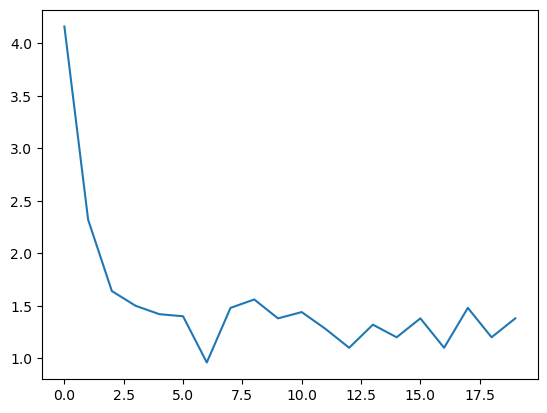

In [8]:
x = torch.tensor(step_counts, dtype=float).reshape(20, int(len(step_counts) / 20)).mean(1).numpy()
plt.plot(x)